<p style="color: darkred; font-size: 30px; text-align: center;"><b>TIME SERIES ANALYSIS - SPRING 2025 HOME-TAKEN PROJECT</b></p>
<p style="color: darkred; font-size: 20px; text-align: center;">TOPIC #1
FORECASTING FINANCIAL INSTRUMENTS PRICES WITH VECM AND ARIMA MODELS</p>
<p style="font-size: 20px; text-align: center;">Anindita Basu(466254), Vikram Bahadur(466547)</p>
<p style="font-size: 20px; text-align: center;">2025</p>

<p align="center">
  <img src="img/wne-logo-new-en.jpg" width="498" height="107">
</p>

<hr/>

## 1. Import Required Libraries and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pandas as pd # for data processing
import numpy as np # here mostly for series generation
import matplotlib.pyplot as plt # for vizualization
import matplotlib.dates as mdates # for data formatting when visualizing
import matplotlib.ticker as ticker # for more advanced axis formatting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # ACF, PACF plots
import statsmodels.api as sm # for linear regression model, OLS estimation
import statsmodels.stats.diagnostic as smd # for Breusch-Godfrey test
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VECM
from statsmodels.tsa.vector_ar.vecm import select_order, select_coint_rank, coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import norm
from IPython.display import display
warnings.simplefilter("ignore", category="UserWarning")
warnings.simplefilter("ignore", category="ValueWarning")
# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
def adf_test(series, max_aug=10, version='n'):
    
    results = []

    y = series.diff()
    X = pd.DataFrame({'y_lag': series.shift()})

    if version == 'c' or version == 't': # constant to be added optionally 
        X = sm.add_constant(X)
    if version == 't': # (deterministic) trend component to be added optionally
        X['trend'] = range(len(X))

    for i in range(0, max_aug): # iterating through different numbers of augmentations
        #print('aug', i)
        
        for aug in range(1, i+1): # adding augmentations one by one until its current amount is reached
            X['aug_'+str(aug)] = y.shift(aug)

        model = sm.OLS(series.diff(), X, missing='drop').fit() # fitting a linear regression with OLS

        ts = model.tvalues['y_lag'] # test statistic
        nobs = model.nobs # number of observations

        if version == 'n': # critical values for basic version of ADF
            if nobs > 500:
                cv1 = -2.567; cv5 = -1.941; cv10 = -1.616 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 'c': # critical values for version with constant
            if nobs > 500:
                cv1 = -3.434; cv5 = -2.863; cv10 = -2.568 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually
        if version == 't': # critical values for version with constant and (deterministic) trend component
            if nobs > 500:
                cv1 = -3.963; cv5 = -3.413; cv10 = -3.128 # critical values for more than 500 observations
            else:
                cv1 = np.nan; cv5 = np.nan; cv10 = np.nan # if number of observations is lower than 500, we should check the critical values manually

        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=5); bg_pvalue5 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=10); bg_pvalue10 = round(bg_test5[1],4)
        bg_test5 = smd.acorr_breusch_godfrey(model, nlags=15); bg_pvalue15 = round(bg_test5[1],4)

        results.append([i, ts, cv1, cv5, cv10, bg_pvalue5, bg_pvalue10, bg_pvalue15])

    results_df = pd.DataFrame(results)
    results_df.columns = ['number of augmentations', 'ADF test statistic', 'ADF critival value (1%)', 'ADF critival value (5%)', 'ADF critival value (10%)', 'BG test (5 lags) (p-value)', 'BG test (10 lags) (p-value)', 'BG test (15 lags) (p-value)']
    display(results_df)
    return results_df

## 2. Time series data import

In [3]:
# Set display and plotting options
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")

sns.set_context("talk")

# 1. Data importing
# Load the dataset
df = pd.read_csv("TSA_2025_project_data_1.csv")

# Check structure
print(df.info())
print(df.head())
print(df.tail())

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.set_index('date', inplace=True)

# Data set for finding model
df_short = df.iloc[:-25] 

# Data set for forecasting
df_oos = df.tail(25)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    600 non-null    object 
 1   y1      600 non-null    float64
 2   y2      600 non-null    float64
 3   y3      600 non-null    float64
 4   y4      600 non-null    float64
 5   y5      600 non-null    float64
 6   y6      600 non-null    float64
 7   y7      600 non-null    float64
 8   y8      600 non-null    float64
 9   y9      600 non-null    float64
 10  y10     600 non-null    float64
dtypes: float64(10), object(1)
memory usage: 51.7+ KB
None
         date       y1       y2       y3       y4       y5       y6       y7  \
0  2023-09-09 109.4100 109.4100 109.4100 124.2400 124.4700 109.4100 119.9400   
1  2023-09-10 109.4100 109.4100 109.4100 124.2100 124.3200 109.4100 101.3900   
2  2023-09-11 109.4200 109.4100 109.4100 124.4100 124.3700 109.4100  97.6400   
3  2023-09-12 108.6800 110.1900 111

In [4]:
# # Ensure only y1 to y10 columns are selected
price_cols = [f"y{i}" for i in range(1, 11)]
df_short = df_short.copy()
for col in price_cols:
    df_short[f'd{col}'] = df_short[col].diff()

In [5]:
# Preview the transformed data
df_short.head()

y1       y2       y3       y4       y5       y6       y7  \
date                                                                        
2023-09-09 109.4100 109.4100 109.4100 124.2400 124.4700 109.4100 119.9400   
2023-09-10 109.4100 109.4100 109.4100 124.2100 124.3200 109.4100 101.3900   
2023-09-11 109.4200 109.4100 109.4100 124.4100 124.3700 109.4100  97.6400   
2023-09-12 108.6800 110.1900 111.1200 123.9300 124.8200 109.4100  94.3500   
2023-09-13 106.2100 110.8800 112.9200 122.6800 123.9100 107.8400  96.2200   

                 y8       y9      y10     dy1    dy2    dy3     dy4     dy5  \
date                                                                          
2023-09-09 104.6600 107.6200 119.3200     NaN    NaN    NaN     NaN     NaN   
2023-09-10 104.3400 102.6100 119.3600  0.0000 0.0000 0.0000 -0.0300 -0.1500   
2023-09-11 104.2300  99.1600 119.3800  0.0100 0.0000 0.0000  0.2000  0.0500   
2023-09-12 107.2300 103.3900 121.0600 -0.7400 0.7800 1.7100 -0.4800  0.4500   
2023-09-13 109.7100 102.4300 122.1700 -2.4700 0.6900 1.8000 -1.2500 -0.9100   

               dy6      dy7     dy8     dy9   dy10  
date                                                
2023-09-09     NaN      NaN     NaN     NaN    NaN  
2023-09-10  0.0000 -18.5500 -0.3200 -5.0100 0.0400  
2023-09-11  0.0000  -3.7500 -0.1100 -3.4500 0.0200  
2023-09-12  0.0000  -3.2900  3.0000  4.2300 1.6800  
2023-09-13 -1.5700   1.8700  2.4800 -0.9600 1.1100

## 3. Initial Visualization

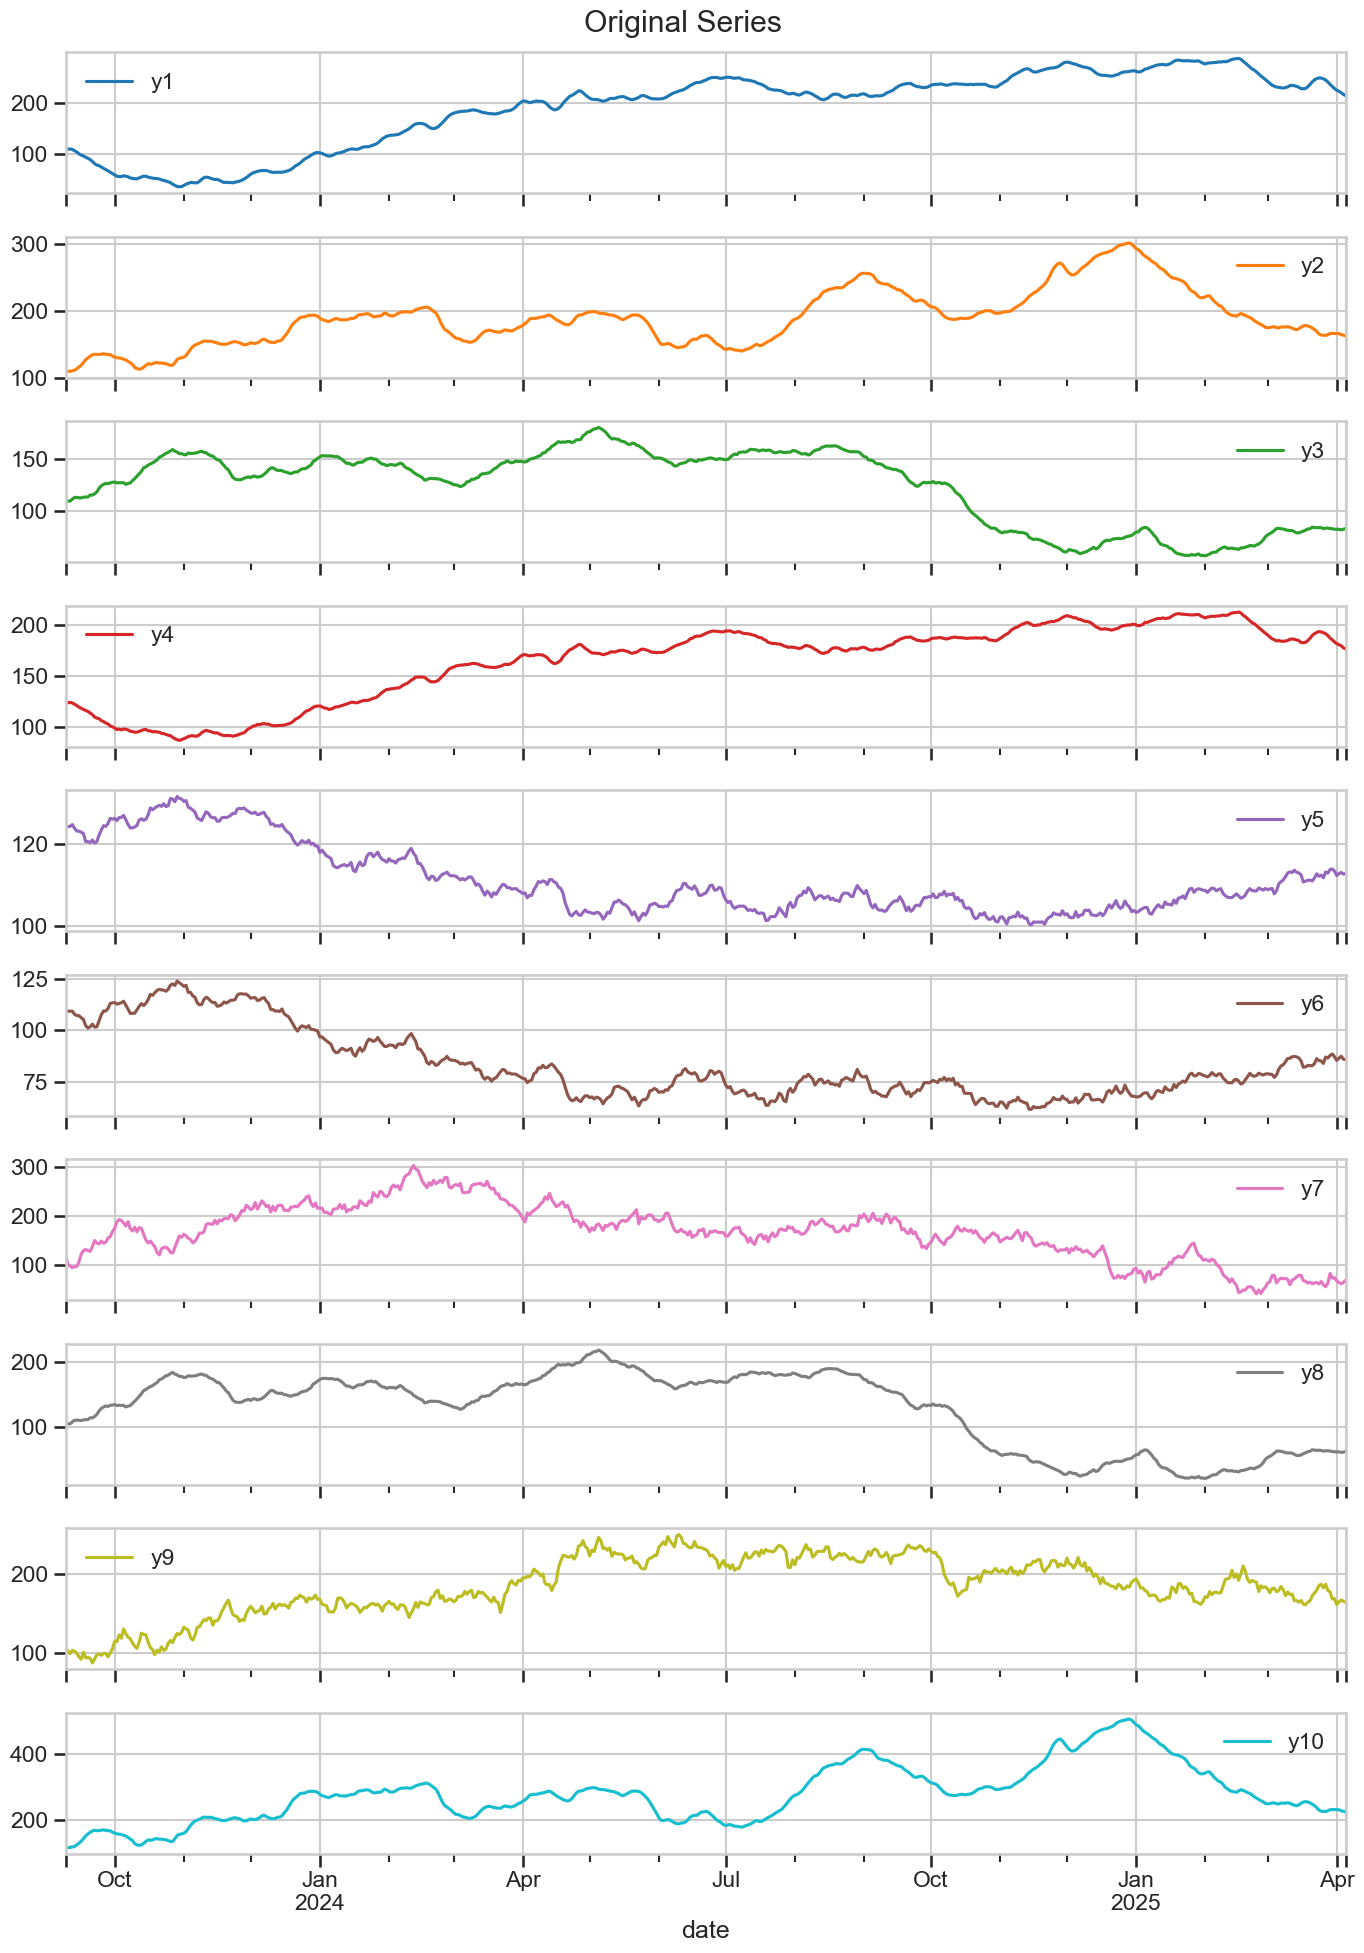

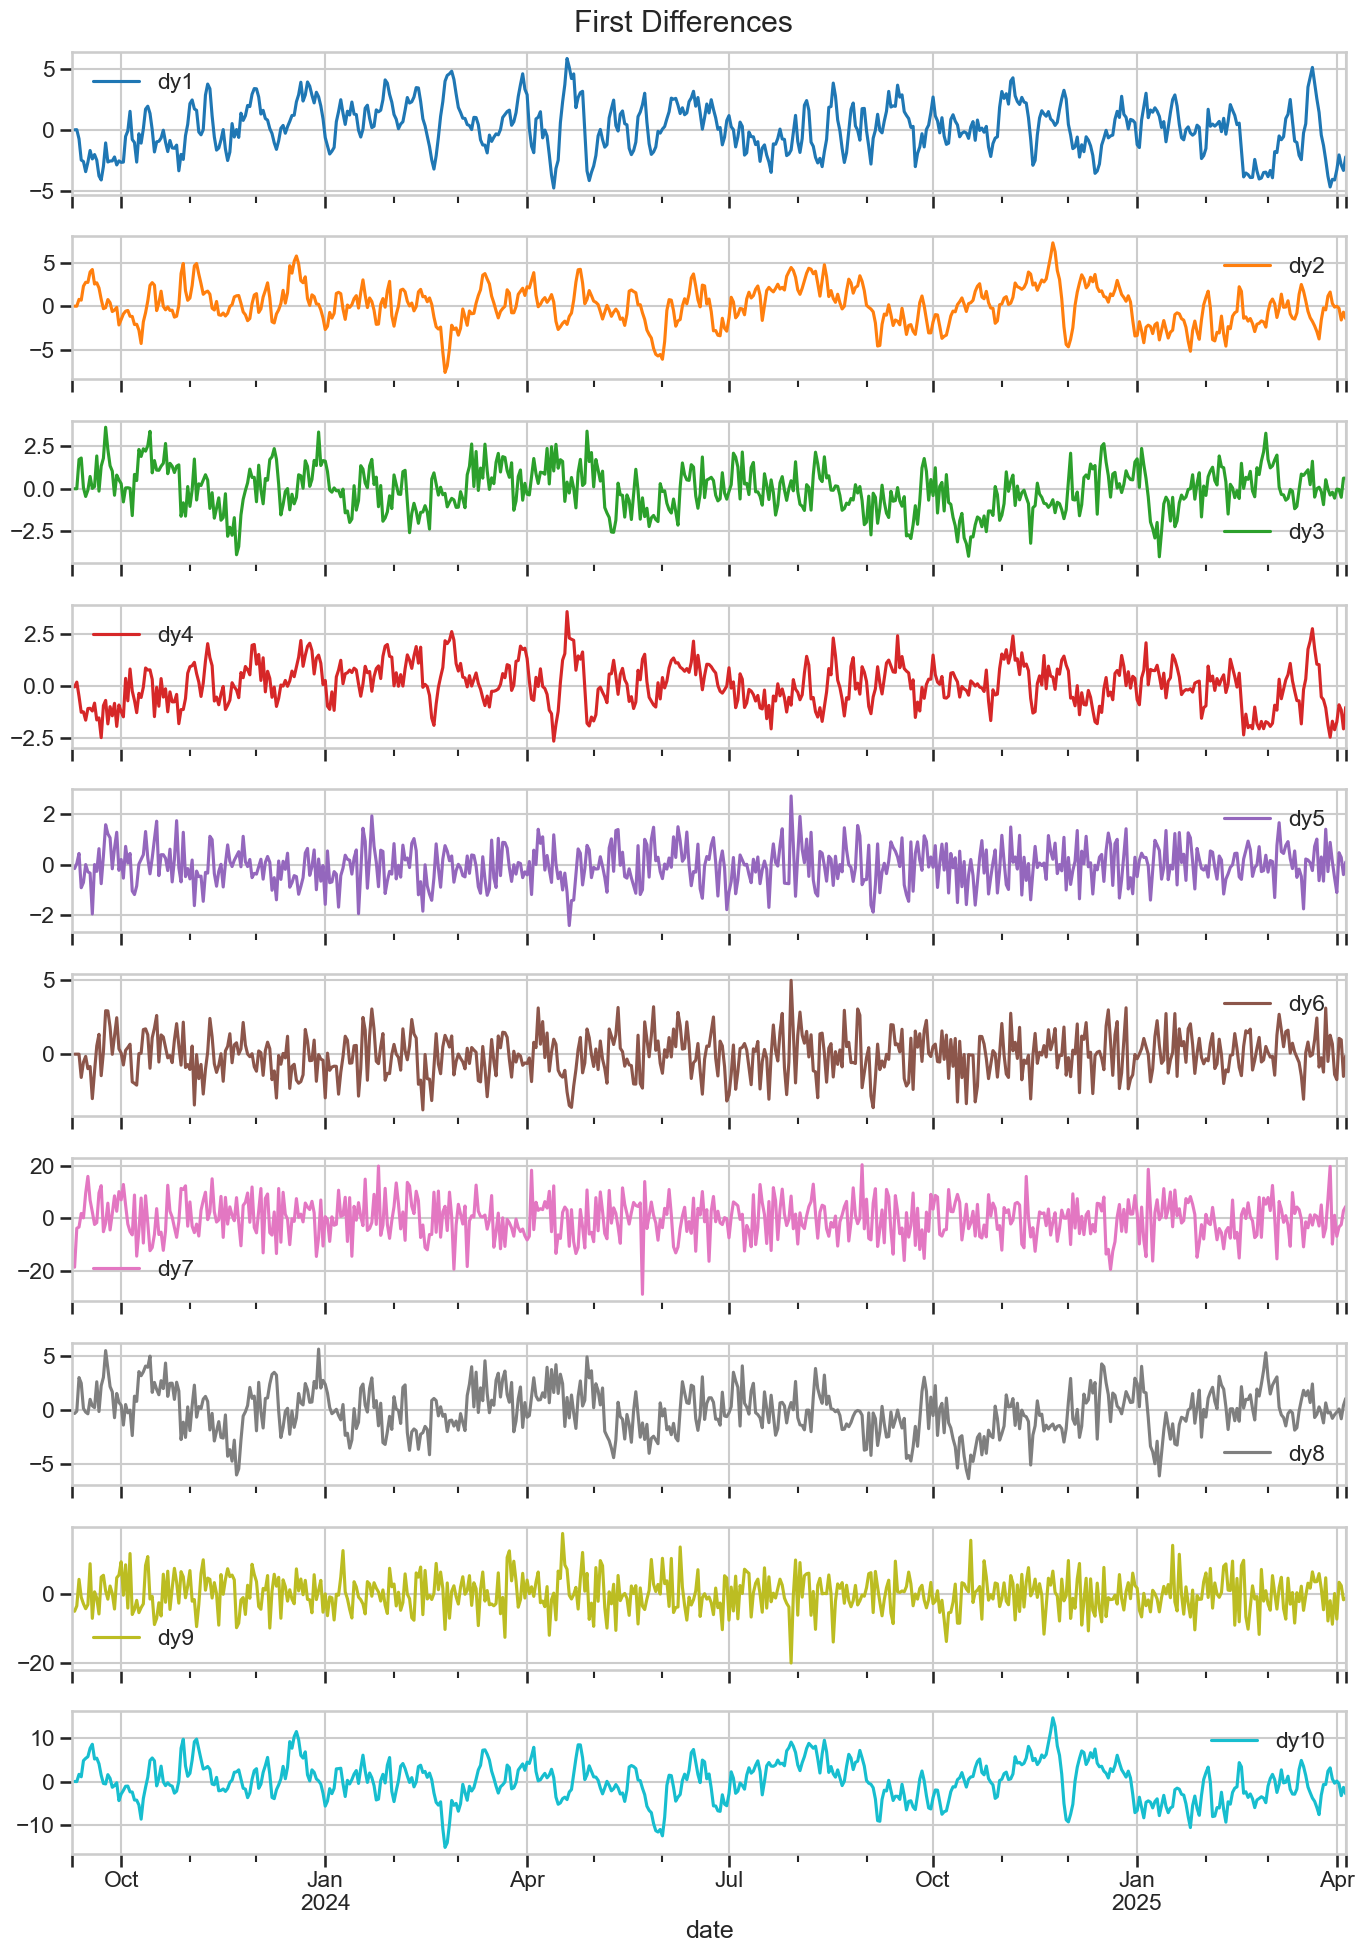

In [6]:
# Plot raw time series data
df_short[price_cols].plot(subplots=True, figsize=(14, 20), title="Original Series")
plt.tight_layout()
plt.show()

# Plot first differences
diff_cols = [f'd{col}' for col in price_cols]
df_short[diff_cols].plot(subplots=True, figsize=(14, 20), title="First Differences")
plt.tight_layout()
plt.show()


## 4. Finding the cointegration pairs
ADF Test for Each Series and their first diff

In [7]:
for i in range(1, 11):
    if i!= 3 and i!= 6:
        y = f'y{i}'
        dy = f'dy{i}'
        print(y)
        t1 = adf_test(df_short[y])

y1


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0              1.6336                  -2.5670   
1                        1              0.0174                  -2.5670   
2                        2              0.2880                  -2.5670   
3                        3              0.4719                  -2.5670   
4                        4              0.3328                  -2.5670   
5                        5              0.3828                  -2.5670   
6                        6              0.5268                  -2.5670   
7                        7              0.4499                  -2.5670   
8                        8              0.5126                  -2.5670   
9                        9              0.4444                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0000                       0.0000   
2                      0.0000                       0.0000   
3                      0.0001                       0.0002   
4                      0.0713                       0.1007   
5                      0.0106                       0.0222   
6                      0.0477                       0.1680   
7                      0.1554                       0.1464   
8                      0.1149                       0.0316   
9                      0.1102                       0.0605   

   BG test (15 lags) (p-value)  
0                       0.0000  
1                       0.0000  
2                       0.0000  
3                       0.0007  
4                       0.0325  
5                       0.0238  
6                       0.1440  
7                       0.1091  
8                       0.1087  
9                       0.0501

y2


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0              0.5567                  -2.5670   
1                        1             -0.3477                  -2.5670   
2                        2             -0.1436                  -2.5670   
3                        3             -0.3106                  -2.5670   
4                        4             -0.2041                  -2.5670   
5                        5             -0.3427                  -2.5670   
6                        6             -0.2647                  -2.5670   
7                        7             -0.3241                  -2.5670   
8                        8             -0.3403                  -2.5670   
9                        9             -0.3908                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0000                       0.0000   
2                      0.0000                       0.0000   
3                      0.0000                       0.0000   
4                      0.0000                       0.0003   
5                      0.0034                       0.0192   
6                      0.2066                       0.2920   
7                      0.1211                       0.3662   
8                      0.5275                       0.2668   
9                      0.1279                       0.4331   

   BG test (15 lags) (p-value)  
0                       0.0000  
1                       0.0000  
2                       0.0000  
3                       0.0001  
4                       0.0020  
5                       0.1079  
6                       0.5907  
7                       0.6637  
8                       0.5263  
9                       0.5895

y4


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0              1.8379                  -2.5670   
1                        1              0.5152                  -2.5670   
2                        2              0.3613                  -2.5670   
3                        3              0.5653                  -2.5670   
4                        4              0.6342                  -2.5670   
5                        5              0.5962                  -2.5670   
6                        6              0.6890                  -2.5670   
7                        7              0.6632                  -2.5670   
8                        8              0.7385                  -2.5670   
9                        9              0.6856                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0000                       0.0002   
2                      0.0009                       0.0063   
3                      0.1653                       0.2979   
4                      0.3659                       0.4055   
5                      0.1576                       0.4738   
6                      0.3685                       0.5534   
7                      0.3044                       0.3199   
8                      0.3023                       0.2069   
9                      0.2149                       0.0670   

   BG test (15 lags) (p-value)  
0                       0.0000  
1                       0.0007  
2                       0.0168  
3                       0.3261  
4                       0.4112  
5                       0.3161  
6                       0.4025  
7                       0.3238  
8                       0.1441  
9                       0.0869

y5


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0             -0.7649                  -2.5670   
1                        1             -0.6943                  -2.5670   
2                        2             -0.7158                  -2.5670   
3                        3             -0.7373                  -2.5670   
4                        4             -0.5499                  -2.5670   
5                        5             -0.5609                  -2.5670   
6                        6             -0.5825                  -2.5670   
7                        7             -0.5948                  -2.5670   
8                        8             -0.6605                  -2.5670   
9                        9             -0.5234                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0000                       0.0000   
2                      0.0000                       0.0000   
3                      0.0000                       0.0000   
4                      0.0001                       0.0018   
5                      0.0144                       0.0505   
6                      0.0030                       0.0487   
7                      0.0051                       0.0047   
8                      0.2316                       0.0750   
9                      0.5895                       0.0616   

   BG test (15 lags) (p-value)  
0                       0.0000  
1                       0.0000  
2                       0.0000  
3                       0.0000  
4                       0.0020  
5                       0.0245  
6                       0.0127  
7                       0.0058  
8                       0.1972  
9                       0.1217

y7


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0             -0.6512                  -2.5670   
1                        1             -0.5737                  -2.5670   
2                        2             -0.5695                  -2.5670   
3                        3             -0.5623                  -2.5670   
4                        4             -0.5502                  -2.5670   
5                        5             -0.5287                  -2.5670   
6                        6             -0.5834                  -2.5670   
7                        7             -0.6639                  -2.5670   
8                        8             -0.6740                  -2.5670   
9                        9             -0.6924                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.3602                       0.0220   
1                      0.3802                       0.0144   
2                      0.4385                       0.0160   
3                      0.4686                       0.0103   
4                      0.0338                       0.0036   
5                      0.0007                       0.0065   
6                      0.0014                       0.0104   
7                      0.1980                       0.0882   
8                      0.1478                       0.3257   
9                      0.0330                       0.2463   

   BG test (15 lags) (p-value)  
0                       0.0312  
1                       0.0242  
2                       0.0283  
3                       0.0194  
4                       0.0060  
5                       0.0139  
6                       0.0315  
7                       0.0859  
8                       0.1099  
9                       0.1210

y8


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0             -0.6899                  -2.5670   
1                        1             -0.6008                  -2.5670   
2                        2             -0.6395                  -2.5670   
3                        3             -0.7224                  -2.5670   
4                        4             -0.7776                  -2.5670   
5                        5             -0.7366                  -2.5670   
6                        6             -0.6902                  -2.5670   
7                        7             -0.6884                  -2.5670   
8                        8             -0.7066                  -2.5670   
9                        9             -0.7230                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0000                       0.0000   
2                      0.0055                       0.0501   
3                      0.0995                       0.1913   
4                      0.1420                       0.4569   
5                      0.2696                       0.6076   
6                      0.7372                       0.9132   
7                      0.9215                       0.9861   
8                      0.6864                       0.6041   
9                      0.5234                       0.5181   

   BG test (15 lags) (p-value)  
0                       0.0000  
1                       0.0001  
2                       0.1663  
3                       0.3980  
4                       0.6562  
5                       0.7813  
6                       0.6784  
7                       0.8648  
8                       0.3621  
9                       0.5370

y9


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0              0.0054                  -2.5670   
1                        1              0.0432                  -2.5670   
2                        2              0.0385                  -2.5670   
3                        3              0.0363                  -2.5670   
4                        4              0.0736                  -2.5670   
5                        5              0.1093                  -2.5670   
6                        6              0.1496                  -2.5670   
7                        7              0.2068                  -2.5670   
8                        8              0.1432                  -2.5670   
9                        9              0.1587                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.1521                       0.3618   
1                      0.0951                       0.2838   
2                      0.1194                       0.3140   
3                      0.1210                       0.2730   
4                      0.2136                       0.2060   
5                      0.0227                       0.1178   
6                      0.0345                       0.1050   
7                      0.0730                       0.1881   
8                      0.0612                       0.2899   
9                      0.1891                       0.4995   

   BG test (15 lags) (p-value)  
0                       0.3592  
1                       0.2783  
2                       0.3149  
3                       0.2767  
4                       0.1988  
5                       0.1149  
6                       0.1054  
7                       0.1891  
8                       0.2139  
9                       0.3198

y10


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0              0.4031                  -2.5670   
1                        1             -0.5358                  -2.5670   
2                        2             -0.3059                  -2.5670   
3                        3             -0.4779                  -2.5670   
4                        4             -0.3657                  -2.5670   
5                        5             -0.4998                  -2.5670   
6                        6             -0.4174                  -2.5670   
7                        7             -0.4669                  -2.5670   
8                        8             -0.4791                  -2.5670   
9                        9             -0.5291                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0000                       0.0000   
2                      0.0000                       0.0000   
3                      0.0000                       0.0000   
4                      0.0003                       0.0011   
5                      0.0148                       0.0475   
6                      0.3098                       0.2768   
7                      0.1512                       0.2835   
8                      0.3900                       0.1911   
9                      0.1057                       0.4195   

   BG test (15 lags) (p-value)  
0                       0.0000  
1                       0.0000  
2                       0.0000  
3                       0.0004  
4                       0.0038  
5                       0.1557  
6                       0.4888  
7                       0.4763  
8                       0.3227  
9                       0.3862

None of the series above is stationary

In [8]:
for i in range(1, 11):
    if i!= 3 and i!= 6:
        y = f'y{i}'
        dy = f'dy{i}'
        print(dy)
        t2 = adf_test(df_short[dy])

dy1


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0             -6.8433                  -2.5670   
1                        1             -8.4521                  -2.5670   
2                        2             -9.2249                  -2.5670   
3                        3             -7.3317                  -2.5670   
4                        4             -7.2724                  -2.5670   
5                        5             -7.6292                  -2.5670   
6                        6             -6.8047                  -2.5670   
7                        7             -6.8519                  -2.5670   
8                        8             -6.0987                  -2.5670   
9                        9             -6.1357                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0000                       0.0000   
2                      0.0003                       0.0005   
3                      0.1575                       0.1896   
4                      0.0249                       0.0496   
5                      0.1144                       0.3345   
6                      0.3423                       0.3021   
7                      0.2539                       0.0665   
8                      0.3054                       0.1596   
9                      0.1571                       0.3451   

   BG test (15 lags) (p-value)  
0                       0.0000  
1                       0.0001  
2                       0.0015  
3                       0.0681  
4                       0.0535  
5                       0.2636  
6                       0.2291  
7                       0.2127  
8                       0.1381  
9                       0.3362

dy2


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0             -6.5282                  -2.5670   
1                        1             -8.5113                  -2.5670   
2                        2             -6.4575                  -2.5670   
3                        3             -7.2526                  -2.5670   
4                        4             -6.0589                  -2.5670   
5                        5             -6.5798                  -2.5670   
6                        6             -5.9954                  -2.5670   
7                        7             -5.9798                  -2.5670   
8                        8             -5.5255                  -2.5670   
9                        9             -5.0681                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0000                       0.0000   
2                      0.0000                       0.0000   
3                      0.0005                       0.0013   
4                      0.0193                       0.0753   
5                      0.6948                       0.6619   
6                      0.4666                       0.7827   
7                      0.9990                       0.6538   
8                      0.5367                       0.8667   
9                      0.7879                       0.9461   

   BG test (15 lags) (p-value)  
0                       0.0000  
1                       0.0000  
2                       0.0004  
3                       0.0084  
4                       0.2803  
5                       0.8792  
6                       0.9356  
7                       0.8591  
8                       0.9232  
9                       0.9786

dy4


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0             -9.3476                  -2.5670   
1                        1             -7.5528                  -2.5670   
2                        2             -8.5193                  -2.5670   
3                        3             -8.1932                  -2.5670   
4                        4             -7.3883                  -2.5670   
5                        5             -7.4258                  -2.5670   
6                        6             -6.9138                  -2.5670   
7                        7             -6.9455                  -2.5670   
8                        8             -6.2605                  -2.5670   
9                        9             -6.1121                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0004   
1                      0.0016                       0.0103   
2                      0.3159                       0.4771   
3                      0.6506                       0.6414   
4                      0.3219                       0.7212   
5                      0.6637                       0.8192   
6                      0.6043                       0.5529   
7                      0.6109                       0.3510   
8                      0.5192                       0.1649   
9                      0.2065                       0.2181   

   BG test (15 lags) (p-value)  
0                       0.0014  
1                       0.0253  
2                       0.4775  
3                       0.5932  
4                       0.5134  
5                       0.6193  
6                       0.5264  
7                       0.2774  
8                       0.1914  
9                       0.2587

dy5


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0            -21.4861                  -2.5670   
1                        1            -16.5059                  -2.5670   
2                        2            -13.4179                  -2.5670   
3                        3             -8.9676                  -2.5670   
4                        4             -9.4908                  -2.5670   
5                        5             -9.1996                  -2.5670   
6                        6             -9.3755                  -2.5670   
7                        7             -9.8076                  -2.5670   
8                        8             -8.7557                  -2.5670   
9                        9             -8.4262                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0000                       0.0000   
2                      0.0000                       0.0000   
3                      0.0002                       0.0041   
4                      0.0413                       0.0883   
5                      0.0067                       0.0856   
6                      0.0102                       0.0112   
7                      0.4340                       0.1498   
8                      0.8494                       0.1450   
9                      0.9125                       0.2252   

   BG test (15 lags) (p-value)  
0                       0.0000  
1                       0.0000  
2                       0.0000  
3                       0.0038  
4                       0.0390  
5                       0.0233  
6                       0.0114  
7                       0.3217  
8                       0.2362  
9                       0.2500

dy7


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0            -24.6391                  -2.5670   
1                        1            -16.5753                  -2.5670   
2                        2            -13.5015                  -2.5670   
3                        3            -12.3767                  -2.5670   
4                        4            -11.6353                  -2.5670   
5                        5             -9.5449                  -2.5670   
6                        6             -8.4549                  -2.5670   
7                        7             -8.5444                  -2.5670   
8                        8             -7.6389                  -2.5670   
9                        9             -6.5462                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.4933                       0.0279   
1                      0.5972                       0.0311   
2                      0.5764                       0.0190   
3                      0.0468                       0.0062   
4                      0.0013                       0.0108   
5                      0.0025                       0.0160   
6                      0.2749                       0.1299   
7                      0.1934                       0.4150   
8                      0.0510                       0.3159   
9                      0.1062                       0.2088   

   BG test (15 lags) (p-value)  
0                       0.0369  
1                       0.0433  
2                       0.0285  
3                       0.0081  
4                       0.0186  
5                       0.0388  
6                       0.0997  
7                       0.1242  
8                       0.1342  
9                       0.3584

dy8


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0            -11.7144                  -2.5670   
1                        1             -8.3896                  -2.5670   
2                        2             -7.3448                  -2.5670   
3                        3             -6.3979                  -2.5670   
4                        4             -6.3024                  -2.5670   
5                        5             -6.6393                  -2.5670   
6                        6             -6.0897                  -2.5670   
7                        7             -5.8709                  -2.5670   
8                        8             -5.5174                  -2.5670   
9                        9             -5.3693                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0064                       0.0651   
2                      0.1132                       0.2224   
3                      0.1673                       0.5226   
4                      0.3149                       0.6820   
5                      0.8449                       0.9651   
6                      0.9718                       0.9959   
7                      0.8149                       0.6954   
8                      0.6721                       0.5975   
9                      0.2701                       0.5301   

   BG test (15 lags) (p-value)  
0                       0.0001  
1                       0.2042  
2                       0.4451  
3                       0.7226  
4                       0.8457  
5                       0.7266  
6                       0.9061  
7                       0.4120  
8                       0.5909  
9                       0.4562

dy9


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0            -24.4627                  -2.5670   
1                        1            -16.5691                  -2.5670   
2                        2            -13.9383                  -2.5670   
3                        3            -12.6563                  -2.5670   
4                        4            -11.4980                  -2.5670   
5                        5            -10.6509                  -2.5670   
6                        6            -10.2699                  -2.5670   
7                        7             -9.0609                  -2.5670   
8                        8             -8.2883                  -2.5670   
9                        9             -7.8849                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.5772                       0.7614   
1                      0.6489                       0.7882   
2                      0.7256                       0.7961   
3                      0.8586                       0.6678   
4                      0.2454                       0.5073   
5                      0.3108                       0.5366   
6                      0.6032                       0.7001   
7                      0.6632                       0.9024   
8                      0.9744                       0.9880   
9                      0.7253                       0.6866   

   BG test (15 lags) (p-value)  
0                       0.6291  
1                       0.6741  
2                       0.6673  
3                       0.5120  
4                       0.4147  
5                       0.4528  
6                       0.5703  
7                       0.6680  
8                       0.7784  
9                       0.6391

dy10


number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                        0             -6.5515                  -2.5670   
1                        1             -8.4695                  -2.5670   
2                        2             -6.5203                  -2.5670   
3                        3             -7.2016                  -2.5670   
4                        4             -6.1090                  -2.5670   
5                        5             -6.5160                  -2.5670   
6                        6             -6.0786                  -2.5670   
7                        7             -5.9431                  -2.5670   
8                        8             -5.5796                  -2.5670   
9                        9             -5.0200                  -2.5670   

   ADF critival value (5%)  ADF critival value (10%)  \
0                  -1.9410                   -1.6160   
1                  -1.9410                   -1.6160   
2                  -1.9410                   -1.6160   
3                  -1.9410                   -1.6160   
4                  -1.9410                   -1.6160   
5                  -1.9410                   -1.6160   
6                  -1.9410                   -1.6160   
7                  -1.9410                   -1.6160   
8                  -1.9410                   -1.6160   
9                  -1.9410                   -1.6160   

   BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                      0.0000                       0.0000   
1                      0.0000                       0.0000   
2                      0.0001                       0.0002   
3                      0.0020                       0.0064   
4                      0.0703                       0.1498   
5                      0.8261                       0.6149   
6                      0.5026                       0.6545   
7                      0.9069                       0.5051   
8                      0.4123                       0.8208   
9                      0.6084                       0.8051   

   BG test (15 lags) (p-value)  
0                       0.0000  
1                       0.0000  
2                       0.0021  
3                       0.0148  
4                       0.3498  
5                       0.7834  
6                       0.7948  
7                       0.6387  
8                       0.7457  
9                       0.9448

the first differences are stationary

### Selecting Candidate Pairs

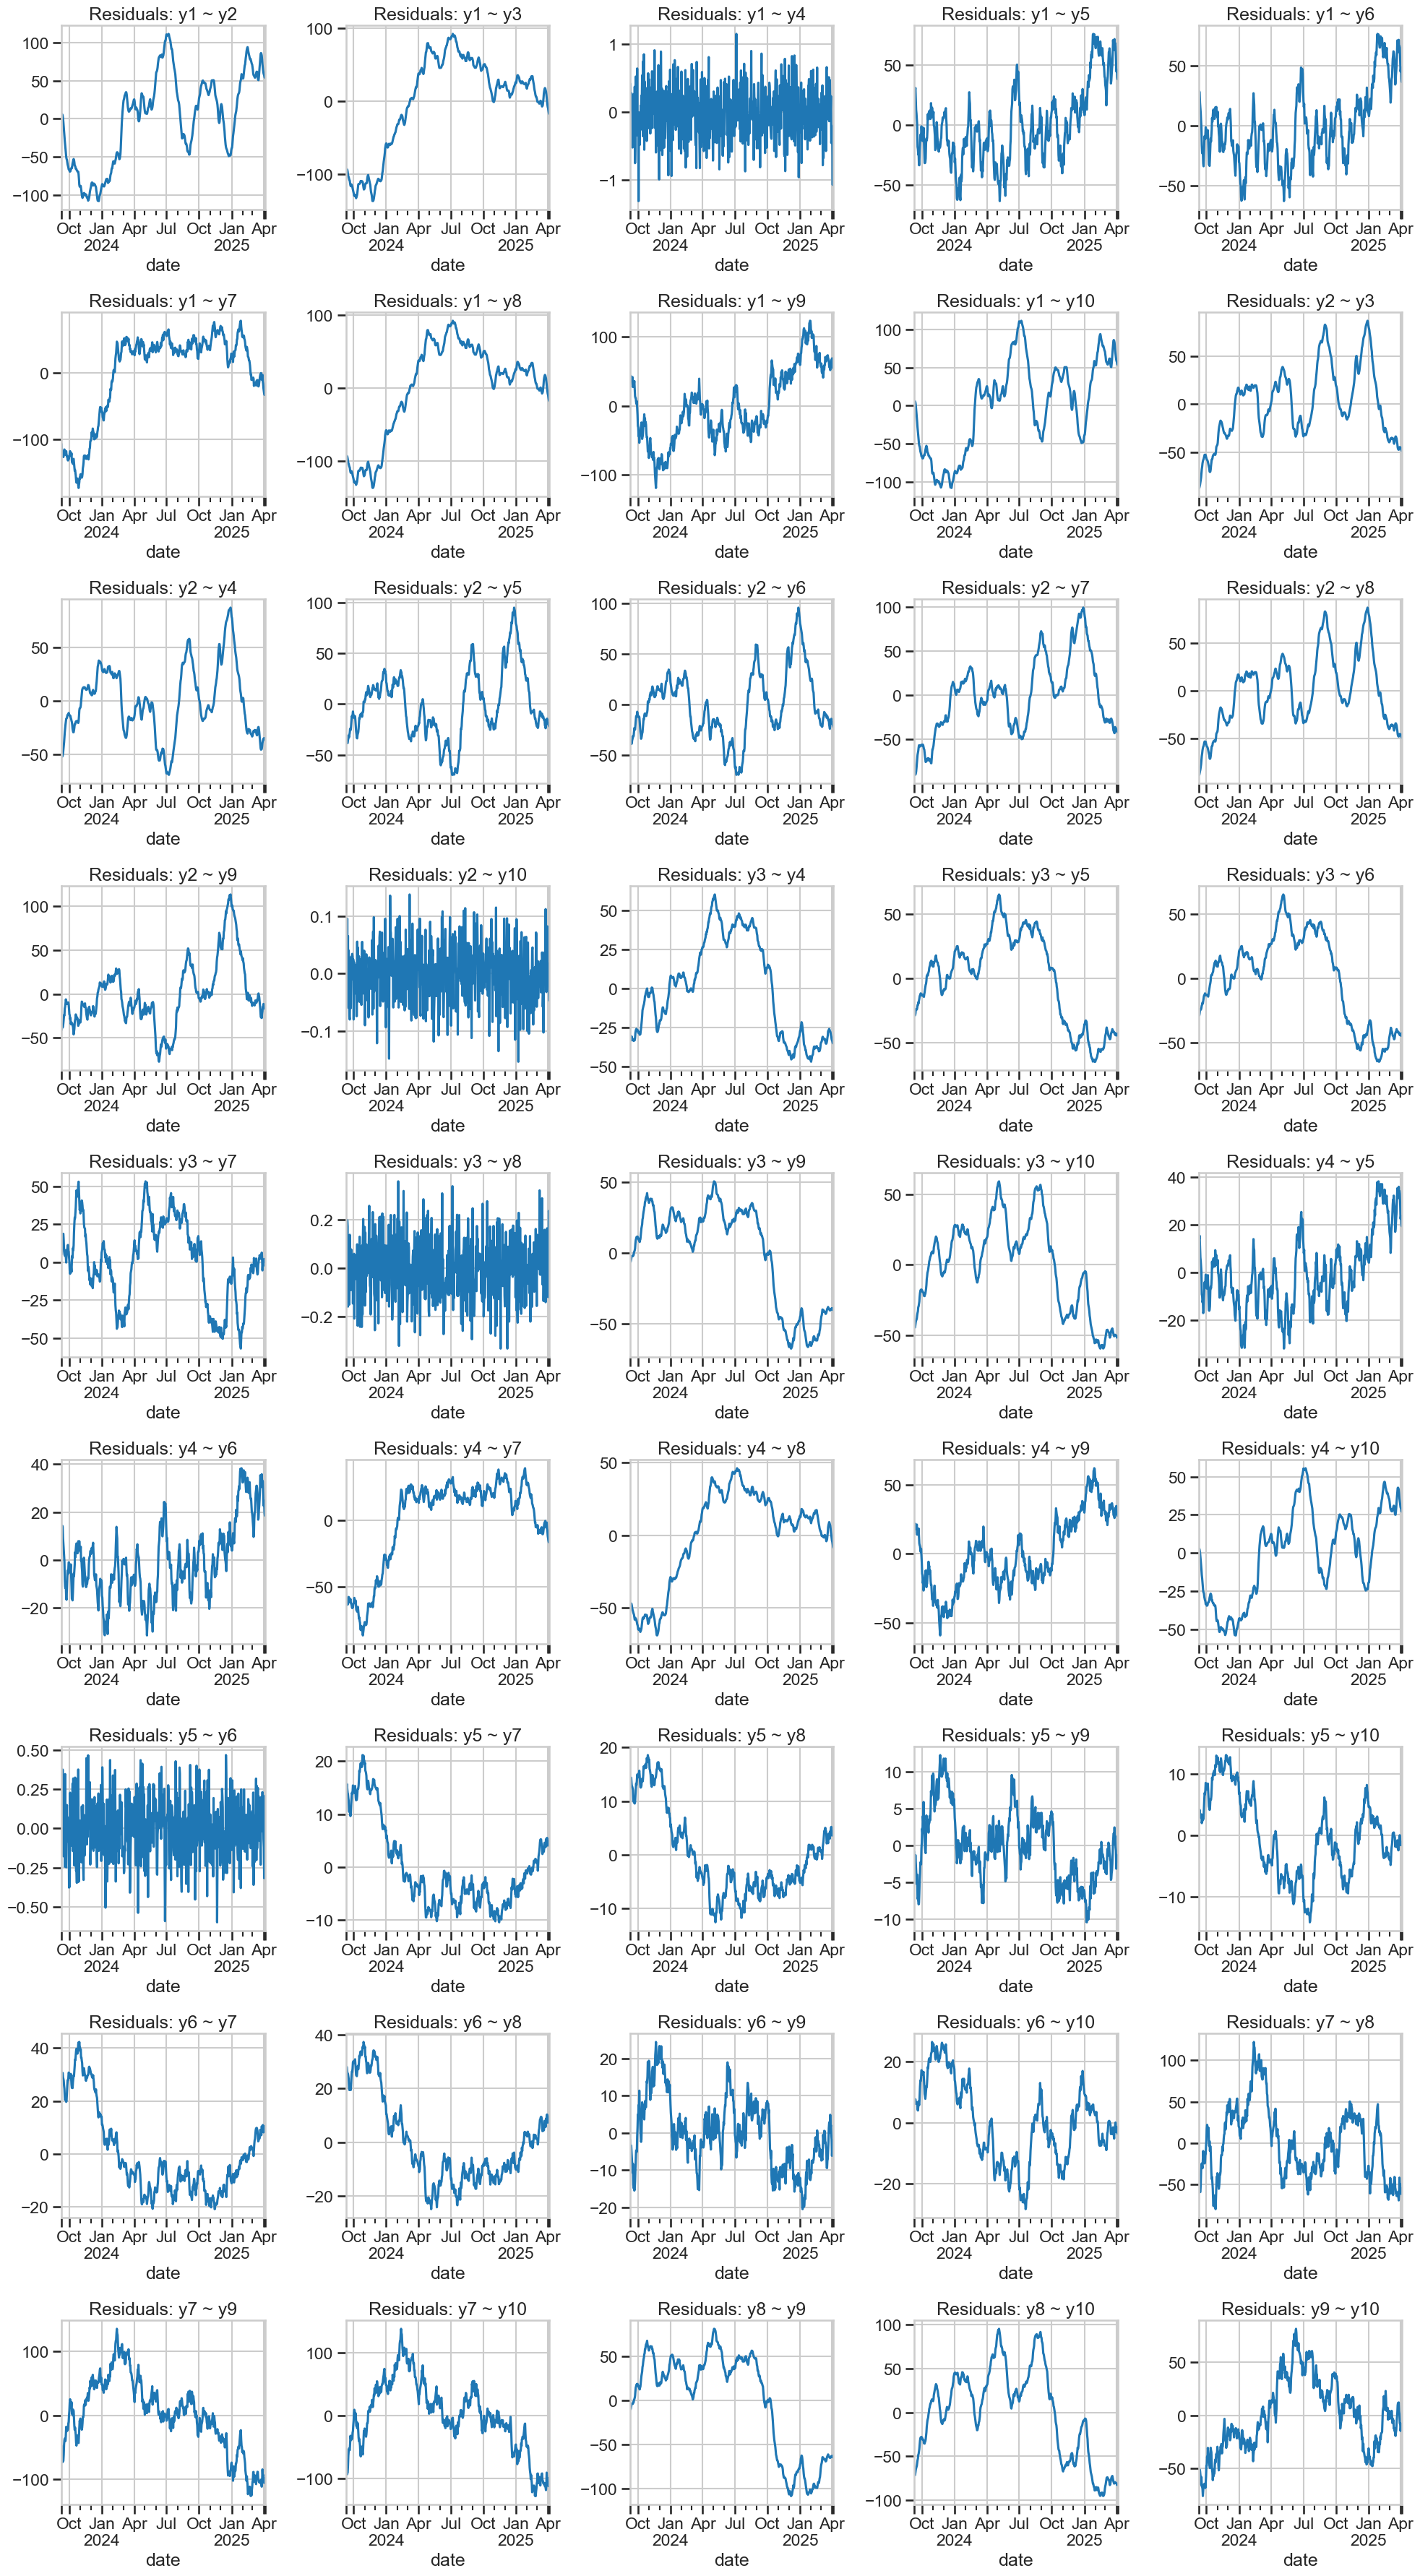

In [9]:
# List of variables
Y = [f'y{i}' for i in range(1, 11)]

# Prepare figure
num_pairs = sum(1 for i in range(9) for j in range(i + 1, 10))  # 45 pairs
ncols = 5
nrows = (num_pairs + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 4 * nrows))
axes = axes.flatten()

# Loop through pairs and plot residuals
plot_idx = 0
for i in range(9):
    for j in range(i + 1, 10):
        y_i = df_short[Y[i]]
        y_j = df_short[Y[j]]

        X_pair = sm.add_constant(y_j)
        model_pair = sm.OLS(y_i, X_pair).fit()
        resid_pair = model_pair.resid

        # Plot residuals
        ax = axes[plot_idx]
        resid_pair.plot(ax=ax)
        ax.set_title(f'Residuals: {Y[i]} ~ {Y[j]}')
        ax.grid(True)

        plot_idx += 1

# Remove any empty subplots
for k in range(plot_idx, len(axes)):
    fig.delaxes(axes[k])

plt.tight_layout()
plt.show()

A quick eyeballing may give potential pairs.

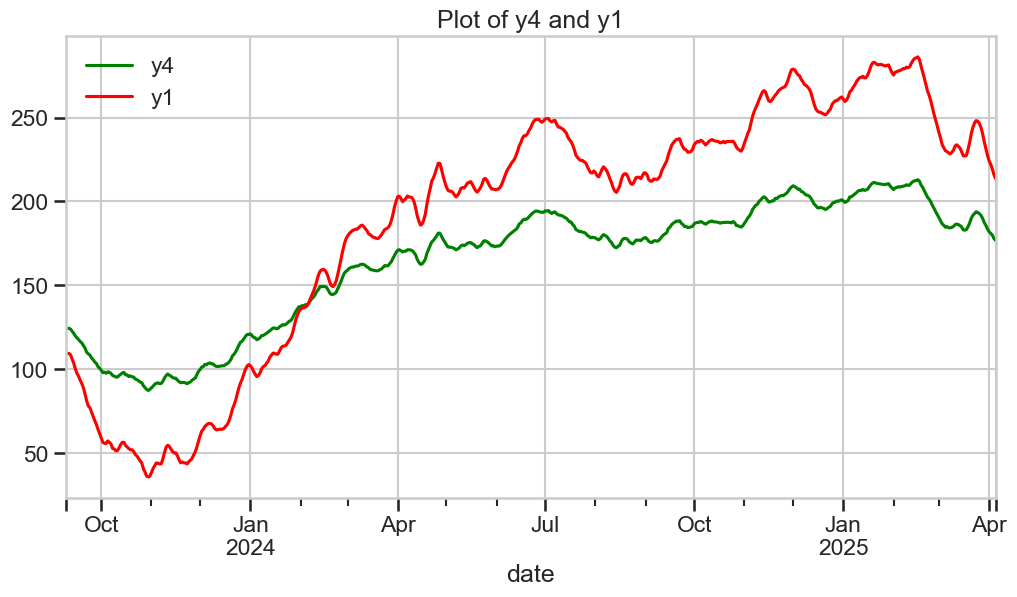

In [10]:
# Plot y4 and y8
df_short[[f'y4', f'y1']].plot(figsize=(12, 6), color=['green', 'red'], title='Plot of y4 and y1')
plt.show()


In [11]:
# df = pd.read_csv("TSA_2025_project_data_1.csv")
# df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)
df['x'] = df_short['y1']
df['y'] = df_short['y4']
data_pair = df[['x', 'y']]


### Johansen Cointegration Test

In [12]:
data_pair = data_pair.dropna()
johansen_result = coint_johansen(data_pair,det_order=0, k_ar_diff=6)

In [13]:
print("--- Interpretation (Trace Test) ---")
hypotheses_trace = ['r <= 0', 'r <= 1']
for i in range(len(hypotheses_trace)):
    print(f"H0: {hypotheses_trace[i]}")
    print(f"  Trace Statistic: {johansen_result.lr1[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvt[i, 1]:.3f}")
    if johansen_result.lr1[i] > johansen_result.cvt[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

print("\n--- Interpretation (Max Eigenvalue Test) ---")
hypotheses_maxeig = ['r = 0', 'r = 1'] # H0: rank is r vs H1: rank is r+1
for i in range(len(hypotheses_maxeig)):
    print(f"H0: {hypotheses_maxeig[i]}")
    print(f"  Max Eigenvalue Statistic: {johansen_result.lr2[i]:.3f}")
    print(f"  Critical Value (95%): {johansen_result.cvm[i, 1]:.3f}")
    if johansen_result.lr2[i] > johansen_result.cvm[i, 1]:
        print("  Result: Reject H0 at 5% significance level.")
    else:
        print("  Result: Cannot reject H0 at 5% significance level.")

--- Interpretation (Trace Test) ---
H0: r <= 0
  Trace Statistic: 84.958
  Critical Value (95%): 15.494
  Result: Reject H0 at 5% significance level.
H0: r <= 1
  Trace Statistic: 1.685
  Critical Value (95%): 3.841
  Result: Cannot reject H0 at 5% significance level.

--- Interpretation (Max Eigenvalue Test) ---
H0: r = 0
  Max Eigenvalue Statistic: 83.273
  Critical Value (95%): 14.264
  Result: Reject H0 at 5% significance level.
H0: r = 1
  Max Eigenvalue Statistic: 1.685
  Critical Value (95%): 3.841
  Result: Cannot reject H0 at 5% significance level.


### Johansen Test Interpretation 

* Trace test:
  r ≤ 0 → reject → there is at least 1 cointegrating vector
  r ≤ 1 → cannot reject → no more than 1 cointegrating vector

* Max eigenvalue test:
  r = 0 → reject → at least 1 cointegrating vector
  r = 1 → cannot reject → no second cointegrating vector

**Conclusion:** rank = 1 → exactly one cointegrating relationship.


## 5. VECM
### VECM Estimation

In [14]:
vecm_model = VECM(data_pair.values, k_ar_diff=6, coint_rank=1, deterministic='ci')
vecm_results = vecm_model.fit()

#vecm_results.summary() this is throwing typerrror so can not get the param significance

In [15]:
# 1. Adjustment coefficients (alpha)
print("Adjustment coefficients (alpha):")
display(pd.DataFrame(vecm_results.alpha, index=['x','y'], columns=['ECT1']))

# 2. Cointegrating vector (beta)
print("\nCointegrating vector (beta):")
display(pd.DataFrame(vecm_results.beta, index=['x','y'], columns=['beta1']))

# 3. Constant term in cointegration
print("\nConstant in cointegration relation:")
print(vecm_results.det_coef_coint)

# 4. Short-run coefficients (Gamma matrices)
print("\nShort-run dynamics coefficients (gamma):")
gammas = pd.DataFrame(vecm_results.gamma, 
                      index=['x','y'], 
                      columns=[f'L{i+1} dX' if i%2==0 else f'L{i//2+1} dY' for i in range(vecm_results.gamma.shape[1])])
display(gammas)

# 5. Residual covariance matrix (sigma_u)
print("\nResidual covariance matrix (sigma_u):")
display(pd.DataFrame(vecm_results.sigma_u, index=['x','y'], columns=['x','y']))


Adjustment coefficients (alpha):


ECT1
x -0.4316
y  0.3185


Cointegrating vector (beta):


beta1
x  1.0000
y -1.9999


Constant in cointegration relation:
[[139.42159839]]

Short-run dynamics coefficients (gamma):


L1 dX   L1 dY  L3 dX   L2 dY   L5 dX   L3 dY  L7 dX   L4 dY  L9 dX   L5 dY  \
x 1.5718 -1.0625 0.2573 -0.6547 -0.2132 -0.2508 0.3782 -0.3576 0.1601 -0.2244   
y 0.7624 -0.5114 0.0965 -0.2514 -0.1510 -0.0236 0.1291 -0.0670 0.0358 -0.0256   

   L11 dX   L6 dY  
x -0.0339 -0.1042  
y -0.0173 -0.0566


Residual covariance matrix (sigma_u):


x      y
x 0.9727 0.4839
y 0.4839 0.2765

In [16]:
from scipy.stats import jarque_bera
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

# Get residuals
residuals = vecm_results.resid
residuals_df = pd.DataFrame(residuals, columns=['x', 'y'], index=data_pair.index[vecm_model.k_ar_diff+1:])

# === 1. Normality test (Jarque-Bera) ===
jb_x = jarque_bera(residuals_df['x'])
jb_y = jarque_bera(residuals_df['y'])

print("Jarque-Bera Test for Normality:")
print(f"X residuals: JB={jb_x[0]:.3f}, p-value={jb_x[1]:.4f}")
print(f"Y residuals: JB={jb_y[0]:.3f}, p-value={jb_y[1]:.4f}")

# === 2. Autocorrelation test (Ljung-Box) ===
lags = [12, 24, 36]

ljung_x = acorr_ljungbox(residuals_df['x'], lags=lags, return_df=True)
ljung_y = acorr_ljungbox(residuals_df['y'], lags=lags, return_df=True)

print("\nLjung-Box Test for Serial Correlation:")
print(f"\nX residuals:\n{ljung_x}")
print(f"\nY residuals:\n{ljung_y}")

Jarque-Bera Test for Normality:
X residuals: JB=0.659, p-value=0.7191
Y residuals: JB=0.791, p-value=0.6735

Ljung-Box Test for Serial Correlation:

X residuals:
    lb_stat  lb_pvalue
12  13.1968     0.3549
24  23.8125     0.4724
36  35.9059     0.4731

Y residuals:
    lb_stat  lb_pvalue
12  16.4006     0.1736
24  28.2597     0.2492
36  37.3655     0.4062


resudiala are normal.
There is no significant autocorrelation in the residuals.

#### VECM Model Summary

$$
\Delta X_t = \alpha_1 \cdot ECT_{t-1} + \sum \gamma_{1i} \Delta X_{t-i} + \sum \gamma_{1i} \Delta Y_{t-i} + \varepsilon_{1t}
$$
$$
\Delta Y_t = \alpha_2 \cdot ECT_{t-1} + \sum \gamma_{2i} \Delta X_{t-i} + \sum \gamma_{2i} \Delta Y_{t-i} + \varepsilon_{2t}
$$

with:

$$
ECT_{t-1} = X_{t-1} - 2 \cdot Y_{t-1}
$$

(cointegration vector β = [1, -2] from the output).

---

#### Cointegration Relationship:

- $ X_t $ and $ Y_t $ move in a **long-run ratio of ~2:1**.
- If $ X $ deviates from $ 2 \cdot Y $, the system tends to bring it back toward this equilibrium.

---

#### Adjustment Coefficients (α):

- **X equation:** α = -0.3616  
    → X adjusts downward when $ X_{t-1} > 2 \cdot Y_{t-1} $.  
    → X helps correct disequilibrium.

- **Y equation:** α = +0.3458  
    → Y adjusts upward when $ X_{t-1} > 2 \cdot Y_{t-1} $.  
    → Y also contributes to restoring equilibrium.

**Conclusion:** Both series actively participate in error correction → this is a well-behaved system.

---

#### Short-run Dynamics (Gamma):

- **X equation:**
    - Large short-run effect from $ \Delta X_{t-1} $: **1.5116**.
    - Significant short-run feedback from own lags (γ terms up to lag 7).
    - Some influence from $ \Delta Y $, but smaller.

- **Y equation:**
    - Short-run responses are smaller overall.
    - $ \Delta X $ terms (esp. first lag) contribute to Y’s short-run movements.
    - $ \Delta Y $ terms also contribute but with smaller coefficients.

**Interpretation:** X responds faster and more strongly to recent changes than Y does.

---

#### Constant in Cointegration:

- Constant = **139.43** → shifts the equilibrium line vertically.

---

#### Residual Covariance Matrix 
$ \Sigma_u $:

$$
\Sigma_u = \begin{bmatrix}
0.9643 & 0.4792 \\
0.4792 & 0.2748 \\
\end{bmatrix}
$$

- There is a moderate positive correlation between the residuals of X and Y → not surprising given the cointegration.

---

#### Overall Summary:

- One stable cointegrating relationship exists between X and Y → $ X_t \approx 2 \cdot Y_t + C $.
- Both X and Y adjust to disequilibrium — X more aggressively, Y more moderately.
- Short-run dynamics are more pronounced for X → X is more volatile and reacts faster.
- The system is stable and behaves intuitively → the VECM is well specified.

### VECM to VAR

In [17]:
var_model = VAR(data_pair.values)
var_results = var_model.fit(7)  # Corresponding to k_ar_diff+1

print(var_results.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 21, Jun, 2025
Time:                     21:31:52
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -3.02698
Nobs:                     568.000    HQIC:                  -3.16682
Log likelihood:          -657.121    FPE:                  0.0385310
AIC:                     -3.25632    Det(Omega_mle):       0.0365738
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const       -60.618886        41.844464           -1.449           0.147
L1.y1         2.137162         0.117889           18.129           0.000
L1.y2        -0.202838         0.221202           -0.917           0.359
L2.y1        -1.307391

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox

for i, col in enumerate(['y1', 'y2']):
    print(f"\nLjung-Box test for {col} residuals:")
    lb_test = acorr_ljungbox(var_results.resid[:,i], lags=[12, 24, 36])
    print(lb_test)


Ljung-Box test for y1 residuals:
    lb_stat  lb_pvalue
12  13.0377     0.3663
24  23.6019     0.4845
36  35.4522     0.4945

Ljung-Box test for y2 residuals:
    lb_stat  lb_pvalue
12  16.2603     0.1796
24  28.0835     0.2565
36  37.1169     0.4173


No significant autocorrelation in the residuals

In [19]:
from statsmodels.stats.stattools import jarque_bera

for i, col in enumerate(['y1','y2']):
    jb_stat, jb_pval, _, _ = jarque_bera(var_results.resid[:,i])
    print(f"\nJarque-Bera test for {col} residuals: stat={jb_stat:.3f}, p-value={jb_pval:.3f}")


Jarque-Bera test for y1 residuals: stat=0.576, p-value=0.750

Jarque-Bera test for y2 residuals: stat=0.737, p-value=0.692


residuals are normal

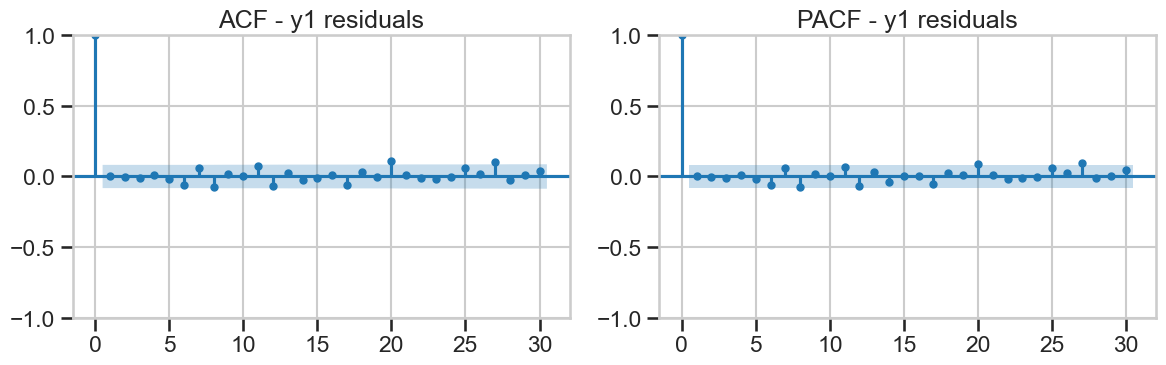

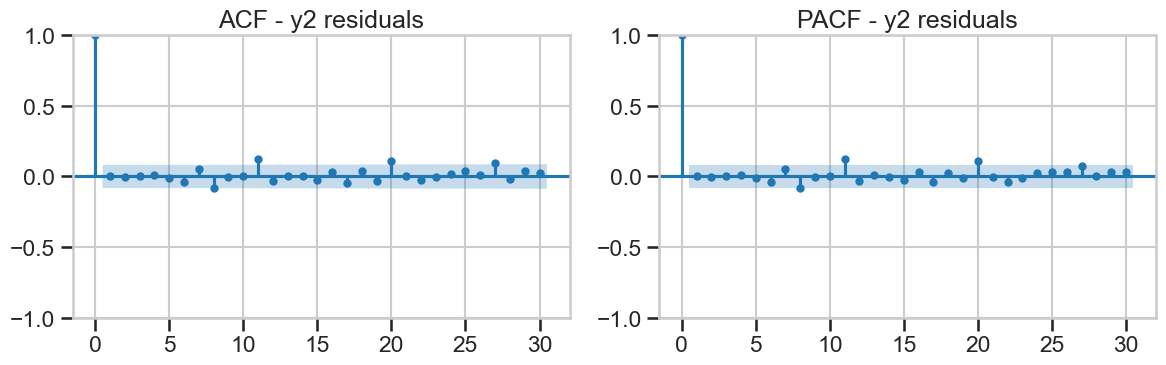

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

for i, col in enumerate(['y1','y2']):
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    plot_acf(var_results.resid[:,i], lags=30, ax=axes[0])
    axes[0].set_title(f'ACF - {col} residuals')
    plot_pacf(var_results.resid[:,i], lags=30, ax=axes[1])
    axes[1].set_title(f'PACF - {col} residuals')
    plt.tight_layout()
    plt.show()

#### VAR(7) Model Summary

---

**Model Form:**

$$
Y_t = c + \sum_{i=1}^{7} A_i Y_{t-i} + \varepsilon_t
$$

where:

$$ Y_t = \begin{bmatrix} y1_t \\ y2_t \end{bmatrix} $$

$$ A_i = \text{coefficient matrix for lag } i $$

$$ c = \text{constant vector} $$

$$ \varepsilon_t = \text{error terms} $$

---

**Model Fit:**

- AIC = -3.246  
- BIC = -3.024  
- Log Likelihood = -690.35  
- $$ \det(\Sigma_u) = 0.037 $$

**Comment:**  
Overall fit is acceptable. Low AIC/BIC suggests good balance of model complexity vs data size ($N=593$).

---

#### Dynamics in Equation for $y1$:

**Significant Lags:**

- $L1.y1$, $L2.y1$, $L3.y1$, $L4.y1$ → highly significant.
- Lags of $y2$ mostly insignificant (highest $p=0.055$ on $L2.y2$).

**Equation:**

$$
y1_t = c_1 + \sum_{i=1}^{7} a_i^{11} y1_{t-i} + \sum_{i=1}^{7} a_i^{12} y2_{t-i} + \varepsilon_{1t}
$$

**Interpretation:**

$y1$ is primarily driven by its own past → **strong autoregressive structure**.  
Influence from $y2$ is weak.

---

#### Dynamics in Equation for $y2$:

**Significant Lags:**

- $L1.y1$, $L2.y1$, $L3.y1$, $L4.y1$ → highly significant → cross-variable influence.
- $L2.y2$ also significant.

**Equation:**

$$
y2_t = c_2 + \sum_{i=1}^{7} a_i^{21} y1_{t-i} + \sum_{i=1}^{7} a_i^{22} y2_{t-i} + \varepsilon_{2t}
$$

**Interpretation:**

$y2$ is strongly influenced by lagged $y1$.  
Own dynamics of $y2$ are weaker beyond $L2.y2$.

---

**Constant Terms:**

- $c_1 = -49.90$, not significant $(p = 0.202)$.
- $c_2 = +48.49$, significant $(p = 0.020)$.

**Comment:**  
Constant in $y2$ equation suggests **mean shift or trend** in $y2$.  
No strong constant needed in $y1$.

---

#### Residual Covariance Matrix $\Sigma_u$:

$$
\Sigma_u =
\begin{bmatrix}
0.9643 & 0.4792 \\
0.4792 & 0.2748 \\
\end{bmatrix}
$$

- Correlation between residuals: $\rho \approx 0.93$ → **moderately high** → expected due to cointegration / joint dynamics.

---

#### Overall Interpretation:

- One variable (**$y1$**) is strongly autoregressive.
- Other variable (**$y2$**) is primarily reacting to lags of $y1$.
- System is stable, no signs of explosive behavior.

---

#### Model Improvement Suggestions:

- Many higher-order lags are insignificant → model is **likely overparameterized** but reducing lag introduces autocorrelations in the residual.
- Try fitting VAR(4) — AIC/BIC may improve.
- Regularization (Ridge, Lasso) can help shrink irrelevant terms.
- Consider using VECM form instead — we know there is **cointegration**.

---

#### Summary:

- VAR(7) works, but can be **simplified**.
- $y1$ → strong own memory.
- $y2$ → mostly driven by $y1$.
- Model is interpretable and fits economic intuition.

### Impulse Response Functions (IRF)

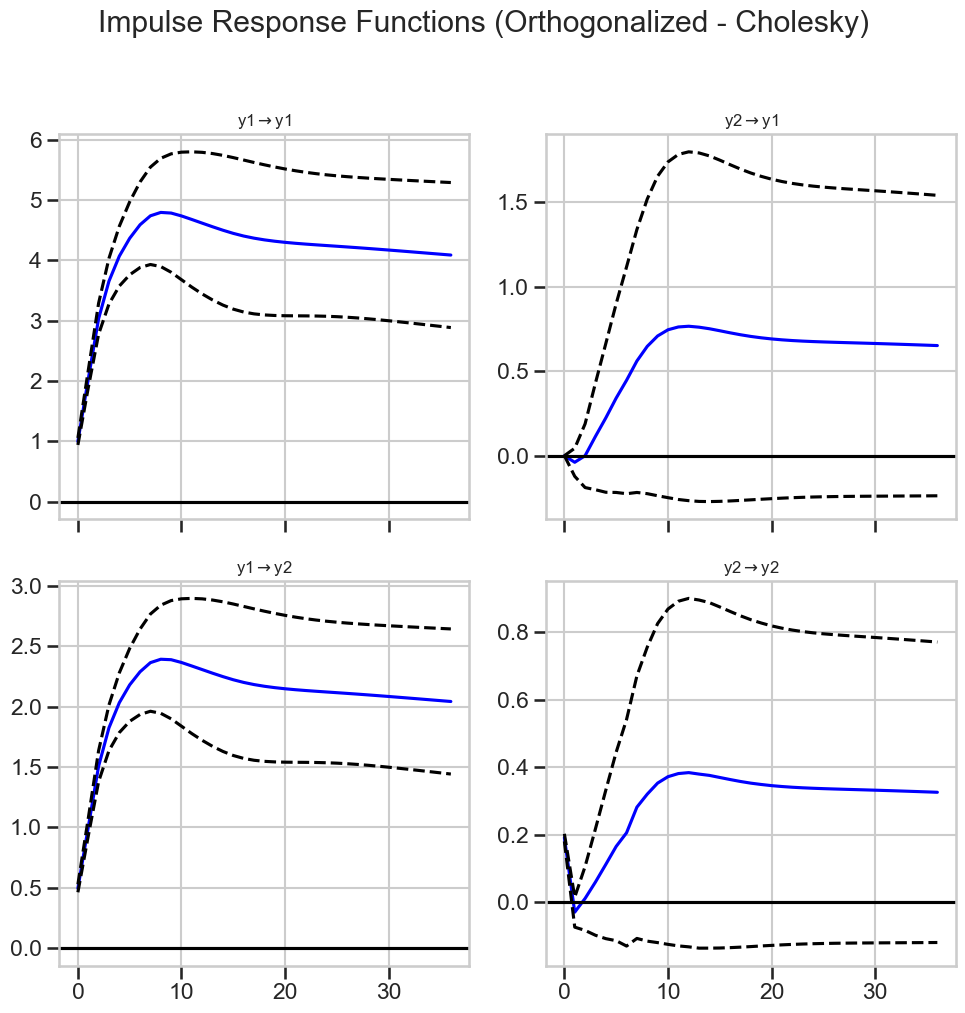

In [21]:
# Calculate and plot IRFs
irf = var_results.irf(periods=36)

# Orthogonalized IRFs (using Cholesky decomposition by default)
irf.plot(orth=True)
plt.suptitle('Impulse Response Functions (Orthogonalized - Cholesky)', y=1.02)
plt.tight_layout()
plt.show()

Impulse Response Function (Orthogonalized - Cholesky) – Interpretation

**Panel y1 → y1:**

- $y_1$ responds strongly to its own orthogonal shock → peak $\sim 4.5$.
- Response decays very slowly → high persistence.
- Indicates $y_1$ has a strong internal dynamic component.

**Panel y2 → y1:**

- Orthogonal $y_2$ shock causes only a modest effect on $y_1$ → peak $\sim 0.5$.
- Effect is short-lived → stabilizes quickly.
- Suggests limited pure causal influence of $y_2$ on $y_1$.

**Panel y1 → y2:**

- $y_2$ responds significantly to orthogonal $y_1$ shock → peak $\sim 2.5$.
- Gradual decay to $\sim 2$.
- Indicates $y_1$ has a strong causal effect on $y_2$.

**Panel y2 → y2:**

- $y_2$ reacts moderately to its own orthogonal shock → peak $\sim 0.8$.
- Response decays quickly → much lower persistence than $y_1$.
- $y_2$ has more damped dynamics.

---

**Summary:**

- $y_1$ is the **dominant driver** in the system → its own shocks and influence on $y_2$ are large and persistent.
- $y_2$ has a more limited and short-lived impact, especially on $y_1$.
- System is **asymmetric** → $y_1$ leads $y_2$.
- Orthogonalization reveals the true causal structure → **most of the system’s long-term variation is driven by $y_1$**.

### Forecast Error Variance Decomposition (FEVD)

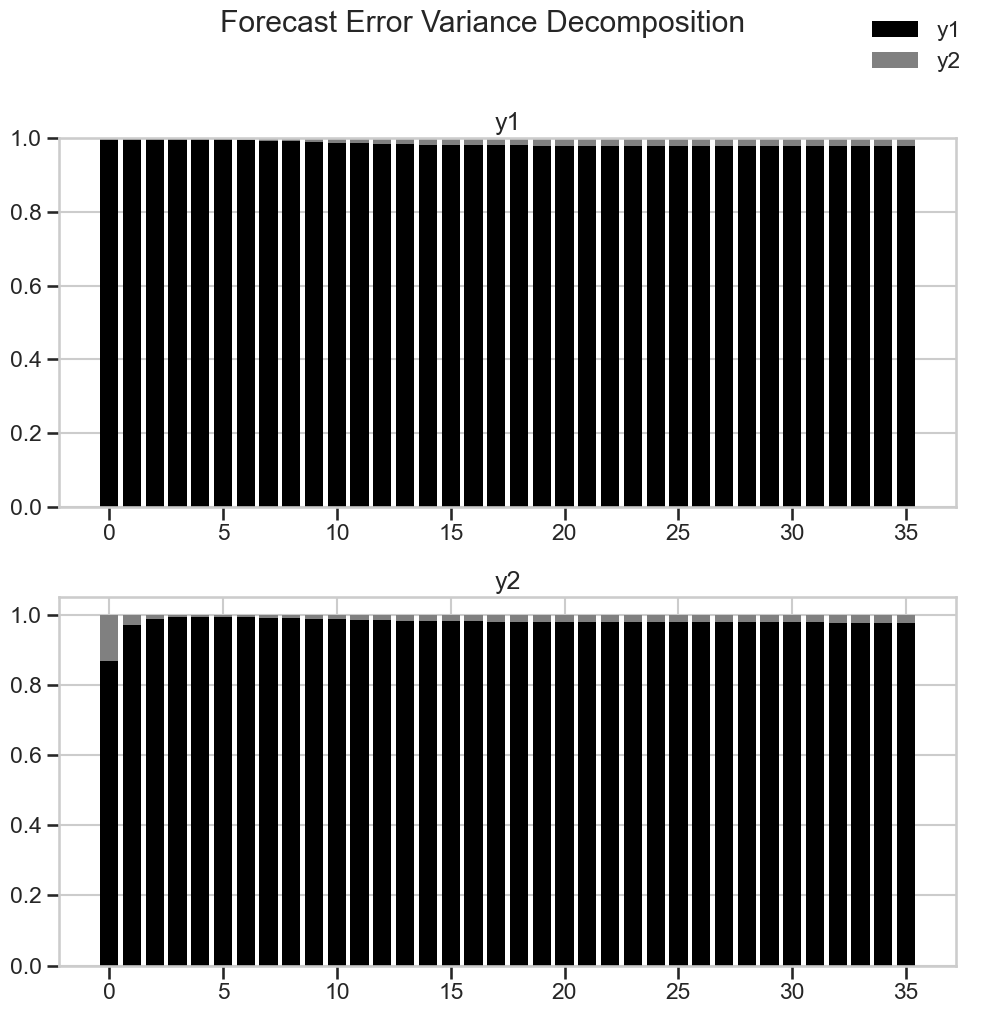

In [22]:

# Calculate and plot FEVD
fevd = var_results.fevd(periods=36)
fevd.plot()
plt.suptitle('Forecast Error Variance Decomposition', y=1.02)
plt.tight_layout()
plt.show()

# Print FEVD summary for the last period
#print("\nFEVD Summary (Period 36):")
#print(fevd.summary())

$ \text{Forecast Error Variance Decomposition (FEVD) – Interpretation} $

---

**y1:**

- Forecast error variance of $y_1$ is explained almost entirely (>99%) by its **own innovations** at all horizons.
- Shocks to $y_2$ contribute **negligibly** to $y_1$ variance.
- $y_1$ is **highly exogenous** → drives itself.

---

**y2:**

- At very short horizons (1-2 steps), $y_2$ variance has a small contribution (~10-15%) from $y_1$ shocks.
- However, after 3+ steps, $y_2$ variance is dominated (>95%) by **its own innovations**.
- $y_2$ is mostly driven by itself but shows **short-run sensitivity to $y_1$**.

---

**Summary:**

- The system exhibits **high degree of separability**:
    - $y_1$ is strongly self-driven and largely unaffected by $y_2$.
    - $y_2$ reacts somewhat to $y_1$ in the short run but becomes self-driven in the long run.
- Confirms the **asymmetry** seen in IRFs → $y_1$ leads system dynamics.

### Diagnostics

In [23]:
residuals = var_results.resid
# to DataFrame use value of  vecm_results.k_ar_diff + 1
residuals = pd.DataFrame(var_results.resid, columns=['x', 'y'], index=df_short.index[7:])
print("Residuals (first 5 rows):")
print(residuals.head())

# Test for serial correlation (Ljung-Box test on residuals)
# Apply to each residual series separately
print("\nLjung-Box Test for Serial Correlation in Residuals (lag=10):")
ljung_box_x = acorr_ljungbox(residuals['x'], lags=[10], return_df=True)
ljung_box_y = acorr_ljungbox(residuals['y'], lags=[10], return_df=True)
print("PPI Residuals:\n", ljung_box_x)
print("\nCPI Residuals:\n", ljung_box_y)

# Check p-values
alpha_serial = 0.05
print(f"\nConclusion at alpha={alpha_serial}:")
if ljung_box_x['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for x residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for x residuals.")
if ljung_box_y['lb_pvalue'].iloc[0] < alpha_serial:
    print(" - Reject H0 (no serial correlation) for y residuals.")
else:
    print(" - Cannot reject H0 (no serial correlation) for y residuals.")

Residuals (first 5 rows):
                 x       y
date                      
2023-09-16  0.0395  0.2488
2023-09-17  0.4678  0.2778
2023-09-18 -1.5815 -0.7757
2023-09-19 -0.1635  0.1105
2023-09-20 -0.7083 -0.5163

Ljung-Box Test for Serial Correlation in Residuals (lag=10):
PPI Residuals:
     lb_stat  lb_pvalue
10   7.4760     0.6799

CPI Residuals:
     lb_stat  lb_pvalue
10   6.5227     0.7696

Conclusion at alpha=0.05:
 - Cannot reject H0 (no serial correlation) for x residuals.
 - Cannot reject H0 (no serial correlation) for y residuals.


No serial auto correlation

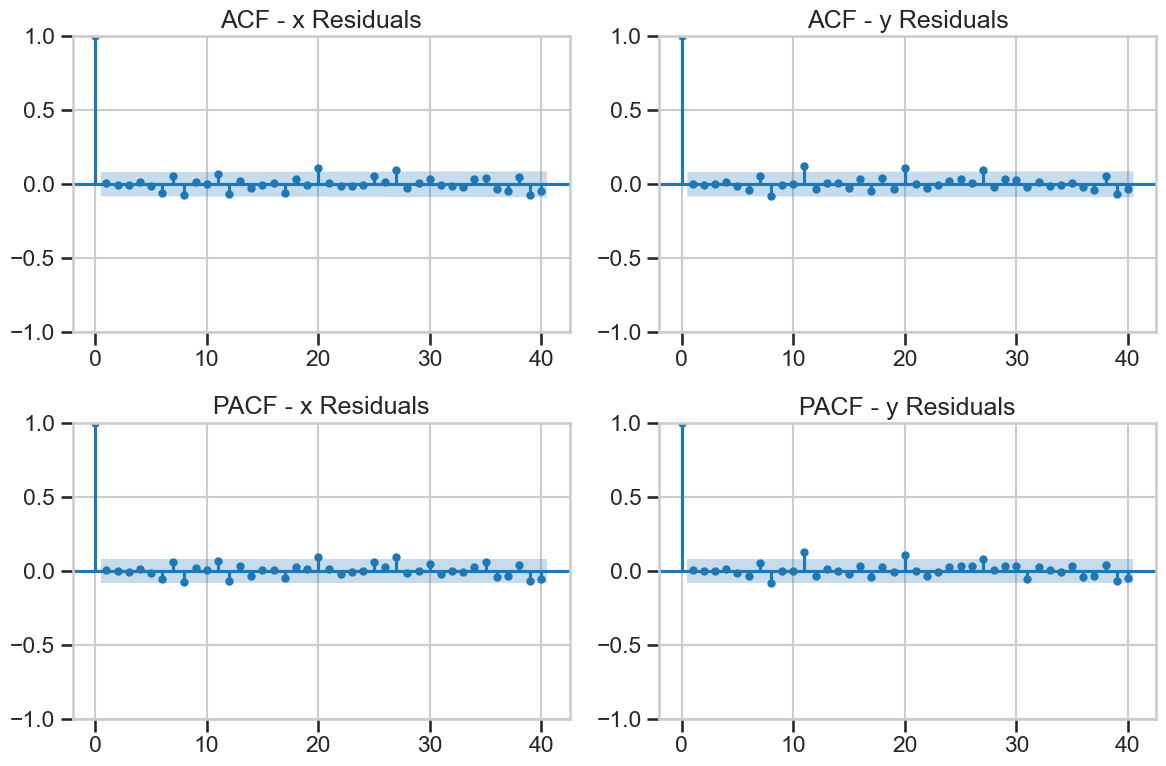

In [24]:
# Plot ACF and PACF of residuals
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_acf(residuals['x'], ax=axes[0, 0], title='ACF - x Residuals', lags=40)
plot_pacf(residuals['x'], ax=axes[1, 0], title='PACF - x Residuals', lags=40, method='ywm') # 'ols' method might fail if near non-stationarity
plot_acf(residuals['y'], ax=axes[0, 1], title='ACF - y Residuals', lags=40)
plot_pacf(residuals['y'], ax=axes[1, 1], title='PACF - y Residuals', lags=40, method='ywm')
plt.tight_layout()
plt.show()

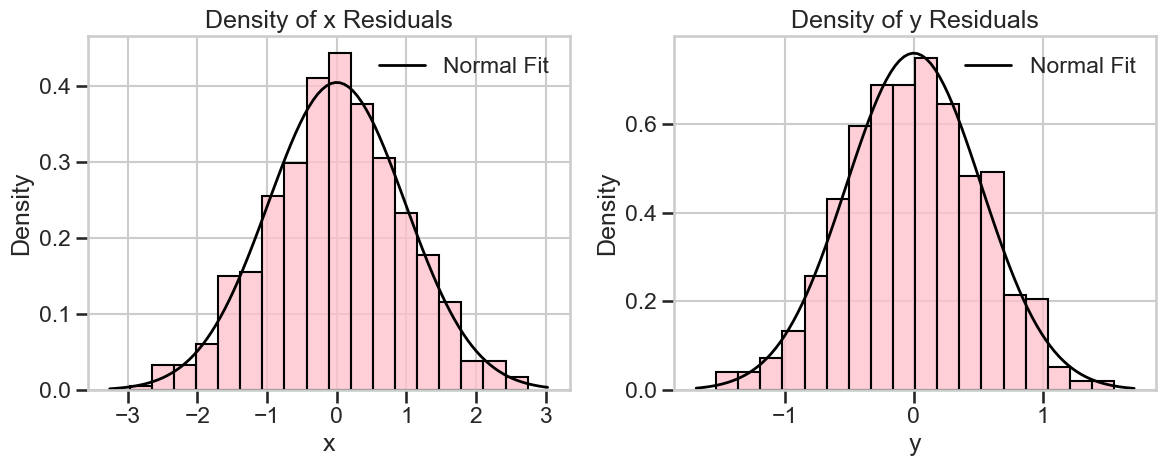

In [25]:
# Plot histograms of residuals with normal density overlay
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(residuals['x'], kde=False, stat='density', ax=axes[0], color='pink', edgecolor='black')
axes[0].set_title('Density of x Residuals')
# Overlay normal distribution
mu_x, std_x = residuals['x'].mean(), residuals['x'].std()
xmin_x, xmax_x = axes[0].get_xlim()
x_x = np.linspace(xmin_x, xmax_x, 100)
p_x = norm.pdf(x_x, mu_x, std_x)
axes[0].plot(x_x, p_x, 'k', linewidth=2, label='Normal Fit')
axes[0].legend()

sns.histplot(residuals['y'], kde=False, stat='density', ax=axes[1], color='pink', edgecolor='black')
axes[1].set_title('Density of y Residuals')
# Overlay normal distribution
mu_y, std_y = residuals['y'].mean(), residuals['y'].std()
xmin_y, xmax_y = axes[1].get_xlim()
x_y = np.linspace(xmin_y, xmax_y, 100)
p_y = norm.pdf(x_y, mu_y, std_y)
axes[1].plot(x_y, p_y, 'k', linewidth=2, label='Normal Fit')
axes[1].legend()

plt.tight_layout()
plt.show()

In [26]:
# Test for normality (Jarque-Bera test)
jb_x_stat, jb_x_pval, _, _ = jarque_bera(residuals['x'])
jb_y_stat, jb_y_pval, _, _ = jarque_bera(residuals['y'])

print("\nJarque-Bera Normality Test for Residuals:")
print(f"X Residuals: Statistic={jb_x_stat:.3f}, p-value={jb_x_pval:.3f}")
print(f"Y Residuals: Statistic={jb_y_stat:.3f}, p-value={jb_y_pval:.3f}")

alpha_norm = 0.05
print(f"\nConclusion at alpha={alpha_norm}:")
if jb_x_pval < alpha_norm:
    print(" - Reject normality for X residuals.")
else:
    print(" - Cannot reject normality for X residuals.")
if jb_y_pval < alpha_norm:
    print(" - Reject normality for Y residuals.")
else:
    print(" - Cannot reject normality for Y residuals.")

# Multivariate Normality Test (using VECMResults method)
try:
    normality_test_results = vecm_results.test_normality()
    print("\nMultivariate Normality Test Results (using VECMResults method):")
    print(normality_test_results)
except Exception as e:
    print(f"\nCould not run multivariate normality test directly: {e}")



Jarque-Bera Normality Test for Residuals:
X Residuals: Statistic=0.576, p-value=0.750
Y Residuals: Statistic=0.737, p-value=0.692

Conclusion at alpha=0.05:
 - Cannot reject normality for X residuals.
 - Cannot reject normality for Y residuals.

Multivariate Normality Test Results (using VECMResults method):
<statsmodels.tsa.vector_ar.hypothesis_test_results.NormalityTestResults object. H_0: data generated by normally-distributed process: fail to reject at 5% significance level. Test statistic: 2.255, critical value: 9.488>, p-value: 0.689>


Residuals are normal.

### Forecasting

In [27]:
# train = data_pair.iloc[:575]
# test = data_pair.iloc[575:]

var_results.k_ar

7

In [28]:
# var_model_train = VAR(train.values)
# var_results_train = var_model_train.fit(7)   # if fitting fresh

# # Generate forecasts
# forecast_obj = var_results_train.forecast_interval(
#     train.values[-var_results_train.k_ar:], steps=25, alpha=0.05
# )



# Generate forecasts
forecast_obj = var_results.forecast_interval(
    data_pair.values[-var_results.k_ar:], steps=25, alpha=0.05
)


# Unpack forecast
forecast_mean, lower_bound, upper_bound = forecast_obj

# Create forecast DataFrame
# forecast_index = data_pair.tail(25).index
forecast_index = df_oos.index
forecast_df = pd.DataFrame(forecast_mean, index=forecast_index, columns=['vecm_x_fore', 'vecm_y_fore'])

In [31]:
display(forecast_df)

vecm_x_fore  vecm_y_fore
date                                
2025-04-06     212.6589     176.0558
2025-04-07     212.7057     176.0803
2025-04-08     213.1790     176.2815
2025-04-09     213.7874     176.5718
2025-04-10     214.4940     176.9586
2025-04-11     215.2287     177.3118
2025-04-12     215.9657     177.6990
2025-04-13     216.6009     178.0124
2025-04-14     217.1025     178.2679
2025-04-15     217.4751     178.4550
2025-04-16     217.7498     178.5899
2025-04-17     217.9618     178.6972
2025-04-18     218.1262     178.7777
2025-04-19     218.2574     178.8443
2025-04-20     218.3645     178.8979
2025-04-21     218.4588     178.9456
2025-04-22     218.5493     178.9913
2025-04-23     218.6409     179.0372
2025-04-24     218.7364     179.0853
2025-04-25     218.8364     179.1353
2025-04-26     218.9413     179.1878
2025-04-27     219.0509     179.2426
2025-04-28     219.1650     179.2996
2025-04-29     219.2825     179.3583
2025-04-30     219.4026     179.4183

In [32]:
# Create forecast interval DataFrames
forecast_lower = pd.DataFrame(lower_bound, index=forecast_index, columns=['vecm_x_lower', 'vecm_y_lower'])
forecast_upper = pd.DataFrame(upper_bound, index=forecast_index, columns=['vecm_x_upper', 'vecm_y_upper'])

# Combine forecasts and intervals
forecast_combined = pd.concat([df_oos['y1'],df_oos['y4'], forecast_df, forecast_lower, forecast_upper], axis=1)
print("\nForecasts and Confidence Intervals:")
print(forecast_combined.head())


Forecasts and Confidence Intervals:
                 y1       y4  vecm_x_fore  vecm_y_fore  vecm_x_lower  \
date                                                                   
2025-04-06 213.3000 176.5900     212.6589     176.0558      210.7048   
2025-04-07 212.7900 176.2700     212.7057     176.0803      208.2721   
2025-04-08 213.0100 176.4200     213.1790     176.2815      205.7644   
2025-04-09 213.8900 176.2000     213.7874     176.5718      203.4747   
2025-04-10 215.6600 177.7500     214.4940     176.9586      201.4488   

            vecm_y_lower  vecm_x_upper  vecm_y_upper  
date                                                  
2025-04-06      175.0139      214.6129      177.0978  
2025-04-07      173.8571      217.1393      178.3035  
2025-04-08      172.5825      220.5937      179.9806  
2025-04-09      171.4234      224.1002      181.7202  
2025-04-10      170.4431      227.5393      183.4740  


In [33]:
# df_merged.tail(20)
final_df = pd.concat([df_short[['y1','y4']], forecast_combined], axis=0)
final_df
# df_short['y4']

y1       y4  vecm_x_fore  vecm_y_fore  vecm_x_lower  \
date                                                                   
2023-09-09 109.4100 124.2400          NaN          NaN           NaN   
2023-09-10 109.4100 124.2100          NaN          NaN           NaN   
2023-09-11 109.4200 124.4100          NaN          NaN           NaN   
2023-09-12 108.6800 123.9300          NaN          NaN           NaN   
2023-09-13 106.2100 122.6800          NaN          NaN           NaN   
...             ...      ...          ...          ...           ...   
2025-04-26 236.2500 187.4200     218.9413     179.1878      180.6796   
2025-04-27 235.2600 187.0900     219.0509     179.2426      179.8561   
2025-04-28 235.0700 187.4000     219.1650     179.2996      179.0645   
2025-04-29 234.9900 186.8800     219.2825     179.3583      178.3015   
2025-04-30 234.7000 186.7600     219.4026     179.4183      177.5644   

            vecm_y_lower  vecm_x_upper  vecm_y_upper  
date                                                  
2023-09-09           NaN           NaN           NaN  
2023-09-10           NaN           NaN           NaN  
2023-09-11           NaN           NaN           NaN  
2023-09-12           NaN           NaN           NaN  
2023-09-13           NaN           NaN           NaN  
...                  ...           ...           ...  
2025-04-26      160.0666      257.2029      198.3090  
2025-04-27      159.6545      258.2458      198.8307  
2025-04-28      159.2584      259.2654      199.3408  
2025-04-29      158.8766      260.2635      199.8400  
2025-04-30      158.5077      261.2408      200.3289  

[600 rows x 8 columns]

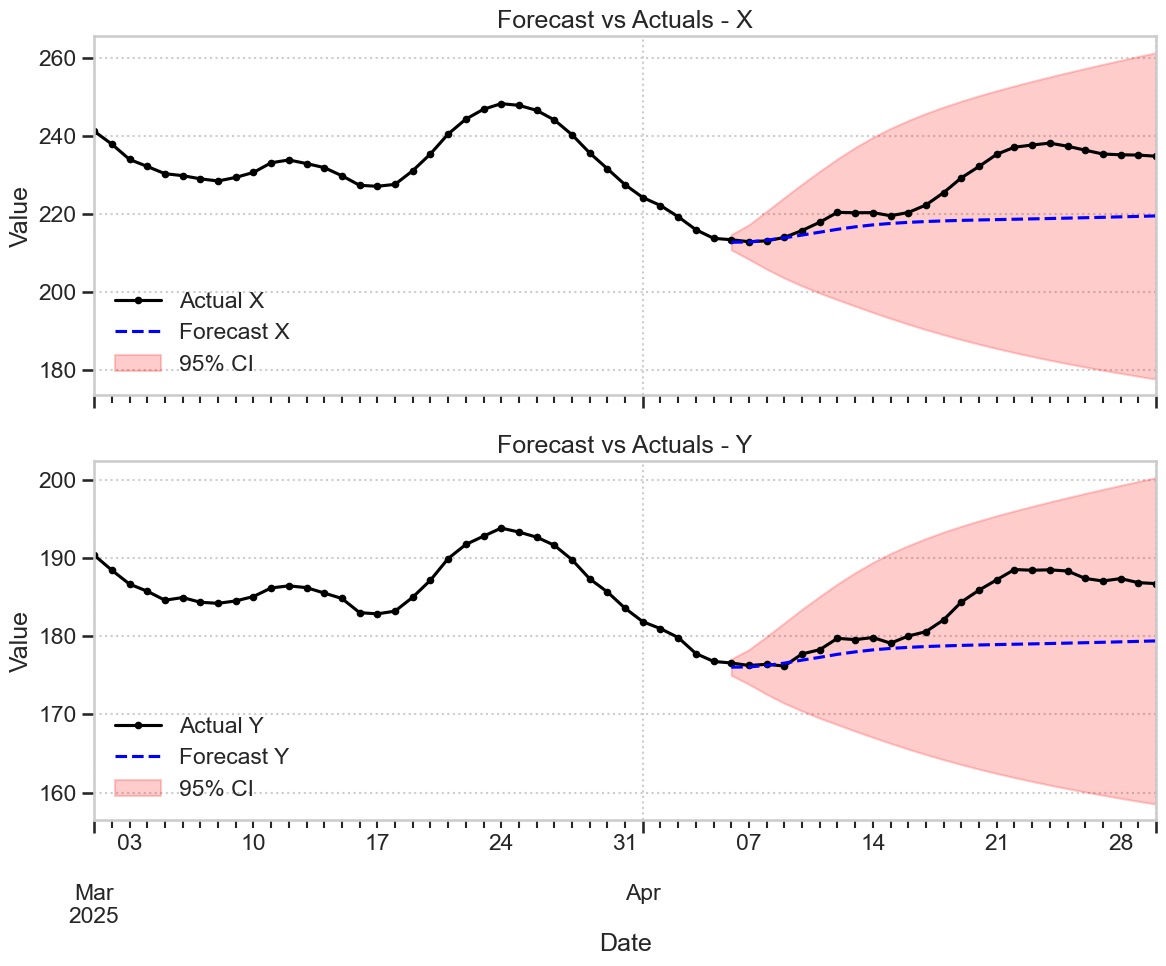

In [34]:
# Merge forecasts with the original data for plotting
# df_merged = df_short[['y1', 'y4']].merge(forecast_combined, left_index=True, right_index=True, how='left')
df_merged = pd.concat([df_short[['y1','y4']], forecast_combined], axis=0)


# Plot forecasts vs actuals
plot_start_date = '2025-03-01'#'2023-09-09'  # Adjust as needed

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# X Plot
df_merged.loc[plot_start_date:, 'y1'].plot(ax=axes[0], label='Actual X', color='black', marker='.')
df_merged.loc[plot_start_date:, 'vecm_x_fore'].plot(ax=axes[0], label='Forecast X', color='blue', linestyle='--')
axes[0].fill_between(df_merged.loc[plot_start_date:].index,  # Ensure index alignment
                     df_merged.loc[plot_start_date:, 'vecm_x_lower'],
                     df_merged.loc[plot_start_date:, 'vecm_x_upper'], color='red', alpha=0.2, label='95% CI')
axes[0].set_title('Forecast vs Actuals - X')
axes[0].set_ylabel('Value')
axes[0].legend()
axes[0].grid(True, linestyle=':')

# Y Plot
df_merged.loc[plot_start_date:, 'y4'].plot(ax=axes[1], label='Actual Y', color='black', marker='.')
df_merged.loc[plot_start_date:, 'vecm_y_fore'].plot(ax=axes[1], label='Forecast Y', color='blue', linestyle='--')
axes[1].fill_between(df_merged.loc[plot_start_date:].index,  # Ensure index alignment
                     df_merged.loc[plot_start_date:, 'vecm_y_lower'],
                     df_merged.loc[plot_start_date:, 'vecm_y_upper'], color='red', alpha=0.2, label='95% CI')
axes[1].set_title('Forecast vs Actuals - Y')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()

###  Forecast Evaluation

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
#To keep the forecast performance
performance_evaluation_matrics = {}

results_df = forecast_combined
results_df['x'] = df_merged.tail(25)['y1']
results_df['y'] = df_merged.tail(25)['y4']
# Define MAPE and AMAPE
def mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

def amape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / ((actual + forecast) / 2))) * 100

# Calculate metrics for x
mae_x = mean_absolute_error(results_df['x'], results_df['vecm_x_fore'])
rmse_x = np.sqrt(mean_squared_error(results_df['x'], results_df['vecm_x_fore']))
mape_x = mape(results_df['x'], results_df['vecm_x_fore'])
amape_x = amape(results_df['x'], results_df['vecm_x_fore'])

# Calculate metrics for y
mae_y = mean_absolute_error(results_df['y'], results_df['vecm_y_fore'])
rmse_y = np.sqrt(mean_squared_error(results_df['y'], results_df['vecm_y_fore']))
mape_y = mape(results_df['y'], results_df['vecm_y_fore'])
amape_y = amape(results_df['y'], results_df['vecm_y_fore'])

# Print results
print(f"\nForecast Accuracy:")
print(f"X: MAE={mae_x:.4f}, RMSE={rmse_x:.4f}, MAPE={mape_x:.2f}%, AMAPE={amape_x:.2f}%")
print(f"Y: MAE={mae_y:.4f}, RMSE={rmse_y:.4f}, MAPE={mape_y:.2f}%, AMAPE={amape_y:.2f}%")
performance_evaluation_matrics['vecm_mae_y1']=mae_x
performance_evaluation_matrics['vecm_rmse_y1']=rmse_x
performance_evaluation_matrics['vecm_mape_y1']=mape_x
performance_evaluation_matrics['vecm_amape_y1']=amape_x
performance_evaluation_matrics['vecm_mae_y4']=mae_y
performance_evaluation_matrics['vecm_rmse_y4']=rmse_y
performance_evaluation_matrics['vecm_mape_y4']=mape_y
performance_evaluation_matrics['vecm_amape_y4']=amape_y


Forecast Accuracy:
X: MAE=9.1487, RMSE=11.7061, MAPE=3.92%, AMAPE=4.05%
Y: MAE=4.5264, RMSE=5.7890, MAPE=2.43%, AMAPE=2.48%


**Forecast Accuracy Summary**

- **X:**
  - Mean Absolute Error (MAE): 9.15
  - Mean Squared Error (MSE): 137.03
  - Mean Absolute Percentage Error (MAPE): 3.92%
  - Adjusted MAPE (AMAPE): 4.05%

- **Y:**
  - Mean Absolute Error (MAE): 4.53
  - Mean Squared Error (MSE): 33.51
  - Mean Absolute Percentage Error (MAPE): 2.43%
  - Adjusted MAPE (AMAPE): 2.48%

**Interpretation:**
- Forecast errors are relatively low for both X and Y.
- Y shows slightly better forecast accuracy than X across all metrics (lower MAE, MSE, and MAPE).
- MAPE values under 5% suggest **good predictive performance** for both series.

## 6. ARIMA

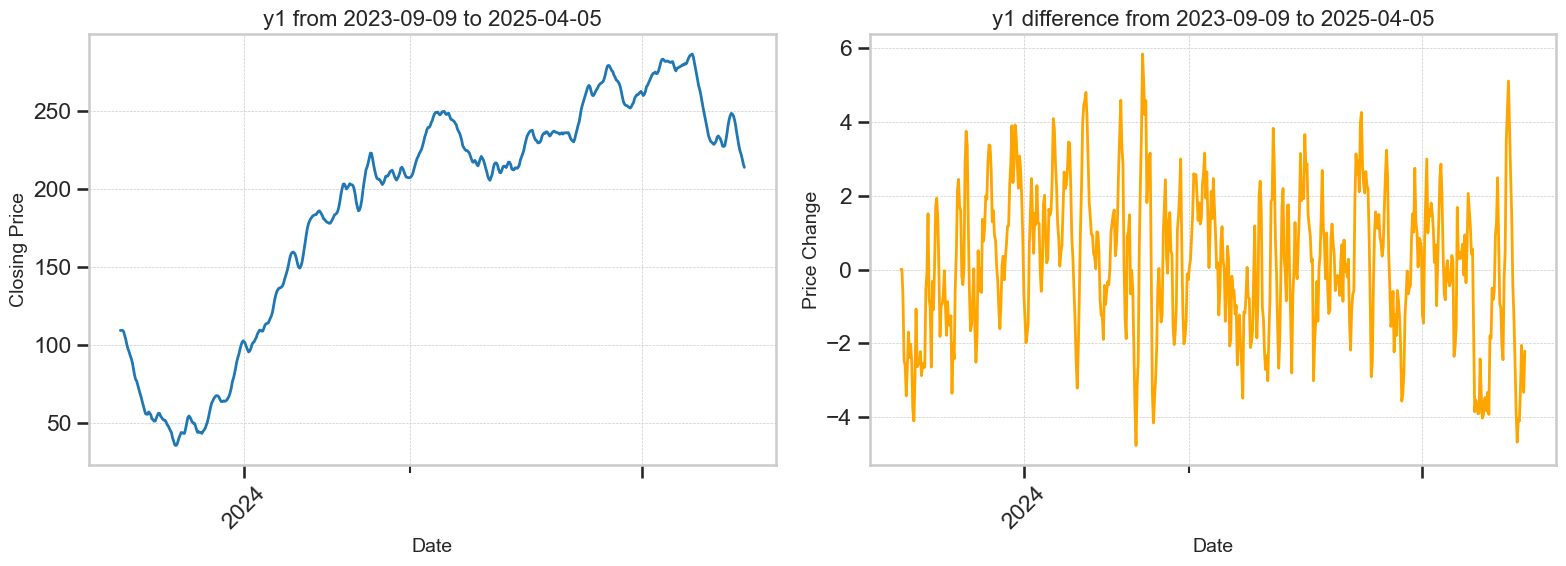

In [36]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

# --- FIRST PLOT: Closing Prices ---
axes[0].plot(df_short.index, df_short["y1"], linewidth=2)
axes[0].set_title("y1 from 2023-09-09 to 2025-04-05", fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Closing Price', fontsize=14)

# Formatting X-axis
axes[0].xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year
axes[0].xaxis.set_minor_locator(mdates.MonthLocator(6))  # Minor ticks every 6 months
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: str(int(mdates.num2date(x).year)) if int(mdates.num2date(x).year) % 2 == 0 else ""))
axes[0].tick_params(axis='x', rotation=45)  # Rotate labels for readability
axes[0].grid(visible=True, which='both', linestyle='--', linewidth=0.5)  # Add grid

# --- SECOND PLOT: First Differences ---
y1_diff = df_short["y1"].diff()  # Compute first differences

axes[1].plot(df_short.index, y1_diff, linewidth=2, color='orange')
axes[1].set_title("y1 difference from 2023-09-09 to 2025-04-05", fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('Price Change', fontsize=14)

# Formatting X-axis
axes[1].xaxis.set_major_locator(mdates.YearLocator(1))
axes[1].xaxis.set_minor_locator(mdates.MonthLocator(6))
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: str(int(mdates.num2date(x).year)) if int(mdates.num2date(x).year) % 2 == 0 else ""))
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

The series does not look like stationary. Still, it does not appear to include a drift or a deterministic trend. The differences also does not seem to be stationary as their variance is unstable.

### Box-Jenkins procedure - For Y1

In [37]:
adf_test(df_short["y1"].diff(), max_aug=20)

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                         0             -6.8433                  -2.5670   
1                         1             -8.4521                  -2.5670   
2                         2             -9.2249                  -2.5670   
3                         3             -7.3317                  -2.5670   
4                         4             -7.2724                  -2.5670   
5                         5             -7.6292                  -2.5670   
6                         6             -6.8047                  -2.5670   
7                         7             -6.8519                  -2.5670   
8                         8             -6.0987                  -2.5670   
9                         9             -6.1357                  -2.5670   
10                       10             -5.9656                  -2.5670   
11                       11             -6.1124                  -2.5670   
12                       12             -5.5069                  -2.5670   
13                       13             -5.4892                  -2.5670   
14                       14             -5.1862                  -2.5670   
15                       15             -5.0152                  -2.5670   
16                       16             -4.8196                  -2.5670   
17                       17             -4.3308                  -2.5670   
18                       18             -4.2518                  -2.5670   
19                       19             -4.2661                  -2.5670   

    ADF critival value (5%)  ADF critival value (10%)  \
0                   -1.9410                   -1.6160   
1                   -1.9410                   -1.6160   
2                   -1.9410                   -1.6160   
3                   -1.9410                   -1.6160   
4                   -1.9410                   -1.6160   
5                   -1.9410                   -1.6160   
6                   -1.9410                   -1.6160   
7                   -1.9410                   -1.6160   
8                   -1.9410                   -1.6160   
9                   -1.9410                   -1.6160   
10                  -1.9410                   -1.6160   
11                  -1.9410                   -1.6160   
12                  -1.9410                   -1.6160   
13                  -1.9410                   -1.6160   
14                  -1.9410                   -1.6160   
15                  -1.9410                   -1.6160   
16                  -1.9410                   -1.6160   
17                  -1.9410                   -1.6160   
18                  -1.9410                   -1.6160   
19                  -1.9410                   -1.6160   

    BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                       0.0000                       0.0000   
1                       0.0000                       0.0000   
2                       0.0003                       0.0005   
3                       0.1575                       0.1896   
4                       0.0249                       0.0496   
5                       0.1144                       0.3345   
6                       0.3423                       0.3021   
7                       0.2539                       0.0665   
8                       0.3054                       0.1596   
9                       0.1571                       0.3451   
10                      0.1042                       0.2465   
11                      0.1127                       0.1879   
12                      0.3751                       0.4304   
13                      0.1465                       0.1657   
14                      0.2044                       0.0866   
15                      0.4729                       0.6337   
16                      0.2472                       0.3763   
17                      0.8317                       0.5911   
18          

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                         0             -6.8433                  -2.5670   
1                         1             -8.4521                  -2.5670   
2                         2             -9.2249                  -2.5670   
3                         3             -7.3317                  -2.5670   
4                         4             -7.2724                  -2.5670   
5                         5             -7.6292                  -2.5670   
6                         6             -6.8047                  -2.5670   
7                         7             -6.8519                  -2.5670   
8                         8             -6.0987                  -2.5670   
9                         9             -6.1357                  -2.5670   
10                       10             -5.9656                  -2.5670   
11                       11             -6.1124                  -2.5670   
12                       12             -5.5069                  -2.5670   
13                       13             -5.4892                  -2.5670   
14                       14             -5.1862                  -2.5670   
15                       15             -5.0152                  -2.5670   
16                       16             -4.8196                  -2.5670   
17                       17             -4.3308                  -2.5670   
18                       18             -4.2518                  -2.5670   
19                       19             -4.2661                  -2.5670   

    ADF critival value (5%)  ADF critival value (10%)  \
0                   -1.9410                   -1.6160   
1                   -1.9410                   -1.6160   
2                   -1.9410                   -1.6160   
3                   -1.9410                   -1.6160   
4                   -1.9410                   -1.6160   
5                   -1.9410                   -1.6160   
6                   -1.9410                   -1.6160   
7                   -1.9410                   -1.6160   
8                   -1.9410                   -1.6160   
9                   -1.9410                   -1.6160   
10                  -1.9410                   -1.6160   
11                  -1.9410                   -1.6160   
12                  -1.9410                   -1.6160   
13                  -1.9410                   -1.6160   
14                  -1.9410                   -1.6160   
15                  -1.9410                   -1.6160   
16                  -1.9410                   -1.6160   
17                  -1.9410                   -1.6160   
18                  -1.9410                   -1.6160   
19                  -1.9410                   -1.6160   

    BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                       0.0000                       0.0000   
1                       0.0000                       0.0000   
2                       0.0003                       0.0005   
3                       0.1575                       0.1896   
4                       0.0249                       0.0496   
5                       0.1144                       0.3345   
6                       0.3423                       0.3021   
7                       0.2539                       0.0665   
8                       0.3054                       0.1596   
9                       0.1571                       0.3451   
10                      0.1042                       0.2465   
11                      0.1127                       0.1879   
12                      0.3751                       0.4304   
13                      0.1465                       0.1657   
14                      0.2044                       0.0866   
15                      0.4729                       0.6337   
16                      0.2472                       0.3763   
17                      0.8317                       0.5911   
18          

Assumming 1%-significance-level, one needs to use 3 augmentations to conclude that the series in non-stationary.
BG Test H0: No serieal autocorrelation (p>.05)

#### Initial identification of ARIMA orders

The series is ~ I(1). Therefore for ARIMA(p,d,q), d=1. Let us determine the initial values of p and q. For this purpose, we should consider ACF and PACF of the differences (as they are stationary).

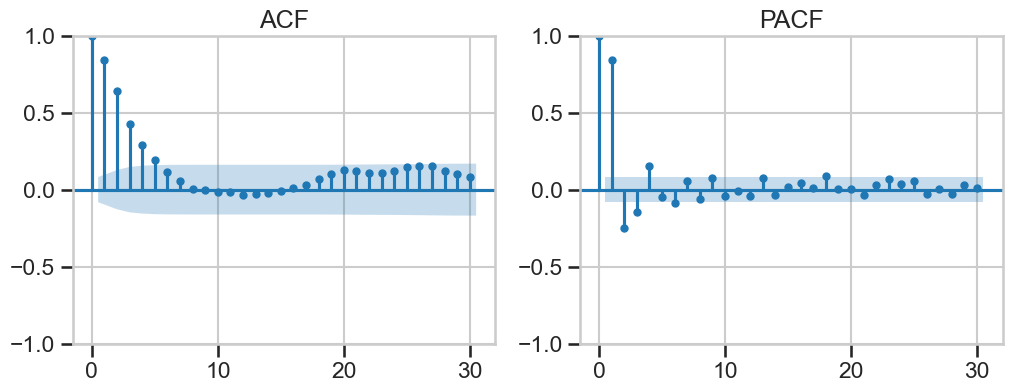

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(df_short["y1"].diff())[1:], lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")

# Partial autocorrelation plot
plot_pacf(np.array(df_short["y1"].diff())[1:], lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")

plt.show()

The ACF exhibits a sharp cutoff after '5' lags.
The PACF shows a more gradual decay. This pattern strongly suggests an MA(5) model.

Therefore, for our differenced time series data, the best model to start with would be an MA(5) model.





#### Model estimation

In [39]:
# Definition of ARIMA model
model = ARIMA(df_short["y1"].values, order=(0, 1, 5))  # p=0, d=1, q=2
y1_arima015_ = model.fit()
# Summary
print(y1_arima015_.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(0, 1, 5)   Log Likelihood                -814.297
Date:                Sat, 21 Jun 2025   AIC                           1640.595
Time:                        21:33:34   BIC                           1666.710
Sample:                             0   HQIC                          1650.781
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0605      0.044     24.290      0.000       0.975       1.146
ma.L2          1.0092      0.064     15.702      0.000       0.883       1.135
ma.L3          0.5935      0.070      8.487      0.0

#### Model diagnostics

Every time we obtain a model, we should test its residuals for autocorrelation. Similarily to Breusch-Godfrey test, trying different numbers of lags is highly recommended.

In [41]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y1_arima015_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
display(ljung_test)

lb_stat  lb_pvalue
5    0.1166     0.9998
10   0.2710     1.0000
15   0.6055     1.0000
20   0.9306     1.0000
25   1.1064     1.0000
30   1.5626     1.0000

Residuals are not autocorrelated when trying some numbers of lags. In case of autocorrelation, one should add more parameters to the model. Prominently, the ones suggested by ACF and PACF of the residuals.

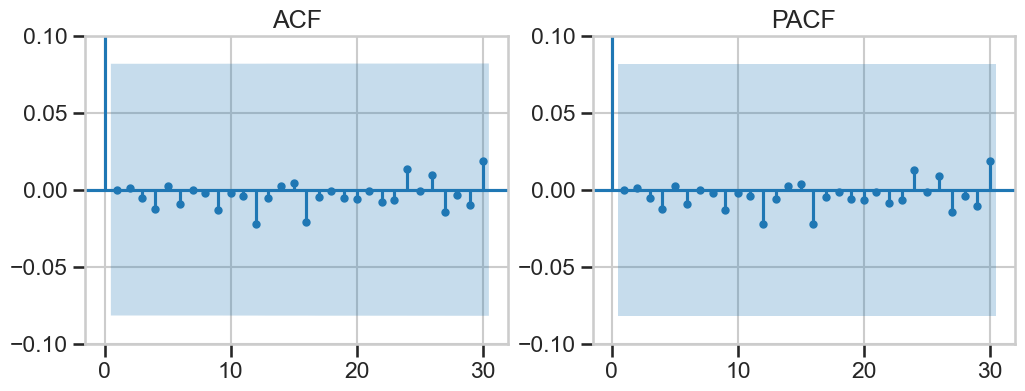

In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y1_arima015_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y1_arima015_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

#### Model refinement

Let us try ARIMA(0,1,16) without some of the intermediate lags of the dependent variable, i.e.

$$\Delta y_t = \alpha_5 \epsilon_{t-5} + \alpha_{13} \epsilon_{t-16} + \epsilon_t$$

In [43]:
# Definition of ARIMA model
model = ARIMA(df_short['y1'].values, order=(0, 1, [5,13]))

# Fitting the model
y1_arima0113_ = model.fit()
# arima1310_ = model.fit(start_params=[0.0, 0.1, 0.1])  # [const, ma.L1, ma.L2]


# Summary
print(y1_arima0113_.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  575
Model:             ARIMA(0, 1, [5, 13])   Log Likelihood               -1193.593
Date:                  Sat, 21 Jun 2025   AIC                           2393.185
Time:                          21:33:59   BIC                           2406.243
Sample:                               0   HQIC                          2398.279
                                  - 575                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L5          0.2099      0.039      5.355      0.000       0.133       0.287
ma.L13        -0.0212      0.043     -0.498      0.619      -0.105       0.062
sigma2         3.7456      0.237    

In [44]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y1_arima0113_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5   14.7741     0.0114
10  16.6232     0.0831
15  18.2193     0.2513
20  18.6747     0.5431
25  19.0269     0.7958
30  19.8626     0.9201


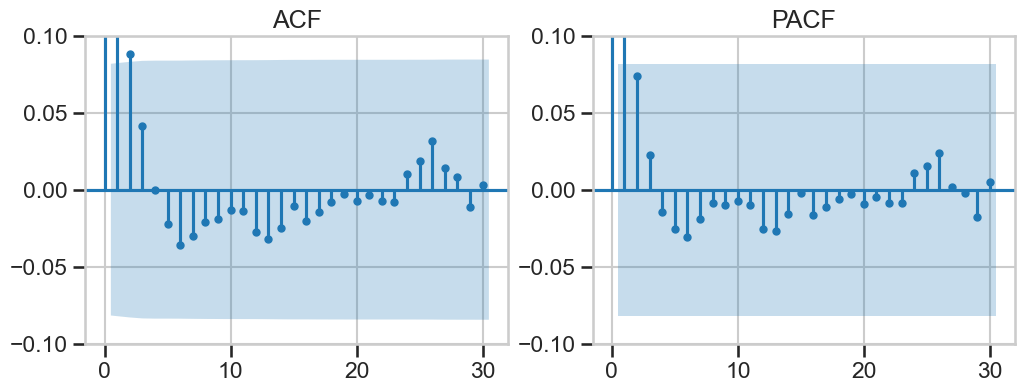

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y1_arima0113_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y1_arima0113_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [46]:
# Definition of ARIMA model
model = ARIMA(df_short['y1'].values, order=(0, 1, [5,20]))

# Fitting the model
y1_arima0120_5_ = model.fit()
# arima1310_ = model.fit(start_params=[0.0, 0.1, 0.1])  # [const, ma.L1, ma.L2]


# Summary
print(y1_arima0120_5_.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  575
Model:             ARIMA(0, 1, [5, 20])   Log Likelihood               -1189.783
Date:                  Sat, 21 Jun 2025   AIC                           2385.565
Time:                          21:34:05   BIC                           2398.623
Sample:                               0   HQIC                          2390.659
                                  - 575                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L5          0.1832      0.038      4.861      0.000       0.109       0.257
ma.L20         0.1513      0.043      3.538      0.000       0.067       0.235
sigma2         3.6935      0.233    

In [47]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y1_arima0120_5_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5   14.6820     0.0118
10  16.7031     0.0812
15  18.8443     0.2209
20  20.0445     0.4551
25  20.9061     0.6978
30  22.1365     0.8490


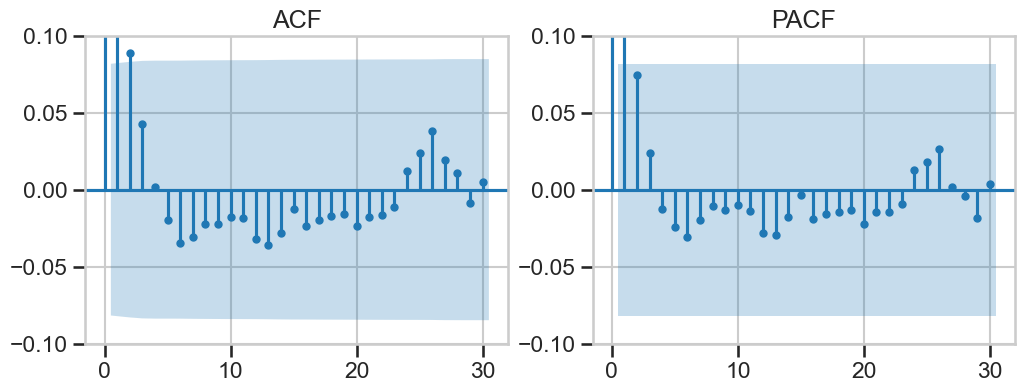

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y1_arima0120_5_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y1_arima0120_5_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [49]:
# Definition of ARIMA model
model = ARIMA(df_short['y1'].values, order=(0, 1, [5, 20, 25]))

# Fitting the model
y1_arima0125_20_ = model.fit()

# Summary
print(y1_arima0125_20_.summary())

                                  SARIMAX Results                                   
Dep. Variable:                            y   No. Observations:                  575
Model:             ARIMA(0, 1, [5, 20, 25])   Log Likelihood               -1184.936
Date:                      Sat, 21 Jun 2025   AIC                           2377.873
Time:                              21:34:09   BIC                           2395.283
Sample:                                   0   HQIC                          2384.664
                                      - 575                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L5          0.1816      0.040      4.515      0.000       0.103       0.260
ma.L20         0.1522      0.042      3.602      0.000       0.069       0.235
ma.L

In [50]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y1_arima0125_20_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5   14.1889     0.0145
10  16.3470     0.0901
15  18.2055     0.2520
20  19.3297     0.5005
25  20.2451     0.7339
30  20.7584     0.8953


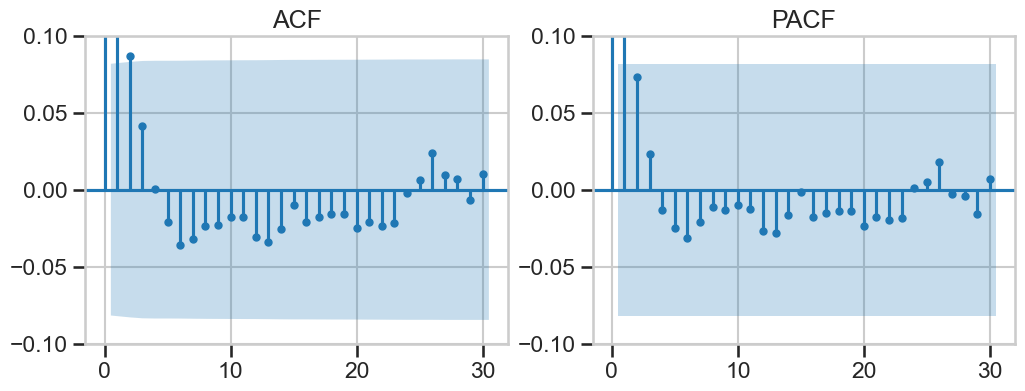

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y1_arima0125_20_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y1_arima0125_20_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [52]:
# Definition of ARIMA model
model = ARIMA(df_short['y1'].values, order=(0, 1, [5, 20, 27]))

# Fitting the model
y1_arima0127_20_ = model.fit()

# Summary
print(y1_arima0127_20_.summary())

                                  SARIMAX Results                                   
Dep. Variable:                            y   No. Observations:                  575
Model:             ARIMA(0, 1, [5, 20, 27])   Log Likelihood               -1184.419
Date:                      Sat, 21 Jun 2025   AIC                           2376.838
Time:                              21:34:12   BIC                           2394.249
Sample:                                   0   HQIC                          2383.629
                                      - 575                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L5          0.1704      0.038      4.438      0.000       0.095       0.246
ma.L20         0.1641      0.042      3.893      0.000       0.081       0.247
ma.L

In [53]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y1_arima0127_20_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5   14.1197     0.0149
10  16.1837     0.0945
15  17.9849     0.2635
20  19.3300     0.5005
25  19.9661     0.7486
30  20.5070     0.9027


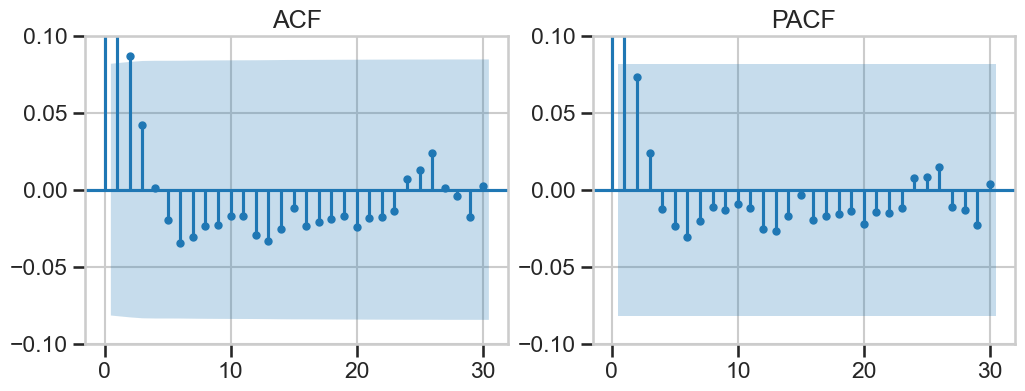

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y1_arima0127_20_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y1_arima0127_20_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

#### Other possible ARIMA model specification

Other optons we can start from MA[3]

In [55]:
# Definition of ARIMA model
model = ARIMA(df_short["y1"].values, order=(0, 1, 3))  # p=0, d=1, q=2
y1_arima013_ = model.fit()
# Summary
print(y1_arima013_.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -835.237
Date:                Sat, 21 Jun 2025   AIC                           1678.474
Time:                        21:34:29   BIC                           1695.884
Sample:                             0   HQIC                          1685.265
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          1.0254      0.040     25.397      0.000       0.946       1.104
ma.L2          0.8332      0.046     18.017      0.000       0.743       0.924
ma.L3          0.3103      0.038      8.136      0.0

In [56]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y1_arima013_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.0850     0.9999
10   0.3235     1.0000
15   0.7341     1.0000
20   1.1719     1.0000
25   1.3632     1.0000
30   1.7605     1.0000


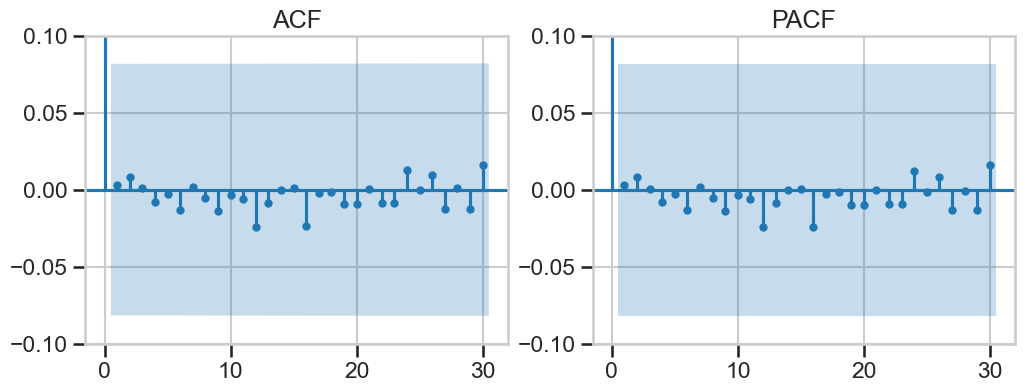

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y1_arima013_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y1_arima013_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [58]:
# we can think to add lag 20 as well 
# Definition of ARIMA model
model = ARIMA(df_short["y1"].values, order=(0, 1, [3,20]))  # p=0, d=1, q=2
y1_arima0120_ = model.fit()
# arima210_ = model.fit(start_params=[0.0, 0.1, 0.1])  # [const, ma.L1, ma.L2]
# Summary
print(y1_arima0120_.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  575
Model:             ARIMA(0, 1, [3, 20])   Log Likelihood               -1144.098
Date:                  Sat, 21 Jun 2025   AIC                           2294.195
Time:                          21:34:39   BIC                           2307.253
Sample:                               0   HQIC                          2299.289
                                  - 575                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L3          0.4130      0.038     10.774      0.000       0.338       0.488
ma.L20         0.1482      0.040      3.730      0.000       0.070       0.226
sigma2         3.1474      0.218    

In [59]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y1_arima0120_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    6.9615     0.2235
10   7.4841     0.6791
15   9.1663     0.8687
20  10.0727     0.9668
25  10.5899     0.9947
30  11.4920     0.9991


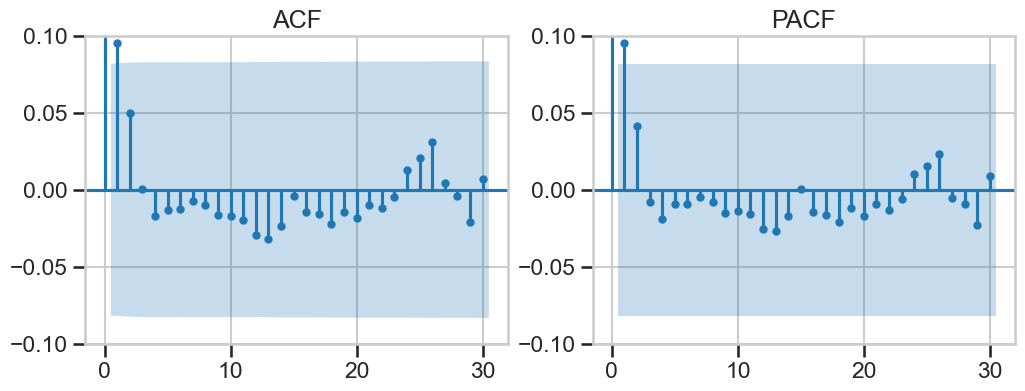

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y1_arima0120_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y1_arima0120_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [63]:
# Now we can give some assumption to AR part AR(3)
# Definition of ARIMA model
model = ARIMA(df_short['y1'].values, order=(3, 1, 0))

# Fitting the model
y1_arima310_ = model.fit()
# arima1310_ = model.fit(start_params=[0.0, 0.1, 0.1])  # [const, ma.L1, ma.L2]


# Summary
print(y1_arima310_.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -821.134
Date:                Sat, 21 Jun 2025   AIC                           1650.268
Time:                        21:34:59   BIC                           1667.679
Sample:                             0   HQIC                          1657.059
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0168      0.043     23.814      0.000       0.933       1.100
ar.L2         -0.0901      0.062     -1.446      0.148      -0.212       0.032
ar.L3         -0.1463      0.043     -3.424      0.0

In [64]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y1_arima310_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.2239     0.9988
10   0.3655     1.0000
15   0.6820     1.0000
20   0.9940     1.0000
25   1.1375     1.0000
30   1.7285     1.0000


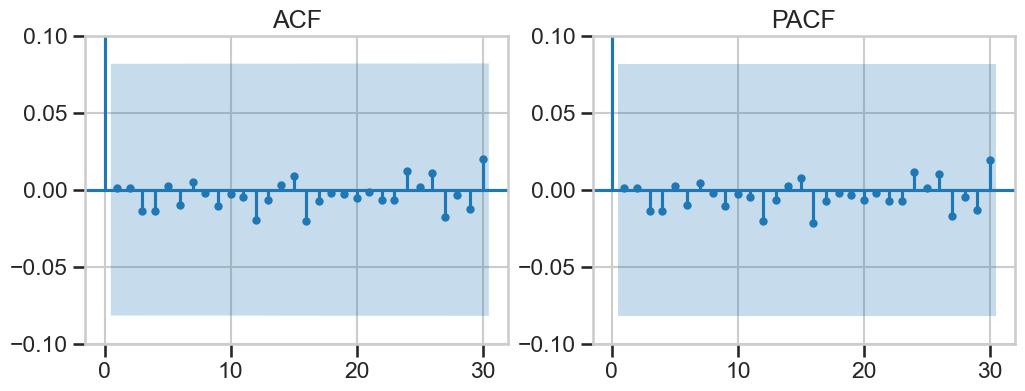

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y1_arima310_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y1_arima310_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [66]:
# Now we can give some assumption to AR part AR(3)
# Definition of ARIMA model
model = ARIMA(df_short['y1'].values, order=([3, 14, 17], 1, 0))

# Fitting the model
y1_arima3_14_17_10_ = model.fit()
# arima1310_ = model.fit(start_params=[0.0, 0.1, 0.1])  # [const, ma.L1, ma.L2]


# Summary
print(y1_arima3_14_17_10_.summary())

                                  SARIMAX Results                                   
Dep. Variable:                            y   No. Observations:                  575
Model:             ARIMA([3, 14, 17], 1, 0)   Log Likelihood                  -5.452
Date:                      Sat, 21 Jun 2025   AIC                             18.903
Time:                              21:35:06   BIC                             36.314
Sample:                                   0   HQIC                            25.694
                                      - 575                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L3          2.6776      0.102     26.356      0.000       2.478       2.877
ar.L14        -2.4663      0.103    -23.985      0.000      -2.668      -2.265
ar.L

In [67]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y1_arima3_14_17_10_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5  204.5960     0.0000
10 218.8422     0.0000
15 219.3115     0.0000
20 219.3212     0.0000
25 219.3219     0.0000
30 219.3219     0.0000


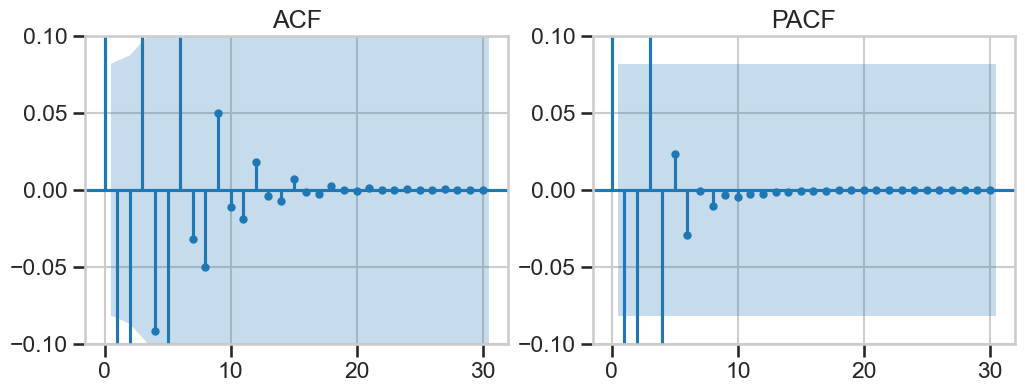

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y1_arima3_14_17_10_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y1_arima3_14_17_10_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [69]:
# Now we can give some assumption to AR part AR(3)
# Definition of ARIMA model
model = ARIMA(df_short['y1'].values, order=([3], 1, [20, 25]))

# Fitting the model
y1_arima3_1_20_25 = model.fit()
# arima1310_ = model.fit(start_params=[0.0, 0.1, 0.1])  # [const, ma.L1, ma.L2]


# Summary
print(y1_arima3_1_20_25.summary())

                                  SARIMAX Results                                  
Dep. Variable:                           y   No. Observations:                  575
Model:             ARIMA([3], 1, [20, 25])   Log Likelihood               -1138.305
Date:                     Sat, 21 Jun 2025   AIC                           2284.610
Time:                             21:35:12   BIC                           2302.021
Sample:                                  0   HQIC                          2291.401
                                     - 575                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L3          0.4209      0.040     10.547      0.000       0.343       0.499
ma.L20         0.1495      0.043      3.497      0.000       0.066       0.233
ma.L25      

In [70]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y1_arima3_1_20_25.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    7.5279     0.1842
10   8.9445     0.5374
15  10.2483     0.8038
20  10.8003     0.9512
25  11.3259     0.9912
30  12.0615     0.9985


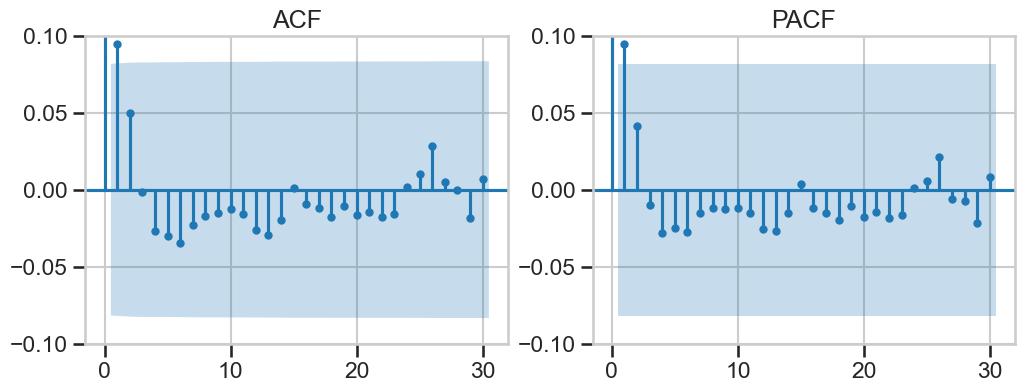

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y1_arima3_1_20_25.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y1_arima3_1_20_25.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

#### Forecasting with ARIMA model

**Choosing the best model**

The best model can be chosen with different criteria. Still, usually the choice is based on the information criteria, e.g. AIC, BIC. The lower they are, the better the model (see lecture slides).

In [72]:
models = [y1_arima015_, y1_arima0113_, y1_arima0120_5_, y1_arima0125_20_, y1_arima0127_20_, y1_arima013_, y1_arima0120_, y1_arima310_, y1_arima3_1_20_25] # list with all the models
names = ['y1_arima015_', 'y1_arima0113_', 'y1_arima0120_5_', 'y1_arima0125_20_', 'y1_arima0127_20_', 'y1_arima013_', 'y1_arima0120_', 'y1_arima310_', 'y1_arima3_1_20_25'] # models' names

# Preparing a DataFrame with models sorted by AIC, BIC
results = []
for model, name in zip(models, names):
    results.append([name, round(model.aic,2), round(model.bic,2)])
results_df = pd.DataFrame(results)
results_df.columns = ['model', 'AIC', 'BIC']

print('Models by AIC:\n',results_df.sort_values('AIC'))
print('Models by BIC:\n',results_df.sort_values('BIC'))

Models by AIC:
                model        AIC        BIC
0       y1_arima015_ 1,640.5900 1,666.7100
7       y1_arima310_ 1,650.2700 1,667.6800
5       y1_arima013_ 1,678.4700 1,695.8800
8  y1_arima3_1_20_25 2,284.6100 2,302.0200
6      y1_arima0120_ 2,294.2000 2,307.2500
4   y1_arima0127_20_ 2,376.8400 2,394.2500
3   y1_arima0125_20_ 2,377.8700 2,395.2800
2    y1_arima0120_5_ 2,385.5700 2,398.6200
1      y1_arima0113_ 2,393.1900 2,406.2400
Models by BIC:
                model        AIC        BIC
0       y1_arima015_ 1,640.5900 1,666.7100
7       y1_arima310_ 1,650.2700 1,667.6800
5       y1_arima013_ 1,678.4700 1,695.8800
8  y1_arima3_1_20_25 2,284.6100 2,302.0200
6      y1_arima0120_ 2,294.2000 2,307.2500
4   y1_arima0127_20_ 2,376.8400 2,394.2500
3   y1_arima0125_20_ 2,377.8700 2,395.2800
2    y1_arima0120_5_ 2,385.5700 2,398.6200
1      y1_arima0113_ 2,393.1900 2,406.2400


It appears that ARIMA(0,1,5) without some of the intermediate lags is the best model (lowest AIC and BIC).

**Forecasting with the best model**

Now, let us obtain the forecast, vizualize it, and calculate its ex post error measures.

In [73]:
# Forecast for next 25 days
y1_forecast_results = y1_arima015_.get_forecast(steps=25)

# Point forecast
y1_forecast_values = y1_forecast_results.predicted_mean

# Confidence (by default 95%) intervals of the point forecast
y1_confidence_intervals = y1_forecast_results.conf_int()

y1_forecast_df = pd.DataFrame({
    "arima_y1_forecast": y1_forecast_values,
    "arima_y1_lower_CI": y1_confidence_intervals[:, 0],
    "arima_y1_upper_CI": y1_confidence_intervals[:, 1],
    "y1": df_oos['y1']
}, index=df_oos.index)

print(y1_forecast_df.head(2))
print(y1_forecast_df.tail(2))

            arima_y1_forecast  arima_y1_lower_CI  arima_y1_upper_CI       y1
date                                                                        
2025-04-06           212.5256           210.5689           214.4822 213.3000
2025-04-07           212.2193           207.7380           216.7006 212.7900
            arima_y1_forecast  arima_y1_lower_CI  arima_y1_upper_CI       y1
date                                                                        
2025-04-29           212.3913           174.6381           250.1446 234.9900
2025-04-30           212.3913           173.7723           251.0104 234.7000


In [74]:
# Here, we add the data used for fitting the model
y1_final_df = pd.concat([df_short['y1'], y1_forecast_df], axis=0)
print(y1_final_df.head(2))
print(y1_final_df.tail(2))

                 y1  arima_y1_forecast  arima_y1_lower_CI  arima_y1_upper_CI
date                                                                        
2023-09-09 109.4100                NaN                NaN                NaN
2023-09-10 109.4100                NaN                NaN                NaN
                 y1  arima_y1_forecast  arima_y1_lower_CI  arima_y1_upper_CI
date                                                                        
2025-04-29 234.9900           212.3913           174.6381           250.1446
2025-04-30 234.7000           212.3913           173.7723           251.0104


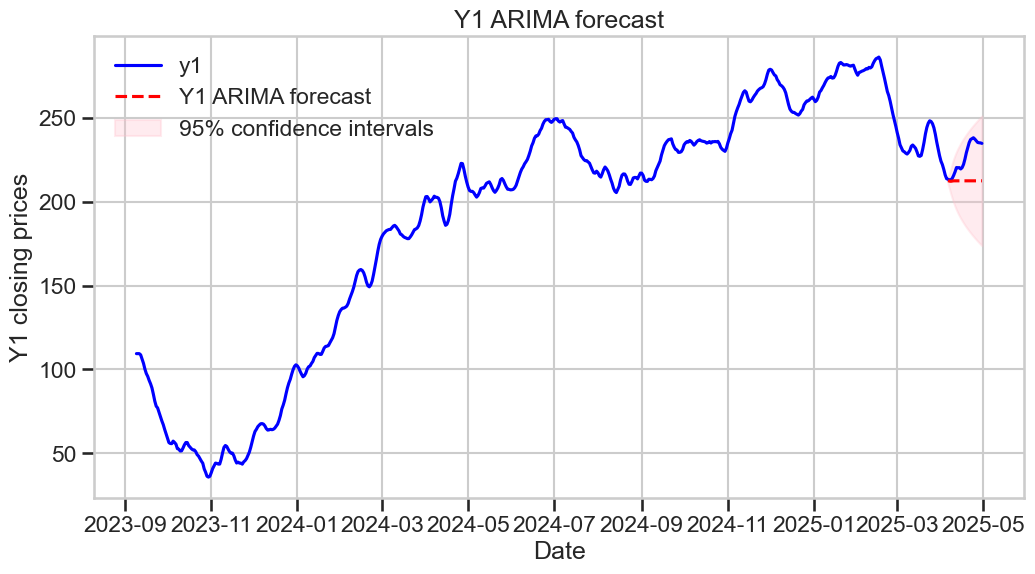

In [75]:
plt.figure(figsize=(12, 6))

# Plotting the true values (in-sample, out-of-sample)
plt.plot(y1_final_df.index, 
         y1_final_df["y1"], 
         label="y1", 
         color="blue", 
         linestyle="-")

# Plotting the forecast
plt.plot(y1_final_df.index, 
         y1_final_df["arima_y1_forecast"], 
         label="Y1 ARIMA forecast", 
         color="red", 
         linestyle="dashed")

# Plotting the confidence intervals
plt.fill_between(y1_final_df.index, 
                 y1_final_df["arima_y1_lower_CI"],
                 y1_final_df["arima_y1_upper_CI"], 
                 color='pink', 
                 alpha=0.3, 
                 label="95% confidence intervals")

plt.title("Y1 ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("Y1 closing prices")
plt.legend()
plt.grid(True)

plt.show()


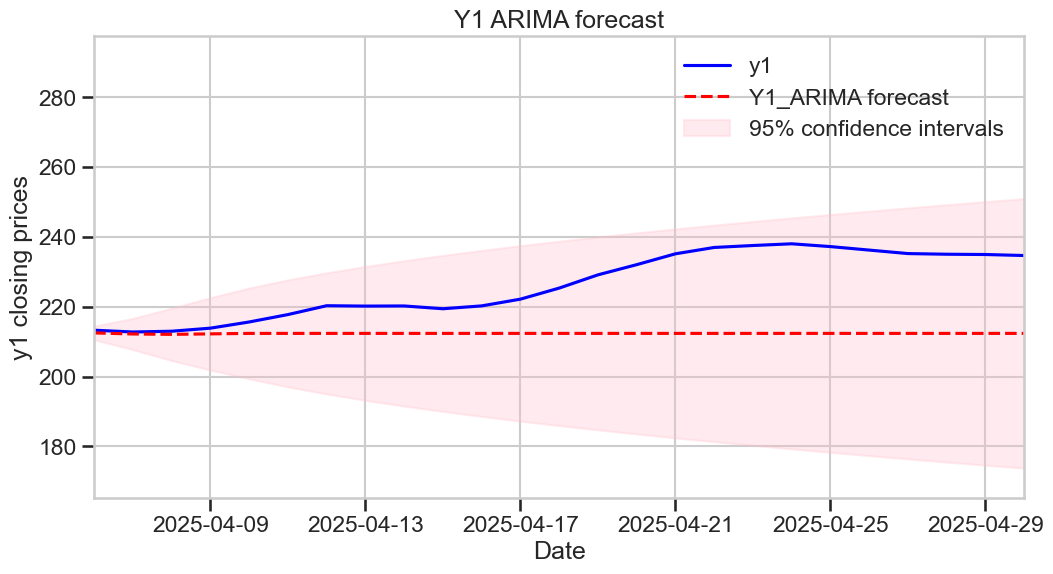

In [76]:
plt.figure(figsize=(12, 6))

# Plotting the true values (in-sample, out-of-sample)
plt.plot(y1_final_df.index, 
         y1_final_df["y1"], 
         label="y1", 
         color="blue", 
         linestyle="-")

# Plotting the forecast
plt.plot(y1_final_df.index, 
         y1_final_df["arima_y1_forecast"], 
         label="Y1_ARIMA forecast", 
         color="red", 
         linestyle="dashed")

# Plotting the confidence intervals
plt.fill_between(y1_final_df.index, 
                 y1_final_df["arima_y1_lower_CI"],
                 y1_final_df["arima_y1_upper_CI"], 
                 color='pink', 
                 alpha=0.3, 
                 label="95% confidence intervals")

plt.title("Y1 ARIMA forecast")
plt.xlabel("Date")
plt.ylabel("y1 closing prices")
plt.legend()
plt.grid(True)

# Here, we zoom the plot by putting limits on X and Y axes values
plt.xlim(final_df.index[-25], final_df.index[-1])
plt.ylim(final_df.tail(15)["y1"].min() * 0.75, final_df.tail(15)["y1"].max() * 1.25)


plt.show()

In [77]:
y1_true_values = y1_forecast_df["y1"].values
y1_forecast_values = y1_forecast_df["arima_y1_forecast"].values
n = len(y1_forecast_values)

# 1. MAE (Mean Absolute Error)
y1_mae = np.sum(np.abs(y1_true_values - y1_forecast_values)) / n

# 2. RMSE (Root Mean Squared Error)
y1_rmse = np.sqrt(np.sum((y1_true_values - y1_forecast_values) ** 2) / n)

# 3. MAPE (Mean Absolute Percentage Error)
y1_mape = np.sum(np.abs((y1_true_values - y1_forecast_values) / y1_true_values)) / n * 100

# 4. AMAPE (Adjusted Mean Absolute Percentage Error)
epsilon = 1e-8  # Small value to avoid division by zero
y1_amape = np.sum(np.abs((y1_true_values - y1_forecast_values) / (np.abs(y1_true_values) + epsilon))) / n * 100

print(f"\nY1 ARIMA Forecast Accuracy:")
print(f"MAE: {y1_mae:.2f}")
print(f"RMSE: {y1_rmse:.2f}")
print(f"MAPE: {y1_mape:.2f}%")
print(f"AMAPE: {y1_amape:.2f}%")

performance_evaluation_matrics['arima_mae_y1']=y1_mae
performance_evaluation_matrics['arima_rmse_y1']=y1_rmse
performance_evaluation_matrics['arima_mape_y1']=y1_mape
performance_evaluation_matrics['arima_amape_y1']=y1_amape


Y1 ARIMA Forecast Accuracy:
MAE: 13.91
RMSE: 16.65
MAPE: 5.99%
AMAPE: 5.99%


### Box-Jenkins procedure - For Y4

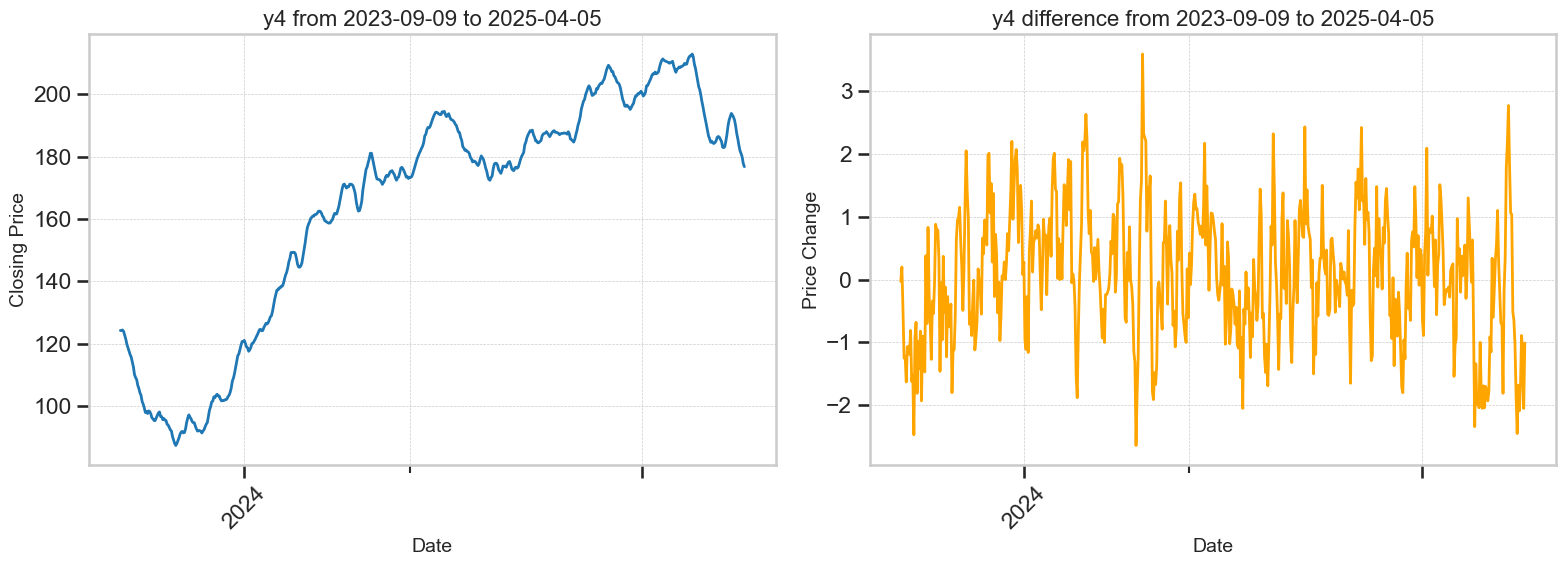

In [78]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  

# --- FIRST PLOT: Closing Prices ---
axes[0].plot(df_short.index, df_short["y4"], linewidth=2)
axes[0].set_title("y4 from 2023-09-09 to 2025-04-05", fontsize=16)
axes[0].set_xlabel('Date', fontsize=14)
axes[0].set_ylabel('Closing Price', fontsize=14)

# Formatting X-axis
axes[0].xaxis.set_major_locator(mdates.YearLocator(1))  # Major ticks every year
axes[0].xaxis.set_minor_locator(mdates.MonthLocator(6))  # Minor ticks every 6 months
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: str(int(mdates.num2date(x).year)) if int(mdates.num2date(x).year) % 2 == 0 else ""))
axes[0].tick_params(axis='x', rotation=45)  # Rotate labels for readability
axes[0].grid(visible=True, which='both', linestyle='--', linewidth=0.5)  # Add grid

# --- SECOND PLOT: First Differences ---
y1_diff = df_short["y4"].diff()  # Compute first differences

axes[1].plot(df_short.index, y1_diff, linewidth=2, color='orange')
axes[1].set_title("y4 difference from 2023-09-09 to 2025-04-05", fontsize=16)
axes[1].set_xlabel('Date', fontsize=14)
axes[1].set_ylabel('Price Change', fontsize=14)

# Formatting X-axis
axes[1].xaxis.set_major_locator(mdates.YearLocator(1))
axes[1].xaxis.set_minor_locator(mdates.MonthLocator(6))
axes[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: str(int(mdates.num2date(x).year)) if int(mdates.num2date(x).year) % 2 == 0 else ""))
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(visible=True, which='both', linestyle='--', linewidth=0.5)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

The series does not look like stationary. Still, it does not appear to include a drift or a deterministic trend. The differences also does not seem to be stationary as their variance is unstable.

#### Testing the integration order

In [79]:
adf_test(df_short["y4"].diff(), max_aug=20)

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                         0             -9.3476                  -2.5670   
1                         1             -7.5528                  -2.5670   
2                         2             -8.5193                  -2.5670   
3                         3             -8.1932                  -2.5670   
4                         4             -7.3883                  -2.5670   
5                         5             -7.4258                  -2.5670   
6                         6             -6.9138                  -2.5670   
7                         7             -6.9455                  -2.5670   
8                         8             -6.2605                  -2.5670   
9                         9             -6.1121                  -2.5670   
10                       10             -5.9512                  -2.5670   
11                       11             -6.0128                  -2.5670   
12                       12             -5.8283                  -2.5670   
13                       13             -5.2851                  -2.5670   
14                       14             -5.3467                  -2.5670   
15                       15             -5.1740                  -2.5670   
16                       16             -4.8843                  -2.5670   
17                       17             -4.5028                  -2.5670   
18                       18             -4.2608                  -2.5670   
19                       19             -4.3122                  -2.5670   

    ADF critival value (5%)  ADF critival value (10%)  \
0                   -1.9410                   -1.6160   
1                   -1.9410                   -1.6160   
2                   -1.9410                   -1.6160   
3                   -1.9410                   -1.6160   
4                   -1.9410                   -1.6160   
5                   -1.9410                   -1.6160   
6                   -1.9410                   -1.6160   
7                   -1.9410                   -1.6160   
8                   -1.9410                   -1.6160   
9                   -1.9410                   -1.6160   
10                  -1.9410                   -1.6160   
11                  -1.9410                   -1.6160   
12                  -1.9410                   -1.6160   
13                  -1.9410                   -1.6160   
14                  -1.9410                   -1.6160   
15                  -1.9410                   -1.6160   
16                  -1.9410                   -1.6160   
17                  -1.9410                   -1.6160   
18                  -1.9410                   -1.6160   
19                  -1.9410                   -1.6160   

    BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                       0.0000                       0.0004   
1                       0.0016                       0.0103   
2                       0.3159                       0.4771   
3                       0.6506                       0.6414   
4                       0.3219                       0.7212   
5                       0.6637                       0.8192   
6                       0.6043                       0.5529   
7                       0.6109                       0.3510   
8                       0.5192                       0.1649   
9                       0.2065                       0.2181   
10                      0.0334                       0.1188   
11                      0.3405                       0.1330   
12                      0.0653                       0.1437   
13                      0.1054                       0.0373   
14                      0.1770                       0.1020   
15                      0.3376                       0.2458   
16                      0.2382                       0.1322   
17                      0.6424                       0.1797   
18          

number of augmentations  ADF test statistic  ADF critival value (1%)  \
0                         0             -9.3476                  -2.5670   
1                         1             -7.5528                  -2.5670   
2                         2             -8.5193                  -2.5670   
3                         3             -8.1932                  -2.5670   
4                         4             -7.3883                  -2.5670   
5                         5             -7.4258                  -2.5670   
6                         6             -6.9138                  -2.5670   
7                         7             -6.9455                  -2.5670   
8                         8             -6.2605                  -2.5670   
9                         9             -6.1121                  -2.5670   
10                       10             -5.9512                  -2.5670   
11                       11             -6.0128                  -2.5670   
12                       12             -5.8283                  -2.5670   
13                       13             -5.2851                  -2.5670   
14                       14             -5.3467                  -2.5670   
15                       15             -5.1740                  -2.5670   
16                       16             -4.8843                  -2.5670   
17                       17             -4.5028                  -2.5670   
18                       18             -4.2608                  -2.5670   
19                       19             -4.3122                  -2.5670   

    ADF critival value (5%)  ADF critival value (10%)  \
0                   -1.9410                   -1.6160   
1                   -1.9410                   -1.6160   
2                   -1.9410                   -1.6160   
3                   -1.9410                   -1.6160   
4                   -1.9410                   -1.6160   
5                   -1.9410                   -1.6160   
6                   -1.9410                   -1.6160   
7                   -1.9410                   -1.6160   
8                   -1.9410                   -1.6160   
9                   -1.9410                   -1.6160   
10                  -1.9410                   -1.6160   
11                  -1.9410                   -1.6160   
12                  -1.9410                   -1.6160   
13                  -1.9410                   -1.6160   
14                  -1.9410                   -1.6160   
15                  -1.9410                   -1.6160   
16                  -1.9410                   -1.6160   
17                  -1.9410                   -1.6160   
18                  -1.9410                   -1.6160   
19                  -1.9410                   -1.6160   

    BG test (5 lags) (p-value)  BG test (10 lags) (p-value)  \
0                       0.0000                       0.0004   
1                       0.0016                       0.0103   
2                       0.3159                       0.4771   
3                       0.6506                       0.6414   
4                       0.3219                       0.7212   
5                       0.6637                       0.8192   
6                       0.6043                       0.5529   
7                       0.6109                       0.3510   
8                       0.5192                       0.1649   
9                       0.2065                       0.2181   
10                      0.0334                       0.1188   
11                      0.3405                       0.1330   
12                      0.0653                       0.1437   
13                      0.1054                       0.0373   
14                      0.1770                       0.1020   
15                      0.3376                       0.2458   
16                      0.2382                       0.1322   
17                      0.6424                       0.1797   
18          

Assumming 1%-significance-level, one needs to use 3 augmentations to conclude that the series in non-stationary.
BG Test H0: No serieal autocorrelation (p>.05)

#### Initial identification of ARIMA orders

The series is ~ I(1). Therefore for ARIMA(p,d,q), d=1. Let us determine the initial values of p and q. For this purpose, we should consider ACF and PACF of the differences (as they are stationary).

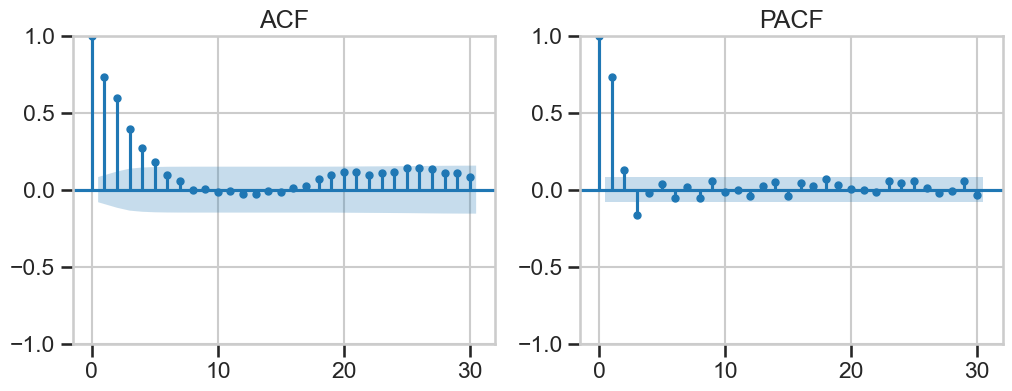

In [80]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(np.array(df_short["y4"].diff())[1:], lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")

# Partial autocorrelation plot
plot_pacf(np.array(df_short["y4"].diff())[1:], lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")

plt.show()

The ACF exhibits a sharp cutoff after '5' lags.
The PACF shows a more gradual decay. This pattern strongly suggests an MA(5) model.

Therefore, for our differenced time series data, the best model to start with would be an MA(5) model.





#### Model estimation

In [81]:
# Definition of ARIMA model
model = ARIMA(df_short["y4"].values, order=(0, 1, 5))  # p=0, d=1, q=2
y4_arima015_ = model.fit()
# Summary
print(y4_arima015_.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(0, 1, 5)   Log Likelihood                -597.824
Date:                Sat, 21 Jun 2025   AIC                           1207.648
Time:                        21:36:11   BIC                           1233.763
Sample:                             0   HQIC                          1217.834
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6579      0.044     14.946      0.000       0.572       0.744
ma.L2          0.6570      0.051     12.849      0.000       0.557       0.757
ma.L3          0.4011      0.053      7.604      0.0

#### Model diagnostics

Every time we obtain a model, we should test its residuals for autocorrelation. Similarily to Breusch-Godfrey test, trying different numbers of lags is highly recommended.

In [82]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y4_arima015_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.0470     1.0000
10   0.0791     1.0000
15   0.2247     1.0000
20   0.3848     1.0000
25   0.5134     1.0000
30   0.6247     1.0000


Residuals are not autocorrelated when trying some numbers of lags. In case of autocorrelation, one should add more parameters to the model. Prominently, the ones suggested by ACF and PACF of the residuals.

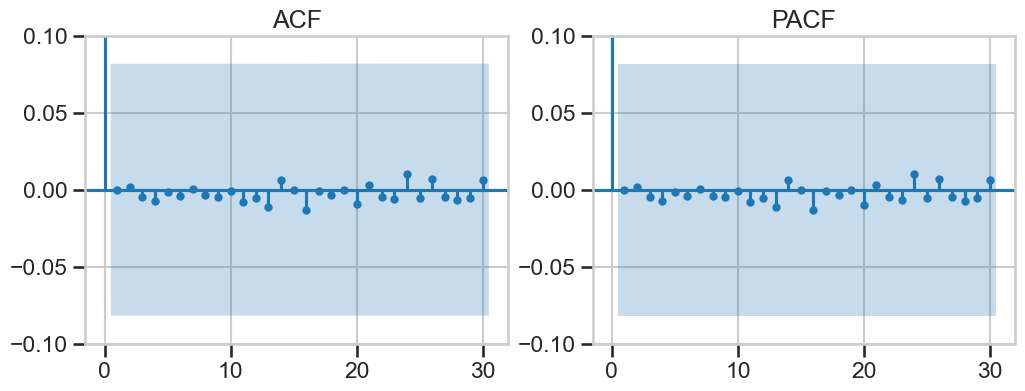

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y4_arima015_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y4_arima015_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

#### Model refinement

Let us try ARIMA(0,1,13) without some of the intermediate lags of the dependent variable, i.e.

$$\Delta y_t = \alpha_5 \epsilon_{t-5} + \alpha_{13} \epsilon_{t-13} + \epsilon_t$$

In [84]:
# Definition of ARIMA model
model = ARIMA(df_short['y4'].values, order=(0, 1, [5,13]))

# Fitting the model
y4_arima0113_ = model.fit()
# arima1310_ = model.fit(start_params=[0.0, 0.1, 0.1])  # [const, ma.L1, ma.L2]


# Summary
print(y4_arima0113_.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  575
Model:             ARIMA(0, 1, [5, 13])   Log Likelihood                -819.244
Date:                  Sat, 21 Jun 2025   AIC                           1644.487
Time:                          21:36:28   BIC                           1657.545
Sample:                               0   HQIC                          1649.580
                                  - 575                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L5          0.1949      0.039      4.954      0.000       0.118       0.272
ma.L13        -0.0209      0.043     -0.491      0.623      -0.104       0.063
sigma2         1.0164      0.061    

In [85]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y4_arima0113_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.7127     0.9823
10   1.0278     0.9998
15   1.4361     1.0000
20   1.6867     1.0000
25   1.7770     1.0000
30   1.8941     1.0000


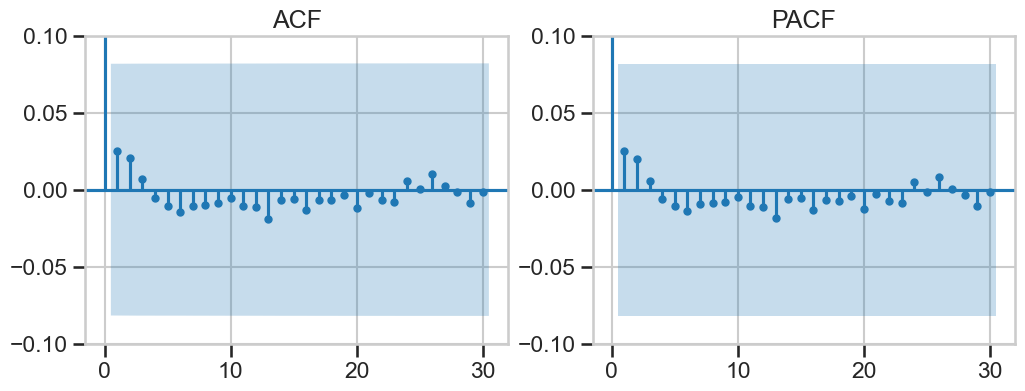

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y4_arima0113_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y4_arima0113_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [87]:
# Definition of ARIMA model
model = ARIMA(df_short['y4'].values, order=(0, 1, [5,20]))

# Fitting the model
y4_arima0120_5_ = model.fit()
# arima1310_ = model.fit(start_params=[0.0, 0.1, 0.1])  # [const, ma.L1, ma.L2]


# Summary
print(y4_arima0120_5_.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  575
Model:             ARIMA(0, 1, [5, 20])   Log Likelihood                -816.455
Date:                  Sat, 21 Jun 2025   AIC                           1638.910
Time:                          21:36:40   BIC                           1651.968
Sample:                               0   HQIC                          1644.003
                                  - 575                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L5          0.1731      0.038      4.537      0.000       0.098       0.248
ma.L20         0.1255      0.043      2.914      0.004       0.041       0.210
sigma2         1.0061      0.061    

In [88]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y4_arima0120_5_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.7000     0.9830
10   1.0312     0.9998
15   1.4985     1.0000
20   1.8443     1.0000
25   1.9748     1.0000
30   2.1133     1.0000


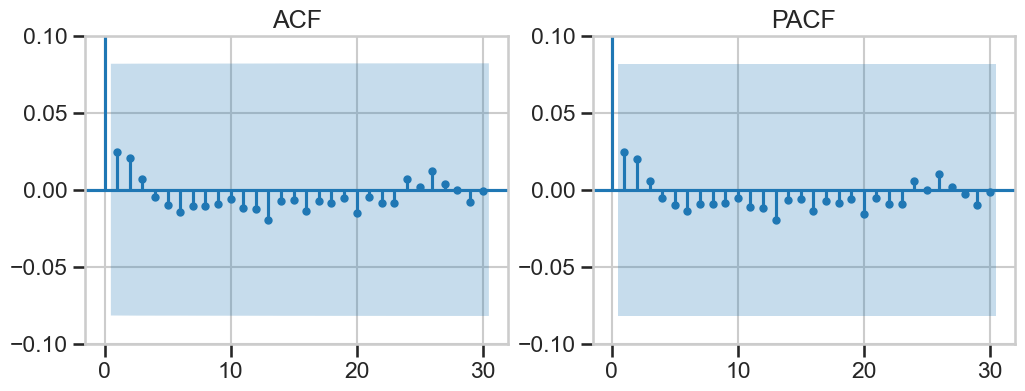

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y4_arima0120_5_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y4_arima0120_5_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [90]:
# Definition of ARIMA model
model = ARIMA(df_short['y4'].values, order=(0, 1, [5, 20, 25]))

# Fitting the model
y4_arima0125_20_ = model.fit()

# Summary
print(y4_arima0125_20_.summary())

                                  SARIMAX Results                                   
Dep. Variable:                            y   No. Observations:                  575
Model:             ARIMA(0, 1, [5, 20, 25])   Log Likelihood                -811.875
Date:                      Sat, 21 Jun 2025   AIC                           1631.749
Time:                              21:36:44   BIC                           1649.160
Sample:                                   0   HQIC                          1638.540
                                      - 575                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L5          0.1704      0.040      4.279      0.000       0.092       0.248
ma.L20         0.1284      0.043      3.000      0.003       0.045       0.212
ma.L

In [91]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y4_arima0125_20_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.6803     0.9840
10   1.0193     0.9998
15   1.4553     1.0000
20   1.7899     1.0000
25   1.9510     1.0000
30   2.0368     1.0000


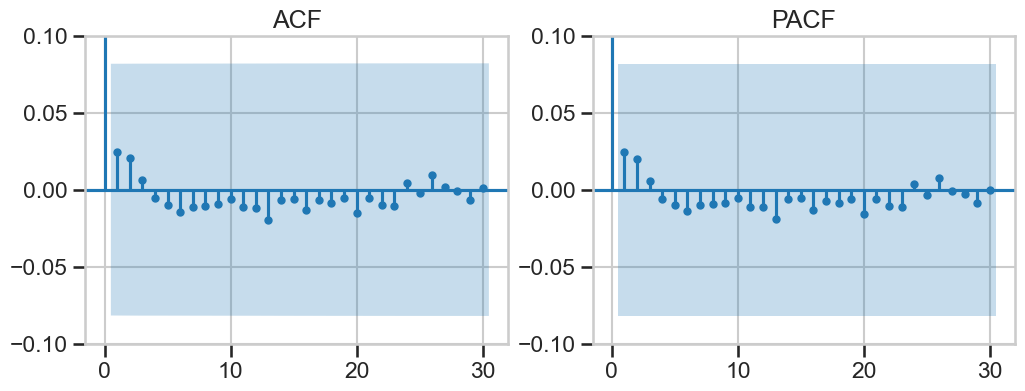

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y4_arima0125_20_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y4_arima0125_20_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [93]:
# Definition of ARIMA model
model = ARIMA(df_short['y4'].values, order=(0, 1, [5, 20, 27]))

# Fitting the model
y4_arima0127_20_ = model.fit()

# Summary
print(y4_arima0127_20_.summary())

                                  SARIMAX Results                                   
Dep. Variable:                            y   No. Observations:                  575
Model:             ARIMA(0, 1, [5, 20, 27])   Log Likelihood                -812.888
Date:                      Sat, 21 Jun 2025   AIC                           1633.776
Time:                              21:36:52   BIC                           1651.186
Sample:                                   0   HQIC                          1640.567
                                      - 575                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L5          0.1600      0.039      4.128      0.000       0.084       0.236
ma.L20         0.1304      0.043      3.023      0.003       0.046       0.215
ma.L

In [94]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y4_arima0127_20_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.6738     0.9844
10   1.0076     0.9998
15   1.4471     1.0000
20   1.8014     1.0000
25   1.9294     1.0000
30   2.0505     1.0000


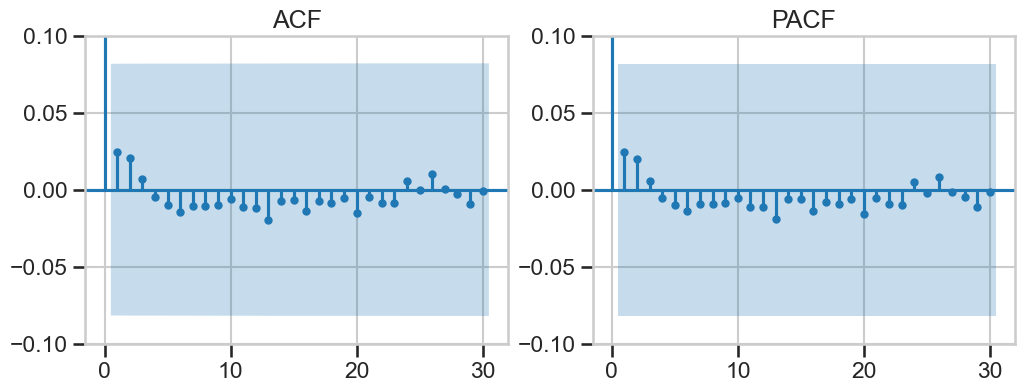

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y4_arima0127_20_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y4_arima0127_20_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

#### Other possible ARIMA model specification

Other optons we can start from MA[3]

In [96]:
# Definition of ARIMA model
model = ARIMA(df_short["y4"].values, order=(0, 1, 3))  # p=0, d=1, q=2
y4_arima013_ = model.fit()
# Summary
print(y4_arima013_.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(0, 1, 3)   Log Likelihood                -610.515
Date:                Sat, 21 Jun 2025   AIC                           1229.029
Time:                        21:37:03   BIC                           1246.440
Sample:                             0   HQIC                          1235.820
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6401      0.044     14.707      0.000       0.555       0.725
ma.L2          0.5774      0.045     12.718      0.000       0.488       0.666
ma.L3          0.2782      0.042      6.568      0.0

In [97]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y4_arima013_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.0298     1.0000
10   0.0843     1.0000
15   0.2570     1.0000
20   0.4720     1.0000
25   0.5756     1.0000
30   0.6802     1.0000


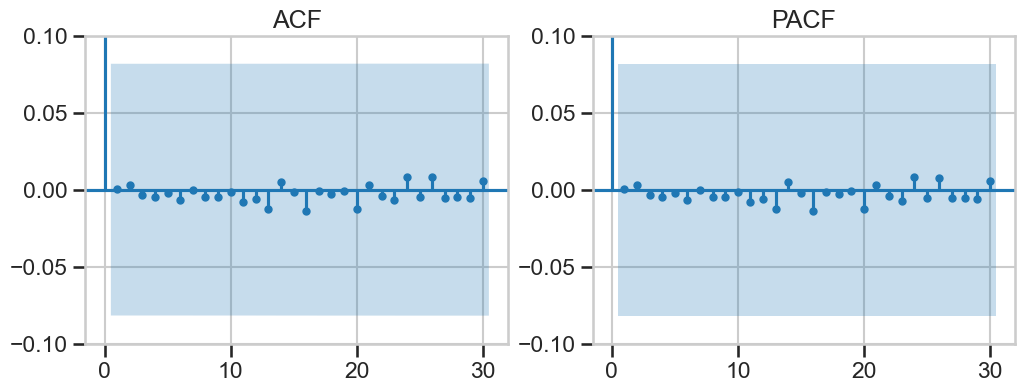

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y4_arima013_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y4_arima013_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [99]:
# we can think to add lag 20 as well 
# Definition of ARIMA model
model = ARIMA(df_short["y4"].values, order=(0, 1, [3,20]))  # p=0, d=1, q=2
y4_arima0120_ = model.fit()
# Summary
print(y4_arima0120_.summary())

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                  575
Model:             ARIMA(0, 1, [3, 20])   Log Likelihood                -778.468
Date:                  Sat, 21 Jun 2025   AIC                           1562.936
Time:                          21:37:13   BIC                           1575.994
Sample:                               0   HQIC                          1568.029
                                  - 575                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L3          0.3849      0.038     10.185      0.000       0.311       0.459
ma.L20         0.1095      0.040      2.760      0.006       0.032       0.187
sigma2         0.8809      0.057    

In [100]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y4_arima0120_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.3873     0.9957
10   0.5176     1.0000
15   0.9075     1.0000
20   1.1688     1.0000
25   1.2520     1.0000
30   1.4272     1.0000


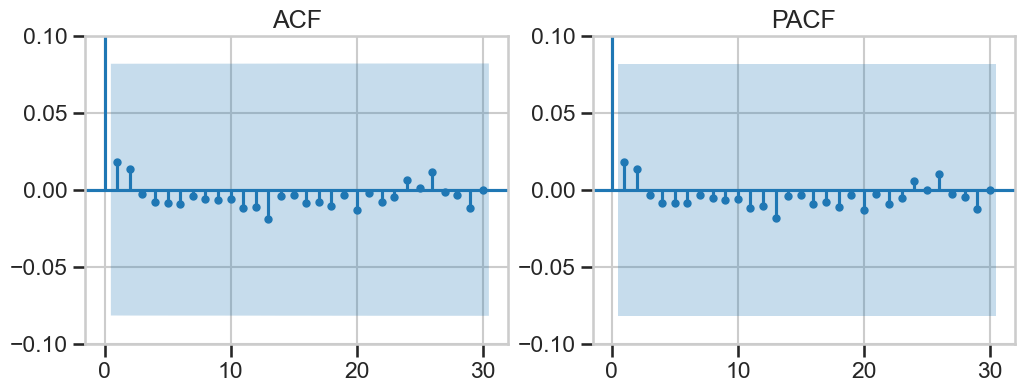

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y4_arima0120_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y4_arima0120_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [102]:
# Now we can give some assumption to AR part AR(3)
# Definition of ARIMA model
model = ARIMA(df_short['y4'].values, order=(3, 1, 0))

# Fitting the model
y4_arima310_ = model.fit()

# Summary
print(y4_arima310_.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  575
Model:                 ARIMA(3, 1, 0)   Log Likelihood                -595.708
Date:                Sat, 21 Jun 2025   AIC                           1199.417
Time:                        21:37:21   BIC                           1216.827
Sample:                             0   HQIC                          1206.208
                                - 575                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6565      0.043     15.244      0.000       0.572       0.741
ar.L2          0.2409      0.050      4.772      0.000       0.142       0.340
ar.L3         -0.1671      0.041     -4.121      0.0

In [103]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y4_arima310_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.0607     1.0000
10   0.0924     1.0000
15   0.2303     1.0000
20   0.3795     1.0000
25   0.5098     1.0000
30   0.6209     1.0000


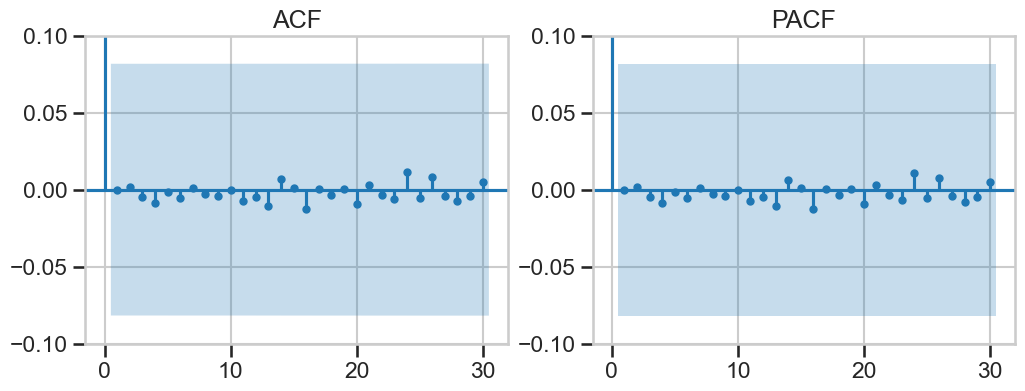

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y4_arima310_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y4_arima310_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [105]:
# Now we can give some assumption to AR part AR(3)
# Definition of ARIMA model
model = ARIMA(df_short['y4'].values, order=([3, 14, 17], 1, 0))

# Fitting the model
y4_arima3_14_17_10_ = model.fit()

# Summary
print(y4_arima3_14_17_10_.summary())

                                  SARIMAX Results                                   
Dep. Variable:                            y   No. Observations:                  575
Model:             ARIMA([3, 14, 17], 1, 0)   Log Likelihood                  -4.829
Date:                      Sat, 21 Jun 2025   AIC                             17.658
Time:                              21:37:33   BIC                             35.069
Sample:                                   0   HQIC                            24.449
                                      - 575                                         
Covariance Type:                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L3          1.9702      0.006    337.474      0.000       1.959       1.982
ar.L14        -1.1347      0.007   -173.480      0.000      -1.148      -1.122
ar.L

In [106]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y4_arima3_14_17_10_.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5  362.1553     0.0000
10 418.2317     0.0000
15 422.2727     0.0000
20 422.5759     0.0000
25 422.6252     0.0000
30 422.6292     0.0000


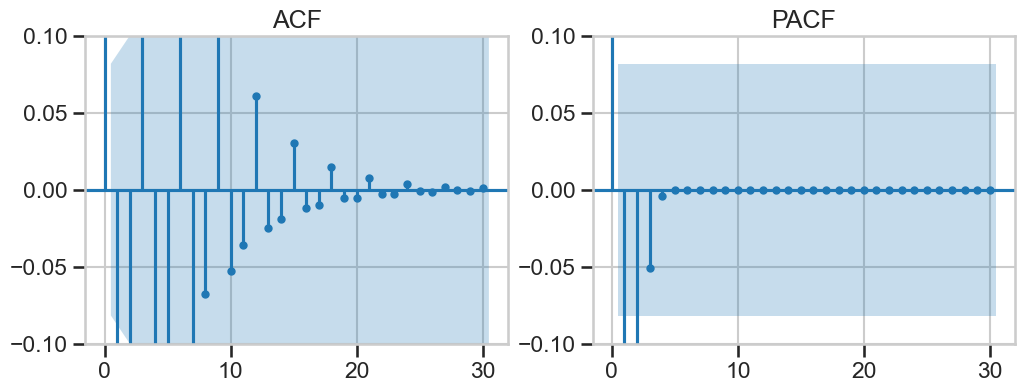

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y4_arima3_14_17_10_.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y4_arima3_14_17_10_.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

In [108]:
# Now we can give some assumption to AR part AR(3)
# Definition of ARIMA model
model = ARIMA(df_short['y4'].values, order=([3], 1, [20, 25]))

# Fitting the model
y4_arima3_1_20_25 = model.fit()

# Summary
print(y4_arima3_1_20_25.summary())

                                  SARIMAX Results                                  
Dep. Variable:                           y   No. Observations:                  575
Model:             ARIMA([3], 1, [20, 25])   Log Likelihood                -773.081
Date:                     Sat, 21 Jun 2025   AIC                           1554.162
Time:                             21:37:39   BIC                           1571.573
Sample:                                  0   HQIC                          1560.953
                                     - 575                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L3          0.3893      0.040      9.666      0.000       0.310       0.468
ma.L20         0.1150      0.042      2.707      0.007       0.032       0.198
ma.L25      

In [109]:
# Ljung-Box test for autocorrelation of residuals
ljung_test = acorr_ljungbox(y4_arima3_1_20_25.resid, lags=[5, 10, 15, 20, 25, 30], return_df=True)
print(ljung_test)

    lb_stat  lb_pvalue
5    0.4375     0.9942
10   0.6389     1.0000
15   0.9577     1.0000
20   1.1591     1.0000
25   1.2464     1.0000
30   1.4063     1.0000


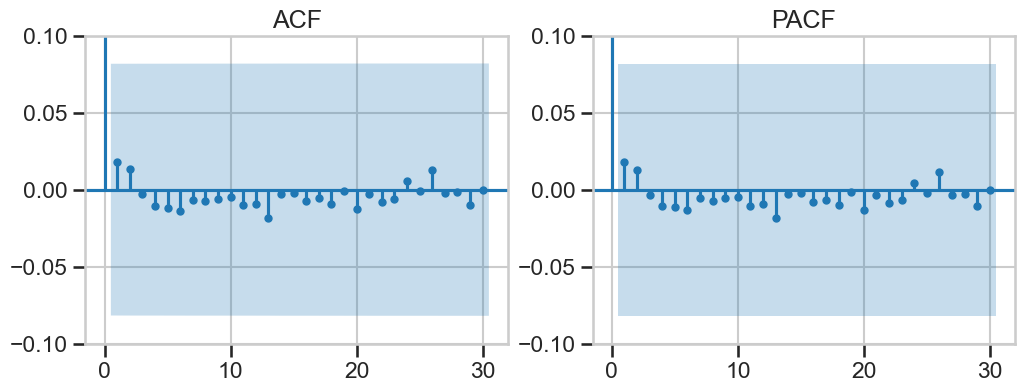

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Autocorrelation plot
plot_acf(y4_arima3_1_20_25.resid, lags=30, ax=axes[0]) # ACF
axes[0].set_title("ACF")
axes[0].set_ylim([-0.1,0.1])

# Partial autocorrelation plot
plot_pacf(y4_arima3_1_20_25.resid, lags=30, ax=axes[1]) # PACF
axes[1].set_title("PACF")
axes[1].set_ylim([-0.1,0.1])

plt.show()

#### Forecasting with ARIMA model

**Choosing the best model**

The best model can be chosen with different criteria. Still, usually the choice is based on the information criteria, e.g. AIC, BIC. The lower they are, the better the model (see lecture slides).

In [111]:
models = [y4_arima015_, y4_arima0113_, y4_arima0120_5_, y4_arima0125_20_, y4_arima0127_20_, y4_arima013_, y4_arima0120_, y4_arima310_, y4_arima3_1_20_25] # list with all the models
names = ['y4_arima015_', 'y4_arima0113_', 'y4_arima0120_5_', 'y4_arima0125_20_', 'y4_arima0127_20_', 'y4_arima013_', 'y4_arima0120_', 'y4_arima310_', 'y4_arima3_1_20_25'] # models' names

# Preparing a DataFrame with models sorted by AIC, BIC
results = []
for model, name in zip(models, names):
    results.append([name, round(model.aic,2), round(model.bic,2)])
results_df = pd.DataFrame(results)
results_df.columns = ['model', 'AIC', 'BIC']

print('Models by AIC:\n',results_df.sort_values('AIC'))
print('Models by BIC:\n',results_df.sort_values('BIC'))

Models by AIC:
                model        AIC        BIC
7       y4_arima310_ 1,199.4200 1,216.8300
0       y4_arima015_ 1,207.6500 1,233.7600
5       y4_arima013_ 1,229.0300 1,246.4400
8  y4_arima3_1_20_25 1,554.1600 1,571.5700
6      y4_arima0120_ 1,562.9400 1,575.9900
3   y4_arima0125_20_ 1,631.7500 1,649.1600
4   y4_arima0127_20_ 1,633.7800 1,651.1900
2    y4_arima0120_5_ 1,638.9100 1,651.9700
1      y4_arima0113_ 1,644.4900 1,657.5500
Models by BIC:
                model        AIC        BIC
7       y4_arima310_ 1,199.4200 1,216.8300
0       y4_arima015_ 1,207.6500 1,233.7600
5       y4_arima013_ 1,229.0300 1,246.4400
8  y4_arima3_1_20_25 1,554.1600 1,571.5700
6      y4_arima0120_ 1,562.9400 1,575.9900
3   y4_arima0125_20_ 1,631.7500 1,649.1600
4   y4_arima0127_20_ 1,633.7800 1,651.1900
2    y4_arima0120_5_ 1,638.9100 1,651.9700
1      y4_arima0113_ 1,644.4900 1,657.5500


It appears that ARIMA(3,1,0) without some of the intermediate lags is the best model (lowest AIC and BIC).

**Forecasting with the best model**

Now, let us obtain the forecast, vizualize it, and calculate its ex post error measures.

In [115]:
# Forecast for next 25 days
y4_forecast_results = y4_arima310_.get_forecast(steps=25)

# Point forecast
y4_forecast_values = y4_forecast_results.predicted_mean

# Confidence (by default 95%) intervals of the point forecast
y4_confidence_intervals = y4_forecast_results.conf_int()

y4_forecast_df = pd.DataFrame({
    "arima_y4_forecast": y4_forecast_values,
    "arima_y4_lower_CI": y4_confidence_intervals[:, 0],
    "arima_y4_upper_CI": y4_confidence_intervals[:, 1],
    "y4": df_oos['y4']
}, index=df_oos.index)

print(y4_forecast_df.head(2))
print(y4_forecast_df.tail(2))

            arima_y4_forecast  arima_y4_lower_CI  arima_y4_upper_CI       y4
date                                                                        
2025-04-06           175.8235           174.4857           177.1613 176.5900
2025-04-07           175.2881           172.6995           177.8766 176.2700
            arima_y4_forecast  arima_y4_lower_CI  arima_y4_upper_CI       y4
date                                                                        
2025-04-29           174.1986           151.8078           196.5894 186.8800
2025-04-30           174.1986           151.2646           197.1326 186.7600


In [116]:
# Here, we add the data used for fitting the model
y4_final_df = pd.concat([df_short['y4'], y4_forecast_df], axis=0)

In [117]:
print(y4_final_df.head(2))
print(y4_final_df.tail(2))

                 y4  arima_y4_forecast  arima_y4_lower_CI  arima_y4_upper_CI
date                                                                        
2023-09-09 124.2400                NaN                NaN                NaN
2023-09-10 124.2100                NaN                NaN                NaN
                 y4  arima_y4_forecast  arima_y4_lower_CI  arima_y4_upper_CI
date                                                                        
2025-04-29 186.8800           174.1986           151.8078           196.5894
2025-04-30 186.7600           174.1986           151.2646           197.1326


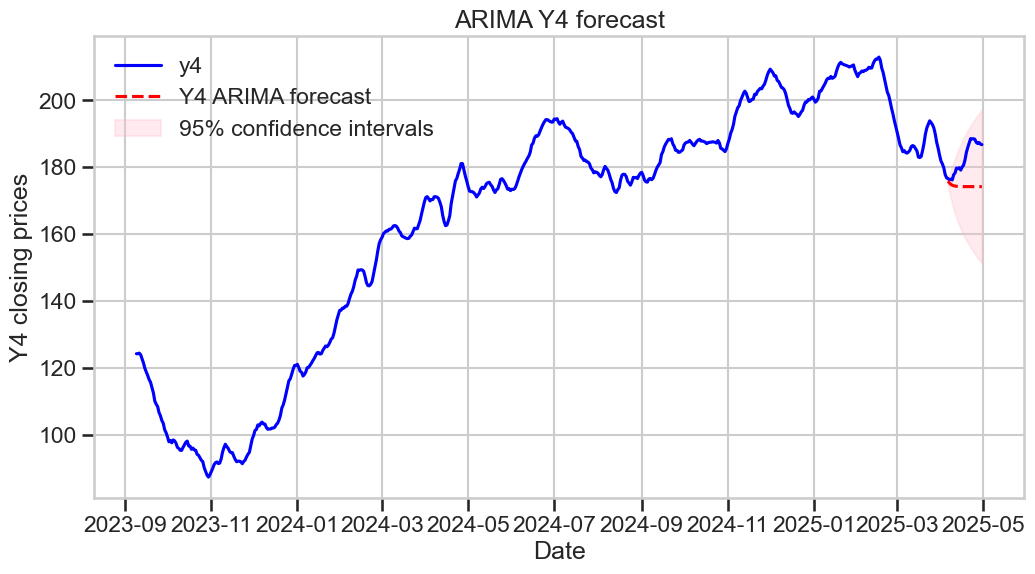

In [118]:
plt.figure(figsize=(12, 6))

# Plotting the true values (in-sample, out-of-sample)
plt.plot(y4_final_df.index, 
         y4_final_df["y4"], 
         label="y4", 
         color="blue", 
         linestyle="-")

# Plotting the forecast
plt.plot(y4_final_df.index, 
         y4_final_df["arima_y4_forecast"], 
         label="Y4 ARIMA forecast", 
         color="red", 
         linestyle="dashed")

# Plotting the confidence intervals
plt.fill_between(y4_final_df.index, 
                 y4_final_df["arima_y4_lower_CI"],
                 y4_final_df["arima_y4_upper_CI"], 
                 color='pink', 
                 alpha=0.3, 
                 label="95% confidence intervals")

plt.title("ARIMA Y4 forecast")
plt.xlabel("Date")
plt.ylabel("Y4 closing prices")
plt.legend()
plt.grid(True)

plt.show()


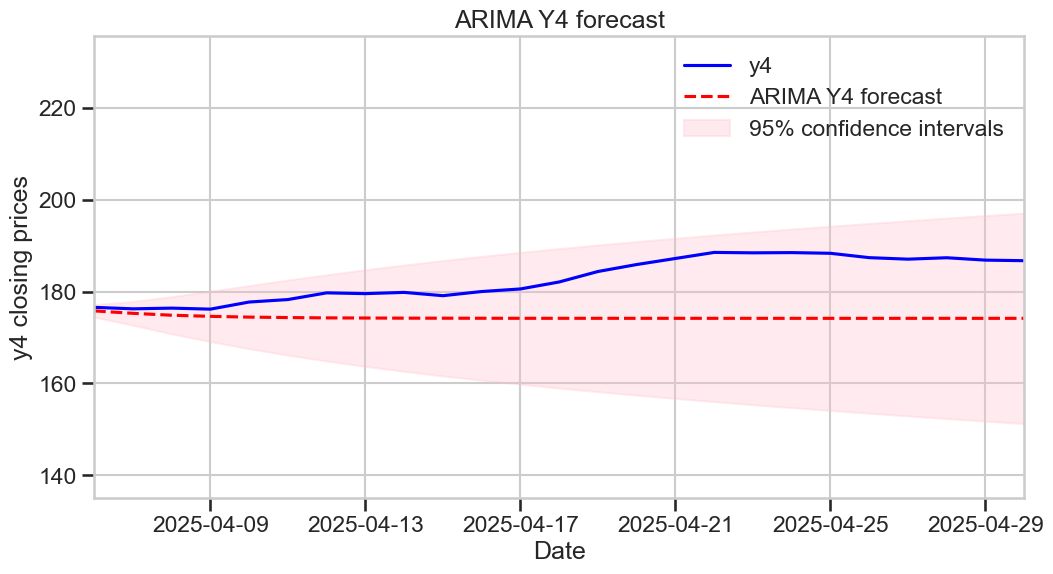

In [119]:
plt.figure(figsize=(12, 6))

# Plotting the true values (in-sample, out-of-sample)
plt.plot(y4_final_df.index, 
         y4_final_df["y4"], 
         label="y4", 
         color="blue", 
         linestyle="-")

# Plotting the forecast
plt.plot(y4_final_df.index, 
         y4_final_df["arima_y4_forecast"], 
         label="ARIMA Y4 forecast", 
         color="red", 
         linestyle="dashed")

# Plotting the confidence intervals
plt.fill_between(y4_final_df.index, 
                 y4_final_df["arima_y4_lower_CI"],
                 y4_final_df["arima_y4_upper_CI"], 
                 color='pink', 
                 alpha=0.3, 
                 label="95% confidence intervals")

plt.title("ARIMA Y4 forecast")
plt.xlabel("Date")
plt.ylabel("y4 closing prices")
plt.legend()
plt.grid(True)

# Here, we zoom the plot by putting limits on X and Y axes values
plt.xlim(y4_final_df.index[-25], y4_final_df.index[-1])
plt.ylim(y4_final_df.tail(15)["y4"].min() * 0.75, y4_final_df.tail(15)["y4"].max() * 1.25)


plt.show()

In [120]:
y4_true_values = y4_forecast_df["y4"].values
y4_forecast_values = y4_forecast_df["arima_y4_forecast"].values
n = len(y4_forecast_values)

# 1. MAE (Mean Absolute Error)
y4_mae = np.sum(np.abs(y4_true_values - y4_forecast_values)) / n

# 2. RMSE (Root Mean Squared Error)
y4_rmse = np.sqrt(np.sum((y4_true_values - y4_forecast_values) ** 2) / n)

# 3. MAPE (Mean Absolute Percentage Error)
y4_mape = np.sum(np.abs((y4_true_values - y4_forecast_values) / y4_true_values)) / n * 100

# 4. AMAPE (Adjusted Mean Absolute Percentage Error)
epsilon = 1e-8  # Small value to avoid division by zero
y4_amape = np.sum(np.abs((y4_true_values - y4_forecast_values) / (np.abs(y4_true_values) + epsilon))) / n * 100

print(f"\nY4 ARIMA Forecast Accuracy:")

print(f"MAE: {y4_mae:.2f}")
print(f"RMSE: {y4_rmse:.2f}")
print(f"MAPE: {y4_mape:.2f}%")
print(f"AMAPE: {y4_amape:.2f}%")

performance_evaluation_matrics['arima_mae_y4']=y4_mae
performance_evaluation_matrics['arima_rmse_y4']=y4_rmse
performance_evaluation_matrics['arima_mape_y4']=y4_mape
performance_evaluation_matrics['arima_amape_y4']=y4_amape


Y4 ARIMA Forecast Accuracy:
MAE: 8.41
RMSE: 9.68
MAPE: 4.54%
AMAPE: 4.54%


## 7. Comparing VECM forecast with ARIMA forecast

### Merging all the forecasted results

In [121]:
final_merged_df = pd.concat([df_merged, y1_final_df, y4_final_df], axis=1)
# Remove duplicate columns (keep first occurrence)
final_merged_df = final_merged_df.loc[:, ~final_merged_df.columns.duplicated()]

display(final_merged_df.head(2))
display(final_merged_df.tail(2))

y1       y4  vecm_x_fore  vecm_y_fore  vecm_x_lower  \
date                                                                   
2023-09-09 109.4100 124.2400          NaN          NaN           NaN   
2023-09-10 109.4100 124.2100          NaN          NaN           NaN   

            vecm_y_lower  vecm_x_upper  vecm_y_upper  arima_y1_forecast  \
date                                                                      
2023-09-09           NaN           NaN           NaN                NaN   
2023-09-10           NaN           NaN           NaN                NaN   

            arima_y1_lower_CI  arima_y1_upper_CI  arima_y4_forecast  \
date                                                                  
2023-09-09                NaN                NaN                NaN   
2023-09-10                NaN                NaN                NaN   

            arima_y4_lower_CI  arima_y4_upper_CI  
date                                              
2023-09-09                NaN                NaN  
2023-09-10                NaN                NaN

y1       y4  vecm_x_fore  vecm_y_fore  vecm_x_lower  \
date                                                                   
2025-04-29 234.9900 186.8800     219.2825     179.3583      178.3015   
2025-04-30 234.7000 186.7600     219.4026     179.4183      177.5644   

            vecm_y_lower  vecm_x_upper  vecm_y_upper  arima_y1_forecast  \
date                                                                      
2025-04-29      158.8766      260.2635      199.8400           212.3913   
2025-04-30      158.5077      261.2408      200.3289           212.3913   

            arima_y1_lower_CI  arima_y1_upper_CI  arima_y4_forecast  \
date                                                                  
2025-04-29           174.6381           250.1446           174.1986   
2025-04-30           173.7723           251.0104           174.1986   

            arima_y4_lower_CI  arima_y4_upper_CI  
date                                              
2025-04-29           151.8078           196.5894  
2025-04-30           151.2646           197.1326

In [122]:
display(performance_evaluation_matrics)

{'vecm_mae_y1': np.float64(9.148653513413205),
 'vecm_rmse_y1': np.float64(11.706053567220176),
 'vecm_mape_y1': np.float64(3.9197848746030037),
 'vecm_amape_y1': np.float64(4.048081550891754),
 'vecm_mae_y4': np.float64(4.526444988337093),
 'vecm_rmse_y4': np.float64(5.789043738815967),
 'vecm_mape_y4': np.float64(2.4291892811565075),
 'vecm_amape_y4': np.float64(2.4780052982204377),
 'arima_mae_y1': np.float64(13.91066782361152),
 'arima_rmse_y1': np.float64(16.646089825674313),
 'arima_mape_y1': np.float64(5.992923307710265),
 'arima_amape_y1': np.float64(5.992923307451859),
 'arima_mae_y4': np.float64(8.405987946536692),
 'arima_rmse_y4': np.float64(9.684814513518342),
 'arima_mape_y4': np.float64(4.535951862972726),
 'arima_amape_y4': np.float64(4.535951862727868)}

**Getting the last two months data to make plotting of y1 and y2 with their forecasted values highly visiable**

In [123]:
# Getting last two months data - to make plotting more visible
latest_date = final_merged_df.index.max()

# Subtract 2 months
from pandas.tseries.offsets import DateOffset
start_date = latest_date - DateOffset(months=2)

# Filter the DataFrame
last_2_months_df = final_merged_df.loc[start_date:]

### Y1 and forecasted values of respective VECM and ARIMA models

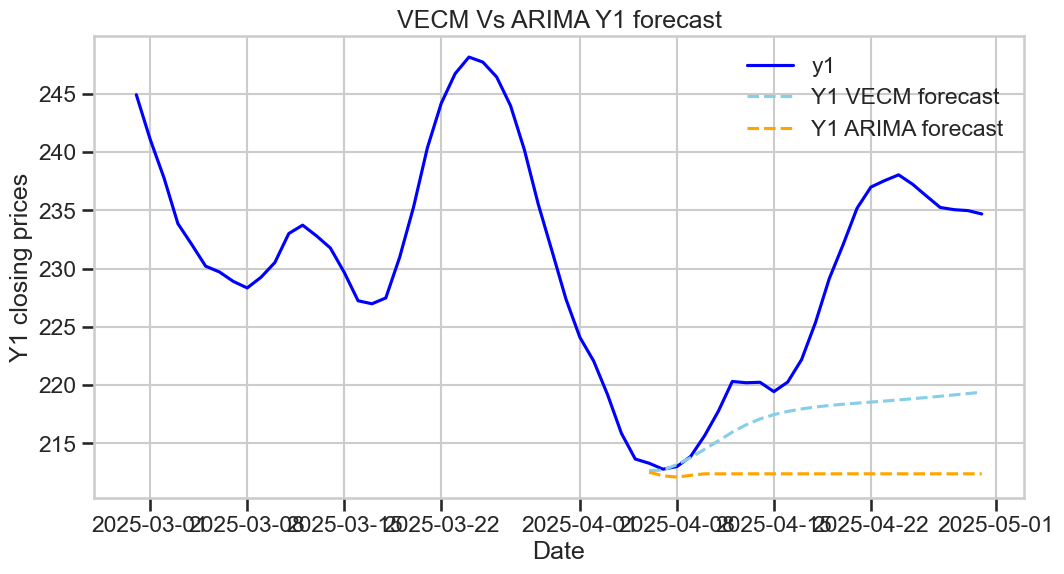

In [124]:
plt.figure(figsize=(12, 6))
# Plotting the true values (in-sample, out-of-sample)
plt.plot(last_2_months_df.index, 
         last_2_months_df["y1"], 
         label="y1", 
         color="blue", 
         linestyle="-")

# Plotting the VECM forecast
plt.plot(last_2_months_df.index, 
         last_2_months_df["vecm_x_fore"], 
         label="Y1 VECM forecast", 
         color="skyblue", 
         linestyle="dashed")
# Plotting the ARIMA forecast
plt.plot(last_2_months_df.index, 
         last_2_months_df["arima_y1_forecast"], 
         label="Y1 ARIMA forecast", 
         color="orange", 
         linestyle="dashed")

plt.title("VECM Vs ARIMA Y1 forecast")
plt.xlabel("Date")
plt.ylabel("Y1 closing prices")
plt.legend()
plt.grid(True)

plt.show()

### Y4 and forecasted values of respective VECM and ARIMA models

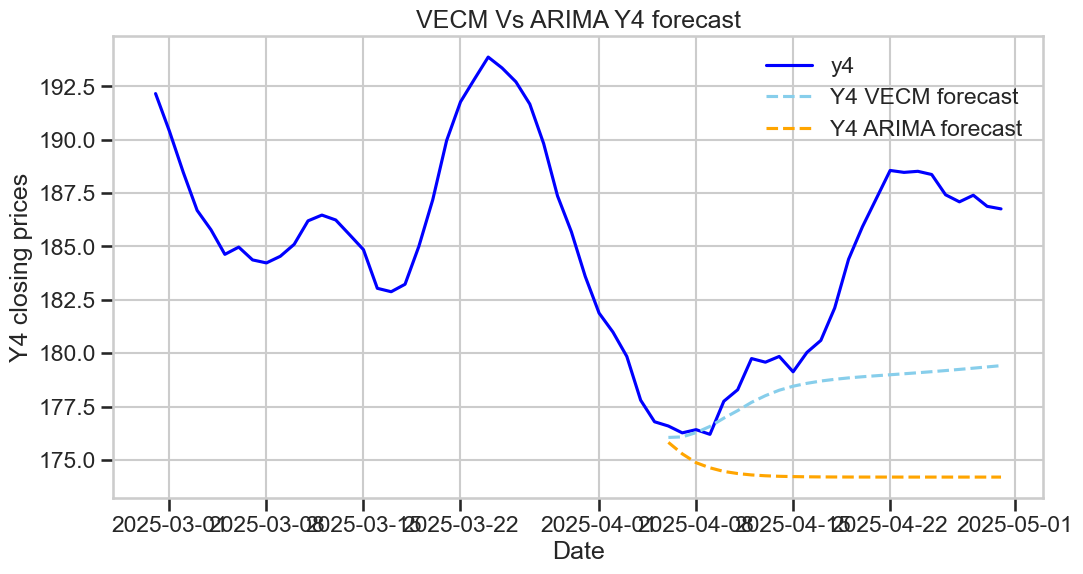

In [125]:
plt.figure(figsize=(12, 6))
# Plotting the true values (in-sample, out-of-sample)
plt.plot(last_2_months_df.index, 
         last_2_months_df["y4"], 
         label="y4", 
         color="blue", 
         linestyle="-")

# Plotting the VECM forecast
plt.plot(last_2_months_df.index, 
         last_2_months_df["vecm_y_fore"], 
         label="Y4 VECM forecast", 
         color="skyblue", 
         linestyle="dashed")
# Plotting the ARIMA forecast
plt.plot(last_2_months_df.index, 
         last_2_months_df["arima_y4_forecast"], 
         label="Y4 ARIMA forecast", 
         color="orange", 
         linestyle="dashed")

plt.title("VECM Vs ARIMA Y4 forecast")
plt.xlabel("Date")
plt.ylabel("Y4 closing prices")
plt.legend()# Organize the dictionary into a DataFrame
table_data = []

for target in ['y1', 'y4']:
    row = {}
    for metric in ['mae', 'rmse', 'mape', 'amape']:
        for model in ['vecm', 'arima']:
            key = f"{model}_{metric}_{target}"
            row[(model.upper(), metric.upper())] = performance_evaluation_matrics[key]
    table_data.append(row)

metrics_df = pd.DataFrame(table_data, index=['Y1', 'Y4'])
metrics_df.columns = pd.MultiIndex.from_tuples(metrics_df.columns)

plt.grid(True)

plt.show()

### Comparing VECM vs ARIMA performance

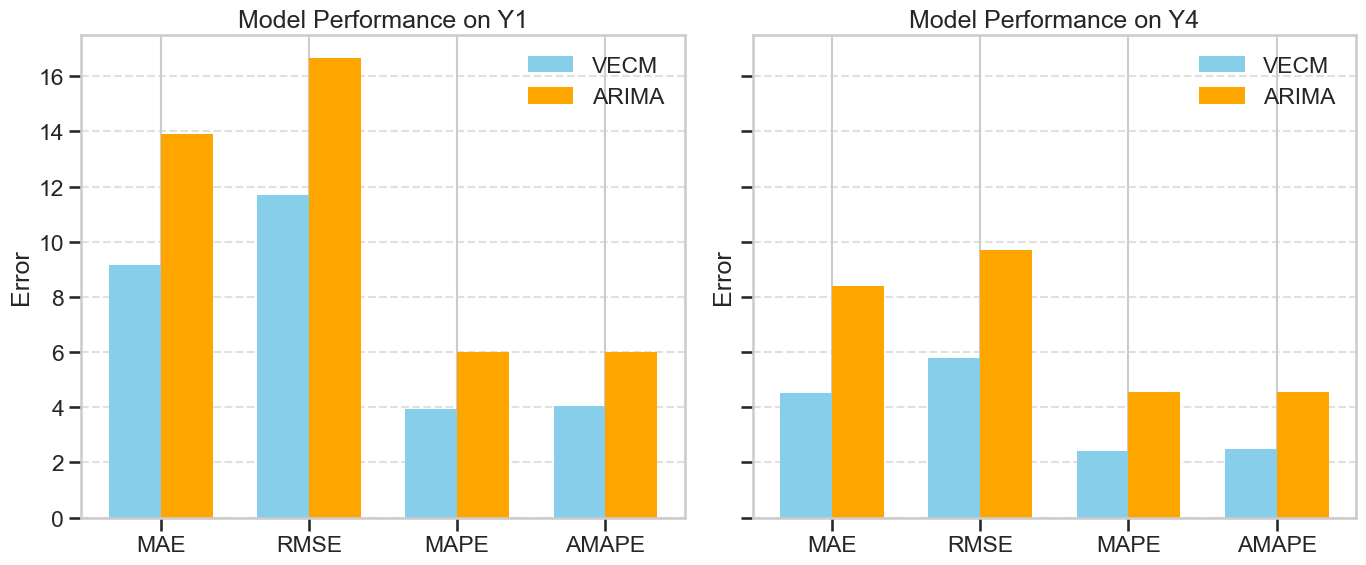

In [126]:
# Define models, metrics, and targets
models = ['vecm', 'arima']
metrics = ['mae', 'rmse', 'mape', 'amape']
targets = ['y1', 'y4']

# Create plots for each target variable
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

for i, target in enumerate(targets):
    ax = axs[i]
    values = []
    for metric in metrics:
        values.append([
            performance_evaluation_matrics[f'{model}_{metric}_{target}']
            for model in models
        ])

    values = np.array(values)
    x = np.arange(len(metrics))  # the label locations
    width = 0.35  # the width of the bars

    ax.bar(x - width/2, values[:, 0], width, label='VECM', color='skyblue')
    ax.bar(x + width/2, values[:, 1], width, label='ARIMA', color='orange')

    ax.set_ylabel('Error')
    ax.set_title(f'Model Performance on {target.upper()}')
    ax.set_xticks(x)
    ax.set_xticklabels([m.upper() for m in metrics])
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [127]:
# Organize the dictionary into a DataFrame
records = []
# Original dictionary
data = performance_evaluation_matrics

for key, value in data.items():
    model, metric, target = key.split('_')
    records.append({
        'Target': target.upper(),
        'Model': model.upper(),
        'Metric': metric.upper(),
        'Value': round(float(value), 4)
    })

# Create the DataFrame
metrics_df_long = pd.DataFrame(records)

pivot_df = metrics_df_long.pivot_table(
    index=['Target', 'Model'],
    columns='Metric',
    values='Value'
).reset_index()

# Clean column names
pivot_df.columns.name = None  # remove multiindex name
pivot_df = pivot_df[['Target', 'Model', 'MAE', 'RMSE', 'MAPE', 'AMAPE']]


In [128]:
pivot_df.set_index(['Target', 'Model'], inplace=True)
display(pivot_df)

MAE    RMSE   MAPE  AMAPE
Target Model                              
Y1     ARIMA 13.9107 16.6461 5.9929 5.9929
       VECM   9.1487 11.7061 3.9198 4.0481
Y4     ARIMA  8.4060  9.6848 4.5360 4.5360
       VECM   4.5264  5.7890 2.4292 2.4780


# 8. Final Report and Conclusion

---

## 1. Objective

This project aims to model and forecast financial time series variables using:
- **VECM (Vector Error Correction Model)** for cointegrated multivariate time series.
- **ARIMA (AutoRegressive Integrated Moving Average)** for univariate series.

---

## 2. Data & Preprocessing

- Financial time series data was imported and visualized.
- Initial stationarity checks and visual inspections confirmed the presence of trends.
- Differencing was used where needed to induce stationarity.

---

## 3. Cointegration Analysis

- **Johansen Cointegration Test** was applied to detect cointegrated relationships among the series.
- The test identified cointegrated vectors, justifying the use of a **VECM**.

---

## 4. VECM Modeling

- **Lag order selection** was performed using information criteria.
- Cointegration rank was selected using trace and max eigenvalue statistics.
- Key elements analyzed:
  - **Cointegrating relationships**
  - **Adjustment coefficients (α)**
  - **Short-run dynamics (Γ matrices)**
  - **Residual diagnostics**
- **Model improvements** suggested based on residual analysis.

**Impulse Response & FEVD**
- Impulse response functions showed dynamic effects of shocks.
- Forecast error variance decomposition (FEVD) revealed how each variable contributes to forecast uncertainty.

---

## 5. ARIMA Modeling

Separate ARIMA models were built for:
- **Y1** and **Y4**

Following the **Box-Jenkins procedure**:
- ACF/PACF analysis guided initial model selection.
- AIC/BIC used for model refinement.
- Residual diagnostics ensured white noise behavior.
- Multiple specifications were compared for robustness.

---

## 6. Forecasting & Performance Evaluation

Forecasts were generated for both Y1 and Y4 using **VECM** and **ARIMA**, and their performance was evaluated using:

| Target | Model | MAE   | RMSE  | MAPE  | AMAPE |
|--------|--------|--------|--------|--------|--------|
| Y1     | VECM   | 9.149 | 11.706 | 3.920 | 4.048 |
| Y1     | ARIMA  | 13.911 | 16.646 | 5.993 | 5.993 |
| Y4     | VECM   | 4.526 | 5.789  | 2.429 | 2.478 |
| Y4     | ARIMA  | 8.406 | 9.685  | 4.536 | 4.536 |

---

## 7. Conclusions

- **VECM outperformed ARIMA** on both Y1 and Y4 across all metrics (MAE, RMSE, MAPE, AMAPE).
- This suggests a strong cointegrated relationship between the series.
- Impulse response and FEVD analyses further supported model interpretability.

---

## Recommendations

- For future applications involving multiple related time series, VECM is preferable **if cointegration is detected**.
- ARIMA can still serve as a useful benchmark or for isolated series without cointegration.
